# To be continued or discontinued: investigating secret formula for successful movie franchise
This notebook contains in-depth analysis and visualization for our project. Some figures in the blog post is taken from this notebook.

### 0 - Import Necessary Libraries

In [1]:
import base64
from IPython.display import display, HTML
import os
import json
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

import numpy as np
import pandas as pd


### 1 - Font Importation and Color Palette


In [2]:
### Imports the font in your current notebook

current_dir = os.getcwd()
font_path = os.path.join(current_dir, "src/utils/JetBrainsMono-Regular.otf")

# Read and encode the font file
with open(font_path, "rb") as font_file:
    encoded_font = base64.b64encode(font_file.read()).decode()

font_css = f"""
<style>
@font-face {{
    font-family: 'JetBrains Mono';
    src: url(data:font/otf;base64,{encoded_font});
}}
</style>
"""
display(HTML(font_css))


### Color palette
yellow_palette=["#FFEE00","#D5C923","#AAA239","#807B40","#555339","#33322B"] # goes from bright yellow to dark yellow

## Data loading and preprocessing

__Delete unused import before submission__

In [3]:
%load_ext autoreload
%autoreload 2
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# custom functions
from src.data.utils import get_franchise_movies, get_inflation_rate, get_movie, clean_character_metadata, custom_autopct, create_ethnicity_columns, get_tree_df, get_genre_counts, get_franchise_data, clean_categories, get_1_2_movies
from src.utils.plotting import plot_geo_piecharts
from src.utils.importance import run_importance
sns.set_theme(style='darkgrid', palette='colorblind', color_codes=True)


We'll start by loading the character data and drop rows if any of the columns in `COL_FOR_DROPNA` is missing. This will make the following analysis easier without dropping too many rows (55467/395202 dropped).

__DO NOT EDIT THE LOADING ORDER OF `character_df`, `movies_df_raw`, `franchise_df` AND `movies_no_franchise_df`.__

In [4]:
COL_NAMES = [
    'Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 
    'Actor_date_of_birth', 'Actor_gender', 'Actor_height_m', 'Actor_ethnicity_Freebase_ID', 
    'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character_actor_map_ID', 
    'Freebase_character_ID', 'Freebase_actor_ID'
]
COL_FOR_DROPNA = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date',
                  'Actor_gender', 'Actor_name', 'Freebase_character_actor_map_ID',
                  'Freebase_actor_ID']
RANDOM_STATE = 42

In [5]:
# load and prepare character_df
character_df = pd.read_csv('data/character.metadata.tsv', names=COL_NAMES, sep='\t')
character_df = clean_character_metadata(character_df, mapping_path='data/ethnicity_mapping.csv', columns=COL_FOR_DROPNA)

#loading the inflation rate data set from the columbia bank
inflation_rate_df=get_inflation_rate()
#loading the complete data set 
movies_df_raw = pd.read_csv('data/movie_metadata_with_tmdb.csv')
#movies_df_raw = create_ethnicity_columns(movies_df_raw, character_df)
#Data frame with all the movies with preprocessing
movies_df=get_movie(movies_df_raw,inflation_rate_df)

#loading the data set for the franchise movies 
franchise_df=get_franchise_movies(movies_df_raw,inflation_rate_df,'data/missing_dates_manualsearch.csv')
#Data frame with movies that are not part of a franchise
movies_no_franchise_df = movies_df[movies_df['collection_id'].isna()].reset_index(drop=True)

# create a new column to check if the movie is part of a franchise
character_df["is_in_franchise"] = character_df["Wikipedia_movie_ID"].isin(franchise_df["Wikipedia movie ID"])

#Data frame of only the franchise name and their characteristics
franchise_data_df = get_franchise_data(franchise_df)

# Drop franchises where any movie in the franchise does not have a release date
# franchise_df_2 = franchise_df.groupby('collection_id').filter(lambda x: x['Movie release date'].notna().all())
# print("Number of movies with all movies having release dates : ", len(franchise_df_2))
# print(franchise_df)

Dropping character data rows with missing values in any of ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Actor_gender', 'Actor_name', 'Freebase_character_actor_map_ID', 'Freebase_actor_ID'].
Number of rows dropped: 55467
395202 rows remaining.
Running sentiment analysis...


100%|██████████| 52034/52034 [00:28<00:00, 1817.94it/s]


## First look of the data

In [6]:
# Counting the number of movies per collections
franchise_counts = franchise_df.groupby(by='collection_id')['Wikipedia movie ID'].count()
# Assuming franchise_df and franchise_counts are already defined

# Step 1: Convert franchise_counts Series to DataFrame
franchise_counts_df = franchise_counts.reset_index(name='franchise_count')

# Step 2: Merge with franchise_df to add 'collection_name'
franchise_counts_df = pd.merge(franchise_counts_df, franchise_df[['collection_id', 'collection_name']].drop_duplicates(), on='collection_id', how='left')

# Display the updated franchise_counts_df
print(franchise_counts_df.head())



   collection_id  franchise_count                            collection_name
0           10.0                6                       Star Wars Collection
1           84.0                4                   Indiana Jones Collection
2          119.0                3           The Lord of the Rings Collection
3          131.0                3                    Three Colors Collection
4          151.0                6  Star Trek: The Original Series Collection


When importing the data, we decided to directly drop the franchises that had only one movie, as it would bias our analysis (it means that the other movies in the collections were not included in the dataset as they were released after 2016). 
Now, we have 1595 collections, with 5173 movies, which we deem enough. We also see a strong outlier that has 66 movies (the maximum).


boxplot_intro

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Filter data to exclude outliers (e.g., values > 4)
filtered_counts = [x for x in franchise_counts if x <= 4]

# Prepare the list of outlier franchise names (this assumes that franchise_counts_df contains 'collection_name')
outlier_names = franchise_counts_df[franchise_counts_df['franchise_count'] > 4]['collection_name'].tolist()
print(outlier_names)
# Create subplots
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=(
        "Box plot of franchise sizes (with outliers)",
        "Box plot of franchise sizes (without outliers)"
    )
)

# Boxplot with outliers
fig.add_trace(
    go.Box(
        x=franchise_counts_df['franchise_count'],
        boxpoints="outliers",  # Show only outliers
        orientation="h",  # Horizontal orientation
        text=franchise_counts_df['collection_name'],  # Add franchise names as text for outliers
        hovertext=franchise_counts_df['collection_name'],  # Display the names when hovering over outliers
        hoverinfo="text"  # Display only text on hover
    ),
    row=1, col=1
)

# Boxplot without outliers (filtered data)
fig.add_trace(
    go.Box(
        x=filtered_counts,
        boxpoints=False,  # Do not show outliers
        orientation="h"  # Horizontal orientation
    ),
    row=2, col=1
)

# Update layout
fig.update_layout(
    height=600,
    width=800,
    title="Franchise Sizes",
    showlegend=False,  # Disable the legend
    hovermode="closest"  # Ensure hover text is displayed for closest point
)

# Update axis labels
fig.update_xaxes(title_text="Number of movies", row=1, col=1)
fig.update_xaxes(title_text="Number of movies", row=2, col=1)

fig.update_yaxes(showticklabels=False, row=1, col=1)
fig.update_yaxes(showticklabels=False, row=2, col=1)

# Show the plot
fig.show()


['Star Wars Collection', 'Star Trek: The Original Series Collection', 'James Bond Collection', 'Saw Collection', 'The Pink Panther (Original) Collection', 'Harry Potter Collection', 'Die Hard Collection', 'Rocky Collection', 'Planet of the Apes (Original) Collection', 'Aces Go Places Collection', 'Dr. Dolittle Collection', 'Jerry Cotton Collection', 'Highlander Collection', 'Superman Collection', 'A Nightmare on Elm Street Collection', 'Final Destination Collection', 'Hellraiser Collection', 'The Prophecy Collection', 'Police Academy Collection', 'The Fast and the Furious Collection', 'Friday the 13th Collection', 'Babylon 5 Collection', "Child's Play Collection", 'Dirty Harry Collection', 'Once Upon a Time in China Collection', 'Le Gendarme de Saint-Tropez Collection', 'Universal Soldier Collection', 'The Olsen Gang Collection', "St. Trinian's Collection", 'Herbie Collection', 'The Exorcist Collection', 'Death Wish Collection', 'Resident Evil Collection', 'The Land Before Time Collect

In [8]:
##---TO MODIFY---##
website_dir = "/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA1/ADA/ada-website.github.io" ### Change to your 'ada_website' directory

graph_name = "boxplot_intro" ### Assign graph name
##---------------##

graph_json_path = website_dir + "/_includes/graphs/" + graph_name + ".json"
graph_html_path = website_dir + "/_includes/graphs/" + graph_name + ".html"
# Save the graph as JSON (this only includes the data and layout)
pio.write_json(fig, graph_json_path)

with open(graph_json_path, 'r') as json_file:
    graph_data = json.load(json_file)

# Create the minimal HTML structure with Plotly CDN
html_content = f"""
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Plotly Graph</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
</head>
<body>
    <div id="{graph_name}" style="width: 100%; height: 500px;"></div>
    <script>
        var graphData = {json.dumps(graph_data)};
        Plotly.newPlot('{graph_name}', graphData.data, graphData.layout);
    </script>
</body>
</html>
"""

with open(graph_html_path, 'w') as html_file:
    html_file.write(html_content)

Here, we can see that at least 75% of the franchises have between 2 and 4 movies. And when looking closely at the outliers, such as "Our gang: The Roach/Pathé silents (1922-1928)" with 66 movies, we see that they mostly do not correspond to sequels, but to franchises. This is something to keep in mind for the data analysis.

## Univariate Analysis 

In this part we've investigated each column of the dataset and visualized what we are working with and compared movie in franchise and movie that aren't.

### Genres

Now, we wanted to look more closely at the genre columns, as it is one of the parameters needed to answer our research questions. First, let's plot the genre proportions in the original dataset, with all the movies. 

N.B.: most movies are defined by multiple genres and not a unique one

Now, let's compare with the distribution in the movies in franchises subset:

Now, let's compare with the distribution in the movies in franchises subset:

Now, we know that there are a lot of unique, very specific and irrelevant genres in the original categories (such as "Kitchen sink realism"), that appear less than 2% and together represent 42% of the whole genres. We therefore chose to use the ones in the added TMDB dataset.

plot_3

In [9]:
# Flatten the list of genres and count the occurrences
flattened_genres = [genre for sublist in franchise_df['genres'] for genre in sublist]
genre_counts = Counter(flattened_genres)

# Convert the Counter object to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).reset_index()
genre_counts_df.columns = ['genre', 'count']

# Calculate the proportion of each genre
genre_counts_df['proportion [%]'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 100
genre_counts_df = genre_counts_df.sort_values(by='proportion [%]', ascending=False)
genre_counts_df['proportion [%]'] = genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Create the pie chart
fig = go.Figure()

fig.add_trace(go.Pie(
    labels=genre_counts_df['genre'],
    values=genre_counts_df['count'],
    textinfo='percent+label',
    insidetextorientation='radial'
))

# Update layout
fig.update_layout(
    title_text="Distribution of Genres in Collections",
    title_x=0.5,  # Center the title
)

# Show the plot
fig.show()

This looks better ! And we still have the same top 3 genre ! Let's now compare our franchise movies to non franchise movies, to see if they seem to follow the same distribution:

plot_4

In [10]:
# Process franchise movies genres
flattened_genres = [genre for sublist in franchise_df['genres'] for genre in sublist]
genre_counts = Counter(flattened_genres)
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).reset_index()
genre_counts_df.columns = ['genre', 'count']
genre_counts_df['proportion [%]'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 100
genre_counts_df['proportion [%]'] = genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Process non-franchise movies genres
nf_flattened_genres = [genre for sublist in movies_df['genres'] for genre in sublist]
nf_genre_counts = Counter(nf_flattened_genres)
nf_genre_counts_df = pd.DataFrame.from_dict(nf_genre_counts, orient='index', columns=['count']).reset_index()
nf_genre_counts_df.columns = ['genre', 'count']
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['count'] / nf_genre_counts_df['count'].sum() * 100
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Combine data for Plotly
genres = sorted(set(genre_counts_df['genre']).union(set(nf_genre_counts_df['genre'])))
franchise_proportions = [
    genre_counts_df.loc[genre_counts_df['genre'] == genre, 'proportion [%]'].values[0]
    if genre in genre_counts_df['genre'].values else 0
    for genre in genres
]
non_franchise_proportions = [
    nf_genre_counts_df.loc[nf_genre_counts_df['genre'] == genre, 'proportion [%]'].values[0]
    if genre in nf_genre_counts_df['genre'].values else 0
    for genre in genres
]

# Create the grouped bar chart
fig = go.Figure()

# Franchise movies bar
fig.add_trace(go.Bar(
    x=genres,
    y=franchise_proportions,
    name="Franchise Movies",
    marker_color="skyblue"
))

# Non-franchise movies bar
fig.add_trace(go.Bar(
    x=genres,
    y=non_franchise_proportions,
    name="Non-Franchise Movies",
    marker_color="orange",
    opacity=0.8
))

# Update layout
fig.update_layout(
    title="Genre Proportions: Franchise vs. Non-Franchise Movies",
    xaxis_title="Genre",
    yaxis_title="Proportion [%]",
    barmode="group",
    legend_title="Category",
    xaxis=dict(tickangle=90),
    height=600,
    width=1000
)

# Show the plot
fig.show()

### Time representation

For this part we used the released date as the main variable to analyze first the movies in the franchise collection and then the franchise as a whole

#### Distribution of the release year of movies in a franchise vs the whole CMU dataset

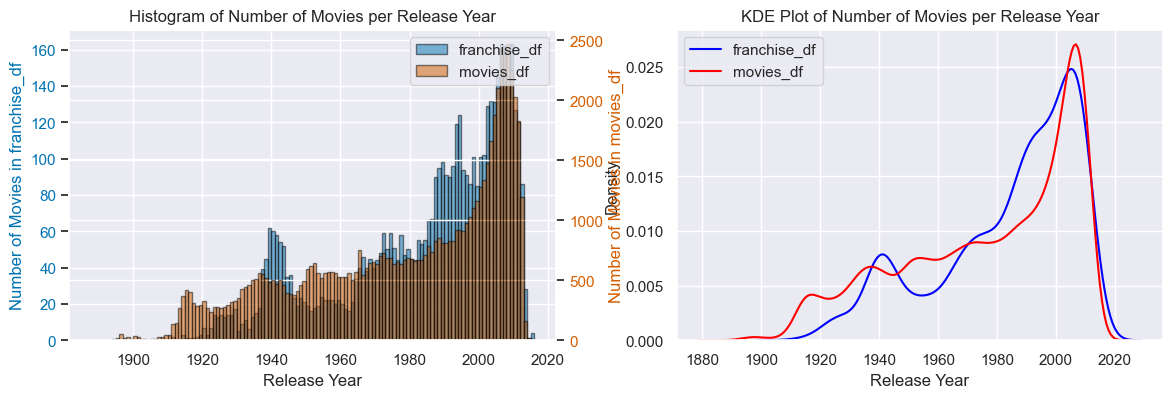

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12, 4))

# Plot the histogram for franchise_df
ax[0].hist(franchise_df['release_year'].dropna(), bins=range(int(franchise_df['release_year'].min()), int(franchise_df['release_year'].max()) + 1), edgecolor='black', alpha=0.5, label='franchise_df')
ax[0].set_xlabel('Release Year')
ax[0].set_ylabel('Number of Movies in franchise_df', color='b')
ax[0].tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the movies_df histogram
ax2 = ax[0].twinx()
ax2.hist(movies_df['release_year'].dropna(), bins=range(int(movies_df['release_year'].min()), int(movies_df['release_year'].max()) + 1), edgecolor='black', alpha=0.5, color='r', label='movies_df')
ax2.set_ylabel('Number of Movies in movies_df', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Histogram of Number of Movies per Release Year')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax[0].transAxes)


# Plot the KDE for franchise_df
sns.kdeplot(franchise_df['release_year'].dropna(), ax=ax[1], label='franchise_df', color='blue')

# Plot the KDE for movies_df
sns.kdeplot(movies_df['release_year'].dropna(), ax=ax[1], label='movies_df', color='red')

# Set labels and title
ax[1].set_xlabel('Release Year')
ax[1].set_ylabel('Density')
ax[1].set_title('KDE Plot of Number of Movies per Release Year')
ax[1].legend()

plt.show()

We observe that the subset we created from the CMU Movie dataset by extracting the franchise of at least 2 movies has more or less the same distribution of release year. Note that the CMU Movie dataset has 8% missing date. The franchise one has none since it is really necessary to know the order of the movie in a franchise, the missing release date missing were recovered.

#### Franchise length and movie release frequency

The franchise_data_df is the dataframe of all the franchise and add the different characteristics: total revenue (if all the movie have a revenue), average vote of the franchise, number of movies, oldest movie release date of the franchise, most recent release date of the franchise, length and average time between the movies in a franchise.

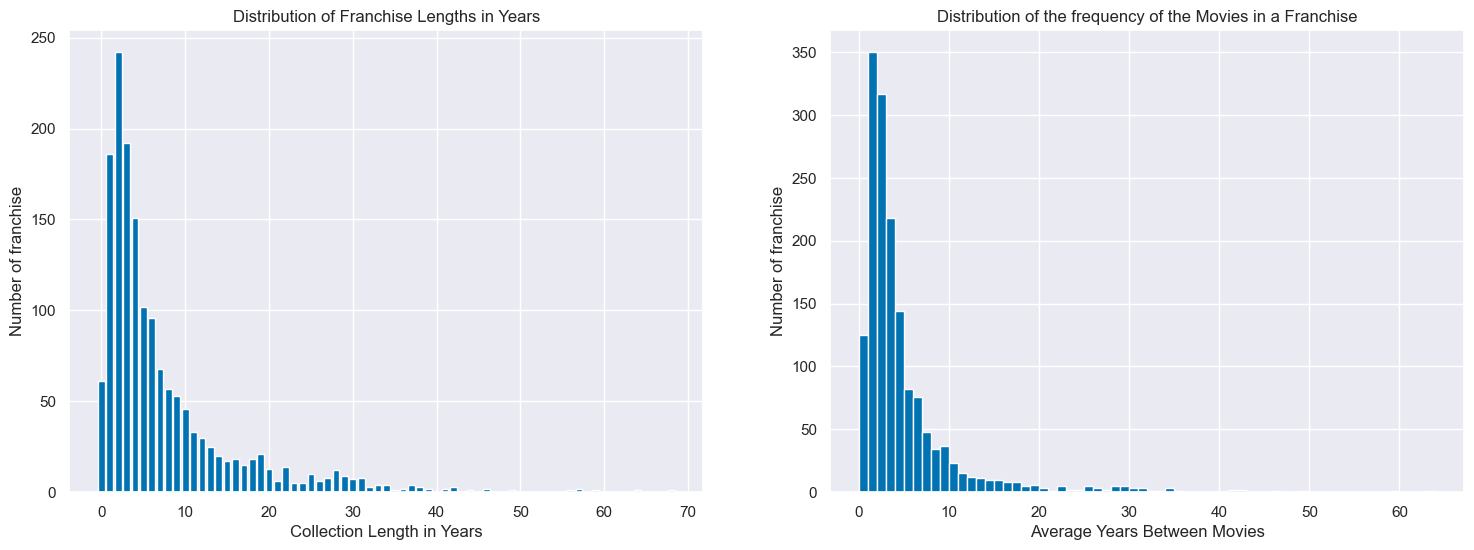

In [12]:
#Data frame of only the franchise name and their characteristics
franchise_data_df = get_franchise_data(franchise_df)

# Count the number of franchise with the same length
franchise_data_df_length = franchise_data_df['franchise_length_years'].value_counts().reset_index()
franchise_data_df_length.columns = ['franchise_length_years', 'count']

# Count the number of franchise with the same average years between movies
franchise_data_df_avbm = franchise_data_df['average_years_bt_movies'].value_counts().reset_index()
franchise_data_df_avbm.columns = ['average_years_bt_movies', 'count']
# Create bins for each year
bins = np.arange(franchise_data_df_avbm['average_years_bt_movies'].min(), franchise_data_df_avbm['average_years_bt_movies'].max() + 1, 1)

# Count the number of movie with the same year gap between the previous movie
franchise_df_ydbpm = franchise_df['years_diff_bt_pre_movies'].value_counts().reset_index()
franchise_df_ydbpm.columns = ['years_diff_bt_pre_movies', 'count']


# Plotting the bar chart
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].bar(franchise_data_df_length['franchise_length_years'], franchise_data_df_length['count'])
ax[0].set_xlabel('Collection Length in Years')
ax[0].set_ylabel('Number of franchise')
ax[0].set_title('Distribution of Franchise Lengths in Years')

ax[1].hist(franchise_data_df['average_years_bt_movies'], bins=bins, edgecolor='white')
ax[1].set_xlabel('Average Years Between Movies')
ax[1].set_ylabel('Number of franchise')

ax[1].set_title('Distribution of the frequency of the Movies in a Franchise')
plt.show()

In [13]:
# outsiders
#franchise of more than 20 years
long_franchise = franchise_data_df[franchise_data_df['franchise_length_years'] > 20]
print(long_franchise['collection_name'])
#franchise witha an average of more than 15 years between movies
long_average = franchise_data_df[franchise_data_df['average_years_bt_movies'] > 15]
print(long_average['collection_name'])


0                   Star Wars Collection
1               Indiana Jones Collection
11                   Predator Collection
16             The Terminator Collection
19                 James Bond Collection
                      ...               
1535          Lupin The Third Collection
1556      Goin' Down the Road Collection
1568                             Khiladi
1574                Samrajyam Collection
1586    The Snake King's Wife Collection
Name: collection_name, Length: 128, dtype: object
57              The Space Odyssey Series
85       An American Werewolf Collection
123            Drunken Master Collection
145             Burnt by the Sun Trilogy
207               Wall Street Collection
                      ...               
1496                 Tom Cody Collection
1498       Debbie Does Dallas Collection
1556      Goin' Down the Road Collection
1574                Samrajyam Collection
1586    The Snake King's Wife Collection
Name: collection_name, Length: 82, dtype: object

We observe that the vast majority of the franchise are in a close range with still pretty big range. We're going to use this parameter to describe the franchise in a following part.

### Vote distribution

In [14]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

# Filter vote_average > 0
franchise_votes = franchise_df[franchise_df['vote_average'] > 0]['vote_average'].dropna()
movies_votes = movies_df[movies_df['vote_average'] > 0]['vote_average'].dropna()

# Compute KDE for franchise_df
franchise_kde = gaussian_kde(franchise_votes)
franchise_x = np.linspace(franchise_votes.min(), franchise_votes.max(), 200)
franchise_y = franchise_kde(franchise_x)

# Compute KDE for movies_df
movies_kde = gaussian_kde(movies_votes)
movies_x = np.linspace(movies_votes.min(), movies_votes.max(), 200)
movies_y = movies_kde(movies_x)

# Calculate medians
franchise_median = np.median(franchise_votes)
movies_median = np.median(movies_votes)

# Create the plot
fig = go.Figure()

# Add franchise KDE line
fig.add_trace(go.Scatter(
    x=franchise_x, 
    y=franchise_y, 
    mode='lines', 
    name='Franchise KDE',
    line=dict(color='blue')
))

# Add movies KDE line
fig.add_trace(go.Scatter(
    x=movies_x, 
    y=movies_y, 
    mode='lines', 
    name='Movies KDE',
    line=dict(color='red')
))

# Add vertical line for franchise median
fig.add_trace(go.Scatter(
    x=[franchise_median, franchise_median], 
    y=[0, max(franchise_y)], 
    mode='lines',
    line=dict(color='blue', dash='dash'),
    name=f'Franchise Median: {franchise_median:.2f}'
))

# Add vertical line for movies median
fig.add_trace(go.Scatter(
    x=[movies_median, movies_median], 
    y=[0, max(movies_y)], 
    mode='lines',
    line=dict(color='red', dash='dash'),
    name=f'Movies Median: {movies_median:.2f}'
))

# Customize layout
fig.update_layout(
    title="KDE Plot of Average Vote for Franchise and Movies",
    xaxis_title="Average Vote",
    yaxis_title="Density",
    template="plotly_white",
    legend=dict(title="Dataset")
)

# Show plot
fig.show()


We see that the Franchise movies are slightly better graded !

In [15]:
import plotly.express as px
import pandas as pd

# Sample preprocessing to calculate statistics
summary_stats = franchise_df.groupby("movie_order")["vote_average"].agg(
    mean_vote="mean",
    std_vote="std"
).reset_index()

# Create a bar plot with error bars
fig = px.bar(
    summary_stats,
    x="movie_order",
    y="mean_vote",
    error_y="std_vote",  # Add standard deviation as error bars
    title="Vote Average by Movie Order with Error Bars",
    labels={"movie_order": "Movie Order", "mean_vote": "Vote Average"},
    template="plotly_white"
)

# Customize layout
fig.update_layout(
    xaxis_title="Movie Order",
    yaxis_title="Vote Average",
    yaxis=dict(range=[0, 10]),  # Limit y-axis to the range 0-10
    bargap=0.2
)

# Show the plot
fig.show()

And that the second movie has a worse grade than the first !

### Countries repartition

Now, we want to focus on the franchises' countries of origin (using the tmdb dataset), and look at how they interact. First we plotted a pie chart to get a first look at which countries are most respresented in the dataset.

plot_7_2

In [16]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_geo_piecharts(movie_df, franchise_df, movies_no_franchise_df):
    # Process the list of countries for franchise movies
    list_of_countries = franchise_df.tmdb_origin_country.fillna('')
    for i in range(len(list_of_countries)):
        list_of_countries.iloc[i] = list_of_countries.iloc[i].strip("[]").replace("'", "").split(", ")

    # Flatten the list of countries and count occurrences
    country_counts = list_of_countries.explode().value_counts().drop("")

    # Group the counts of countries outside the top 7 into 'Others'
    top_countries = country_counts.nlargest(7)
    other_countries_count = country_counts.iloc[7:].sum()
    top_countries['Others'] = other_countries_count

    # Process the list of countries for non-franchise movies
    list_of_countries_non_fr = movies_no_franchise_df.tmdb_origin_country.fillna('')
    for i in range(len(list_of_countries_non_fr)):
        list_of_countries_non_fr.iloc[i] = list_of_countries_non_fr.iloc[i].strip("[]").replace("'", "").split(", ")

    # Flatten the list of countries and count occurrences
    country_counts_non_fr = list_of_countries_non_fr.explode().value_counts().drop("")

    # Group the counts of countries outside the top 7 into 'Others'
    top_countries_non_fr = country_counts_non_fr.nlargest(7)
    other_countries_count_non_fr = country_counts_non_fr.iloc[7:].sum()
    top_countries_non_fr['Others'] = other_countries_count_non_fr

    # Create subplots
    fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}]])

    # Pie chart for franchise movies
    fig.add_trace(go.Pie(
        labels=top_countries.index,
        values=top_countries.values,
        name='Top 7 Countries in Franchise',
        hole=0.3,  # Adds a hole in the middle for a donut chart effect
        textinfo='percent+label',  # Displays percentage and country label
        marker=dict(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])
    ), row=1, col=1)

    # Pie chart for non-franchise movies
    fig.add_trace(go.Pie(
        labels=top_countries_non_fr.index,
        values=top_countries_non_fr.values,
        name='Top 7 Countries in Non-Franchise',
        hole=0.3,  # Adds a hole in the middle for a donut chart effect
        textinfo='percent+label',  # Displays percentage and country label
        marker=dict(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])
    ), row=1, col=2)

    # Update layout to arrange charts side by side
    fig.update_layout(
        title="Movies by Geography",
        title_x=0.5,
        showlegend=True,
        annotations=[
            dict(
                x=0.20,
                y=1.1,
                text="Top 7 Countries in Franchise",
                showarrow=False,
                font=dict(size=14)
            ),
            dict(
                x=0.80,
                y=1.1,
                text="Top 7 Countries in Non-Franchise",
                showarrow=False,
                font=dict(size=14)
            )
        ]
    )

    fig.show()

plot_geo_piecharts(movies_df, franchise_df, movies_no_franchise_df)


Now, let's look at how they interact: the nodes in the plot below represent how often the country is the origin of a movie, and the edges indicate that two countries are listed together as the origin countries.

In [17]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import plotly.graph_objects as go
from itertools import combinations
from collections import Counter

def plot_network_with_plotly(franchise_df):
    # Step 1: Clean and Process Data
    cleaned_countries = []
    country_counts = Counter()
    # Iterate
    for movie in franchise_df['Movie countries (Freebase ID:name tuples)']:
        if pd.notnull(movie):
    # Split the country by comma and strip any extra characters
            country_list = [movie.split(":")[1].strip().replace("\"", "").replace("}", "") for movie in movie.split(",") if ":" in movie]
            country_list = ['China' if country == 'Hong Kong' else country for country in country_list]
            country_list = ['Germany' if country == 'West Germany' else country for country in country_list]
            country_list = ['Germany' if country == 'Weimar Republic' else country for country in country_list]
            country_list = ['Germany' if country == 'German Democratic Republic' else country for country in country_list]
            country_list = ['Malaysia' if country == 'Singapore' else country for country in country_list]
            country_list = ['United Kingdom' if country == 'Kingdom of Great Britain' else country for country in country_list]
            country_list = ['United Kingdom' if country == 'England' else country for country in country_list]
            country_list = ['Croatia' if country == 'Yugoslavia' else country for country in country_list]
            country_list = ['Czechia' if country == 'Czech Republic' else country for country in country_list]
            country_list = ['Czechia' if country == 'Czechoslovakia' else country for country in country_list]
            country_list = ['Czechia' if country == 'Federal Republic of Yugoslavia' else country for country in country_list]
            country_list = ['Russia' if country == 'Soviet Union' else country for country in country_list]
            country_list = ['United Kingdom' if country == 'Scotland' else country for country in country_list]
            country_list = ['United Kingdom' if country == 'Wales' else country for country in country_list]
            country_list = ['United Kingdom' if country == 'Northern Ireland' else country for country in country_list]
            country_list = ['North Macedonia' if country == 'Republic of Macedonia' else country for country in country_list]
            country_list = ['Germany' if country == 'Nazi Germany' or country == 'German Language' else country for country in country_list]
            country_list = ['Slovakia' if country == 'Slovak Republic' else country for country in country_list]
            country_list = ['Serbia' if country == 'Bosnia and Herzegovina' else country for country in country_list]
            country_list = ['Italy' if country == 'Kingdom of Italy' else country for country in country_list]
            country_list = ['South Korea' if country == 'Korea' else country for country in country_list]
            country_list = ['France' if country == 'Monaco' else country for country in country_list]
            country_list = ['Italy' if country == 'Malta' else country for country in country_list]
            country_list = ['Croatia' if country == 'Socialist Federal Republic of Yugoslavia' else country for country in country_list]
            country_list = ['Serbia' if country == 'Serbia and Montenegro' else country for country in country_list]
            country_list = ['United Kingdom' if country == 'Isle of Man' else country for country in country_list]
            country_list = ['Uzbekistan' if country == 'Uzbek SSR' else country for country in country_list]
            country_list = ['Palestine' if country == 'Mandatory Palestine' else country for country in country_list]
            country_list = ['Palestine' if country == 'Palestinian territories' or country == 'Palestinian Territories' else country for country in country_list]
            country_list = ['Myanmar' if country == 'Burma' else country for country in country_list]
            country_list = ['Germany' if country == 'Soviet occupation zone' else country for country in country_list]
            country_list = ['Ukraine' if country == 'Ukrainian SSR' or country == 'Ukranian SSR' else country for country in country_list]
            country_list = ['Georgia' if country == 'Georgian SSR' else country for country in country_list]
            #country_list = ['Kazakhstan' if country == 'Kazakh SSR' else country for country in country_list]
            #country_list = ['Kyrgyzstan' if country == 'Kirghiz SSR' else country for country in country_list]
            country_list = ['Congo' if country == 'Democratic Republic of the Congo' else country for country in country_list]
            country_list = ['Iraq' if country == 'Iraqi Kurdistan' else country for country in country_list]
            country_list = ['Venezuela' if country == 'Aruba' else country for country in country_list]
            country_list = ['China' if country == 'Republic of China' or country == 'Macau' else country for country in country_list]
            country_list = ['India' if country == 'Malayalam Language' else country for country in country_list]

            country_counts.update(country_list)
            cleaned_countries.append(country_list)

    country_counts_df = pd.DataFrame.from_dict(country_counts, orient='index', columns=['counts']).reset_index()
    country_counts_df.columns = ['country', 'counts']

    # Step 2: Create Pairs of Countries
    country_pairs = []
    for countries in cleaned_countries:
        if len(countries) > 1:
            country_pairs.extend(list(combinations(countries, 2)))

    # Step 3: Prepare World Map Data
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    unique_countries = set(country for countries in cleaned_countries for country in countries)

    country_coordinates = {}
    for country in unique_countries:
        country_data = world[world['name'] == country]
        if not country_data.empty:
            centroid = country_data.geometry.centroid.iloc[0]
            country_coordinates[country] = (centroid.x, centroid.y)

    # Step 4: Build the Network
    G = nx.Graph()
    for country, (x, y) in country_coordinates.items():
        G.add_node(country, pos=(x, y))

    for pair in country_pairs:
        G.add_edge(pair[0], pair[1])

    pos = nx.get_node_attributes(G, 'pos')

    # Step 5: Convert Network Data to Plotly
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scattergeo(
        lon=edge_x,
        lat=edge_y,
        mode='lines',
        line=dict(width=0.5, color='gray'),
        hoverinfo='none'
    )

    node_x, node_y, node_size, node_text = [], [], [], []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_size.append(country_counts[node] * 0.01)  # Adjust scaling factor if needed
        node_text.append(f"{node}: {country_counts[node]} films")

    node_trace = go.Scattergeo(
        lon=node_x,
        lat=node_y,
        mode='markers',
        marker=dict(
            size=node_size,
            color='blue',
            opacity=0.7,
            line=dict(width=0.5, color='black')
        ),
        text=node_text,
        hoverinfo='text'
    )

    # Step 6: Create and Display the Figure
    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(
        title="Geographical Network of Film Industry Connections",
        title_x=0.5,
        showlegend=False,
        geo=dict(
            scope='world',
            projection_type='natural earth',
            showland=True,
            landcolor='lightgrey',
            showcountries=True
        )
    )
    fig.show()

In [18]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import plotly.graph_objects as go
from itertools import combinations
from collections import Counter

def plot_network_with_plotly_normalized(franchise_df):
    # Step 1: Clean and Process Data
    cleaned_countries = []
    country_counts = Counter()
    for movie in franchise_df['Movie countries (Freebase ID:name tuples)']:
        if pd.notnull(movie):
            country_list = [movie.split(":")[1].strip().replace("\"", "").replace("}", "") for movie in movie.split(",") if ":" in movie]
            country_list = ['China' if country == 'Hong Kong' else country for country in country_list]
            country_list = ['Germany' if country == 'West Germany' else country for country in country_list]
            country_list = ['Germany' if country == 'Weimar Republic' else country for country in country_list]
            country_list = ['Germany' if country == 'German Democratic Republic' else country for country in country_list]
            country_list = ['Malaysia' if country == 'Singapore' else country for country in country_list]
            country_list = ['United Kingdom' if country == 'Kingdom of Great Britain' else country for country in country_list]
            country_list = ['United Kingdom' if country == 'England' else country for country in country_list]
            country_list = ['Croatia' if country == 'Yugoslavia' else country for country in country_list]
            country_list = ['Czechia' if country == 'Czech Republic' else country for country in country_list]
            country_list = ['Czechia' if country == 'Czechoslovakia' else country for country in country_list]
            country_list = ['Czechia' if country == 'Federal Republic of Yugoslavia' else country for country in country_list]
            country_list = ['Russia' if country == 'Soviet Union' else country for country in country_list]
            country_list = ['United Kingdom' if country == 'Scotland' else country for country in country_list]
            country_list = ['United Kingdom' if country == 'Wales' else country for country in country_list]
            country_list = ['United Kingdom' if country == 'Northern Ireland' else country for country in country_list]
            country_list = ['North Macedonia' if country == 'Republic of Macedonia' else country for country in country_list]
            country_list = ['Germany' if country == 'Nazi Germany' or country == 'German Language' else country for country in country_list]
            country_list = ['Slovakia' if country == 'Slovak Republic' else country for country in country_list]
            country_list = ['Serbia' if country == 'Bosnia and Herzegovina' else country for country in country_list]
            country_list = ['Italy' if country == 'Kingdom of Italy' else country for country in country_list]
            country_list = ['South Korea' if country == 'Korea' else country for country in country_list]
            country_list = ['France' if country == 'Monaco' else country for country in country_list]
            country_list = ['Italy' if country == 'Malta' else country for country in country_list]
            country_list = ['Croatia' if country == 'Socialist Federal Republic of Yugoslavia' else country for country in country_list]
            country_list = ['Serbia' if country == 'Serbia and Montenegro' else country for country in country_list]
            country_list = ['United Kingdom' if country == 'Isle of Man' else country for country in country_list]
            country_list = ['Uzbekistan' if country == 'Uzbek SSR' else country for country in country_list]
            country_list = ['Palestine' if country == 'Mandatory Palestine' else country for country in country_list]
            country_list = ['Palestine' if country == 'Palestinian territories' or country == 'Palestinian Territories' else country for country in country_list]
            country_list = ['Myanmar' if country == 'Burma' else country for country in country_list]
            country_list = ['Germany' if country == 'Soviet occupation zone' else country for country in country_list]
            country_list = ['Ukraine' if country == 'Ukrainian SSR' or country == 'Ukranian SSR' else country for country in country_list]
            country_list = ['Georgia' if country == 'Georgian SSR' else country for country in country_list]
            #country_list = ['Kazakhstan' if country == 'Kazakh SSR' else country for country in country_list]
            #country_list = ['Kyrgyzstan' if country == 'Kirghiz SSR' else country for country in country_list]
            country_list = ['Congo' if country == 'Democratic Republic of the Congo' else country for country in country_list]
            country_list = ['Iraq' if country == 'Iraqi Kurdistan' else country for country in country_list]
            country_list = ['Venezuela' if country == 'Aruba' else country for country in country_list]
            country_list = ['China' if country == 'Republic of China' or country == 'Macau' else country for country in country_list]
            country_list = ['India' if country == 'Malayalam Language' else country for country in country_list]

            country_counts.update(country_list)
            cleaned_countries.append(country_list)

    # Normalize the counts
    max_count = max(country_counts.values()) if country_counts else 1
    min_count = min(country_counts.values()) if country_counts else 0
    normalized_counts = {country: (count - min_count) / (max_count - min_count) * 10 + 5 for country, count in country_counts.items()}

    country_counts_df = pd.DataFrame.from_dict(country_counts, orient='index', columns=['counts']).reset_index()
    country_counts_df.columns = ['country', 'counts']

    # Step 2: Create Pairs of Countries
    country_pairs = []
    for countries in cleaned_countries:
        if len(countries) > 1:
            country_pairs.extend(list(combinations(countries, 2)))

    # Step 3: Prepare World Map Data
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    unique_countries = set(country for countries in cleaned_countries for country in countries)

    country_coordinates = {}
    for country in unique_countries:
        country_data = world[world['name'] == country]
        if not country_data.empty:
            centroid = country_data.geometry.centroid.iloc[0]
            country_coordinates[country] = (centroid.x, centroid.y)

    # Step 4: Build the Network
    G = nx.Graph()
    for country, (x, y) in country_coordinates.items():
        G.add_node(country, pos=(x, y))

    for pair in country_pairs:
        G.add_edge(pair[0], pair[1])

    pos = nx.get_node_attributes(G, 'pos')

    # Step 5: Convert Network Data to Plotly
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scattergeo(
        lon=edge_x,
        lat=edge_y,
        mode='lines',
        line=dict(width=0.5, color='gray'),
        hoverinfo='none'
    )

    node_x, node_y, node_size, node_text = [], [], [], []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_size.append(normalized_counts.get(node, 5))  # Default size if no data
        node_text.append(f"{node}: {country_counts[node]} films")

    node_trace = go.Scattergeo(
        lon=node_x,
        lat=node_y,
        mode='markers',
        marker=dict(
            size=node_size,
            color='blue',
            opacity=0.7,
            line=dict(width=0.5, color='black')
        ),
        text=node_text,
        hoverinfo='text'
    )

    # Step 6: Create and Display the Figure
    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(
        title="Geographical Network of Film Industry Connections",
        title_x=0.5,
        showlegend=False,
        geo=dict(
            scope='world',
            projection_type='natural earth',
            showland=True,
            landcolor='lightgrey',
            showcountries=True
        )
    )
    fig.show()
    return fig


plot_7 and plot_9

In [19]:
from src.utils.plotting import plot_network

plot_9 = plot_network_with_plotly_normalized(franchise_df)

# Filter out 'Republic of Macedonia' from movies_df before plotting
#filtered_movies_df = movies_df[movies_df['tmdb_origin_country'] != 'Republic of Macedonia']
# Check if filtering works as expected
#print('Republic of Macedonia' not in filtered_movies_df['tmdb_origin_country'].values, "Filtering did not remove 'Republic of Macedonia'.")

plot_7 = plot_network_with_plotly_normalized(movies_df)

In [20]:
##---TO MODIFY---##
website_dir = "/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA1/ADA/ada-website.github.io" ### Change to your 'ada_website' directory

graph_name = "plot_9" ### Assign graph name
##---------------##

graph_json_path = website_dir + "/_includes/graphs/" + graph_name + ".json"
graph_html_path = website_dir + "/_includes/graphs/" + graph_name + ".html"
# Save the graph as JSON (this only includes the data and layout)
pio.write_json(plot_9, graph_json_path)

with open(graph_json_path, 'r') as json_file:
    graph_data = json.load(json_file)

# Create the minimal HTML structure with Plotly CDN
html_content = f"""
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Plotly Graph</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
</head>
<body>
    <div id="{graph_name}" style="width: 100%; height: 500px;"></div>
    <script>
        var graphData = {json.dumps(graph_data)};
        Plotly.newPlot('{graph_name}', graphData.data, graphData.layout);
    </script>
</body>
</html>
"""

with open(graph_html_path, 'w') as html_file:
    html_file.write(html_content)

In [21]:
##---TO MODIFY---##
website_dir = "/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA1/ADA/ada-website.github.io" ### Change to your 'ada_website' directory

graph_name = "plot_7" ### Assign graph name
##---------------##

graph_json_path = website_dir + "/_includes/graphs/" + graph_name + ".json"
graph_html_path = website_dir + "/_includes/graphs/" + graph_name + ".html"
# Save the graph as JSON (this only includes the data and layout)
pio.write_json(plot_7, graph_json_path)

with open(graph_json_path, 'r') as json_file:
    graph_data = json.load(json_file)

# Create the minimal HTML structure with Plotly CDN
html_content = f"""
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Plotly Graph</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
</head>
<body>
    <div id="{graph_name}" style="width: 100%; height: 500px;"></div>
    <script>
        var graphData = {json.dumps(graph_data)};
        Plotly.newPlot('{graph_name}', graphData.data, graphData.layout);
    </script>
</body>
</html>
"""

with open(graph_html_path, 'w') as html_file:
    html_file.write(html_content)

### Actor identity analysis

In this part, we will particularly tackle Q2-3 of our research questions. That is:

> 2-3: Do actors of certain ethnicity/gender groups appear more or less commonly in franchise movies? Are they depicted positively (hero/heroine) or negatively (villain) in the movie?

#### Actor gender distribution
To begin with, we'll look at actor gender distribution of franchise and non-franchise movies.

plot_11

In [22]:
# Calculate the proportion of each gender for character_df
gender_proportion_non_fr = character_df[~character_df['is_in_franchise']]['Actor_gender'].value_counts()
# Calculate the proportion of each gender for fr_character_df
gender_proportion_franchise = character_df[character_df["is_in_franchise"]]['Actor_gender'].value_counts()

# Create subplots
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}]])

# Pie chart for franchise movies
fig.add_trace(go.Pie(
    labels=gender_proportion_franchise.index,
    values=gender_proportion_franchise.values,
    marker_line=dict(color='black', width=1),
    marker=dict(colors=["rgba(0, 0, 0, 0)", "#2471ff"]),
    pull=[0, 0.1],               #pull is the distance between the slices (to move them apart)
    textinfo='percent',          #text is what is displayed inside the plot
    textfont=dict(size=10),  
    hoverinfo='label+percent',   #hover is what is displayed when you hover over the plot
    hoverlabel=dict(font=dict(family='Jetbrains Mono', size=8)),
    hole=0.4,                    # create the "donut" effect
), row=1, col=1)

# Pie chart for non-franchise movies
fig.add_trace(go.Pie(
    labels=gender_proportion_non_fr.index,
    values=gender_proportion_non_fr.values,
    marker_line=dict(color='black', width=1),
    marker=dict(colors=["rgba(0, 0, 0, 0)", "#2471ff"]),
    pull=[0, 0.1],               #pull is the distance between the slices (to move them apart)
    textinfo='percent',          #text is what is displayed inside the plot
    textfont=dict(size=10),  
    hoverinfo='label+percent',   #hover is what is displayed when you hover over the plot
    hoverlabel=dict(font=dict(family='Jetbrains Mono', size=8)),
    hole=0.4,                    # create the "donut" effect
), row=1, col=2)

# Update layout to arrange charts side by side
fig.update_layout(
    title="Gender Proportions in Movies",
    title_x=0.5,
    showlegend=True,
    font=dict(
        size=30,
        family="JetBrains Mono",
        color="black",
    ),
    legend=dict(
        font=dict(size=10),
        xanchor='center',
        x=0.5,
        yanchor='top',
        y=-0.1,
        orientation='h'
    ),
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)',
    autosize=True,
    annotations=[
        dict(
            x=0.20,
            y=1.1,
            text="Non-Franchise Movies",
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            x=0.80,
            y=1.1,
            text="Franchise Movies",
            showarrow=False,
            font=dict(size=14)
        )
    ]
)

fig.show()


It seems that actor gender distribution remains the same for franchise and non-franchise movies. This is unsurprising as most of us can agree that there are particulalry many female characters in franchise movies than non-franchise movies, at least anecdotally.

#### Racial group
Next, we shift our focus to ethnicity groups. Contrary to actor gender information, actor ethnicity is not available for the majority of actors (available for 99719/395202 $\approx$ 25.2%). Upon observing the dataset, we hypothesized that the actors with known ethnicity are those with more publicity and therefore, more likely to play main roles in the movies. The ethnicity distribution of these main actors can be representative of which racial group is more or less featured in the movie. Bearing this in mind, we will proceed to visualize actors' racial group distribution for franchise and non-franchise movies.

plot_12

In [23]:
import plotly.graph_objects as go
import pandas as pd

# Calculate the percentage of each racial group for franchise and non-franchise movies
racial_proportion_franchise = character_df[character_df["is_in_franchise"]].value_counts("racial_group")
racial_proportion_non_franchise = character_df[~character_df['is_in_franchise']].value_counts("racial_group")
percentage_fr = (racial_proportion_franchise / racial_proportion_franchise.sum()) * 100
percentage_non_fr = (racial_proportion_non_franchise / racial_proportion_non_franchise.sum()) * 100
fr_count = racial_proportion_franchise.sum()
non_fr_count = racial_proportion_non_franchise.sum()

# Create the figure with two subplots side by side
fig = go.Figure()

# Plot for franchise movies
fig.add_trace(go.Bar(
    y=percentage_fr.index,
    x=percentage_fr.values,
    orientation='h',
    marker_line=dict(color='black', width=1),
    name=f'Franchise Movies',
    marker=dict(color='#2471ff'),
    text=[f'{val:.2f}%' for val in percentage_fr.values],  # Show percentage on hover
    hoverinfo='text',
))

# Plot for non-franchise movies
fig.add_trace(go.Bar(
    y=percentage_non_fr.index,
    x=percentage_non_fr.values,
    orientation='h',
    marker_line=dict(color='black', width=1),
    name=f'Non-Franchise Movies',
    marker=dict(color='rgba(0, 0, 0, 0)', line=dict(color='black', width=1)),
    text=[f'{val:.2f}%' for val in percentage_non_fr.values],  # Show percentage on hover
    hoverinfo='text',
))

# Update layout for side-by-side bars
fig.update_layout(
    title="Racial Group Distribution Comparison",
    barmode='group',
    xaxis=dict(
        title="Percentage [%]",
        range=[0, 55],  # Set x-axis range to be consistent
    ),
    yaxis=dict(
        title="Racial Group",
        autorange="reversed",  # Reverse the y-axis so the top groups appear first
    ),
    font=dict(
        size=15,
        family="JetBrains Mono",
        color="black",
    ),
    template="plotly_white",
    legend=dict(
        font=dict(size=10),
        xanchor='center',
        x=0.5,
        yanchor='top',
        y=-0.3,
        orientation='h'
    ),
    showlegend=True,
    margin=dict(l=100, r=40, t=80, b=40),  # Adjust margins for better spacing
    paper_bgcolor='rgba(0,0,0,0)', # to make the background transparent
    plot_bgcolor='rgba(0,0,0,0)'
)

# Show the plot
fig.show()


The percentages in each of the plots above sum up to 100%. Notice that compared to non-franchise movies, franchise movies have fewer percentage of Asian actors (Franchise: 14.78%, Non-franchise: 31.18%). If we compared this to the 4 pie charts from `Countries repartition` section, the two pie charts on the righthand side of the figure show that the proporitions of movies from Asia (excluding Russia, Oceania and Middle East) in franchise and non-franchise movies are not as different as the disparity observed earlie in Asian actor percentages.

This means that the disparity in the percentage of Asian actors comes from factors other than the movie production location. It is hard to identify the exact cause for this from our analysis only, but a potential confounding factor can be difference in genres: perhaps certain movie genres are more likely to be franchised which are underrepresented by Asian actors.

#### Sentimental analysis

Comment for word cloud - what are the typical adjectives used to positively or negatively describe the character?

plot_13

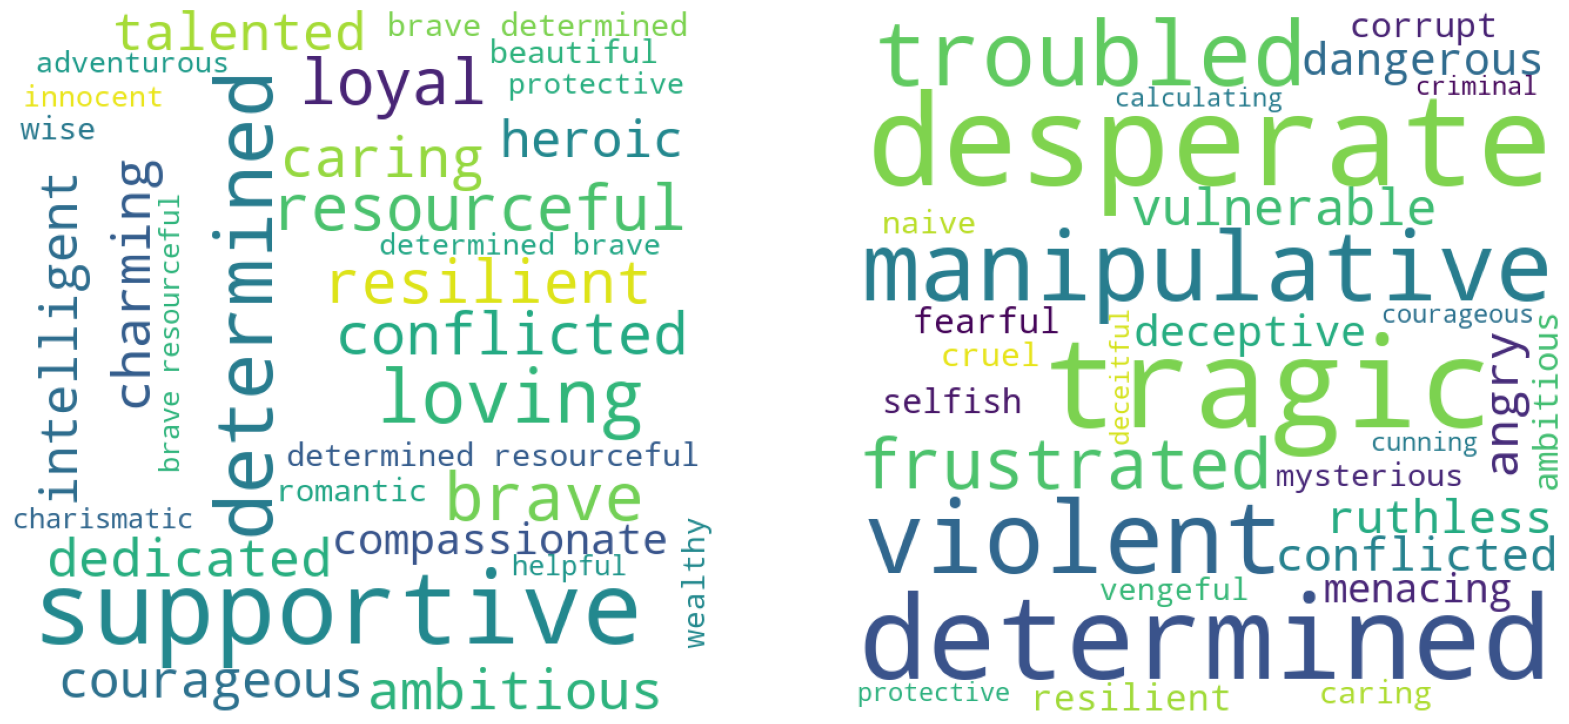

<Figure size 640x480 with 0 Axes>

In [24]:
csfont = {'fontname':'JetBrains Mono'}
# Generate text for positive and negative sentiment scores
positive_text = ",".join(character_df[character_df.sentiment_score > 0.1].Adjectives)
negative_text = ",".join(character_df[character_df.sentiment_score < -0.1].Adjectives)

# Create word clouds
positive_wordcloud = WordCloud(width=600, height=600, background_color='white',
                               min_font_size=10, max_words=30).generate(positive_text)
negative_wordcloud = WordCloud(width=600, height=600, background_color='white',
                               min_font_size=10, max_words=30).generate(negative_text)

# Plot the word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(positive_wordcloud)
#axes[0].set_title('Positive Adjectives', fontsize=30, fontweight='bold', **csfont)
axes[0].axis('off')

axes[1].imshow(negative_wordcloud)
#axes[1].set_title('Negative Adjectives', fontsize=30, fontweight='bold')
axes[1].axis('off')

plt.show()
#### retirer titre + background filling 0
plt.savefig("data/images/plot_13.png")

Box plot - no racial group stands out in terms of distribution.

plot 14

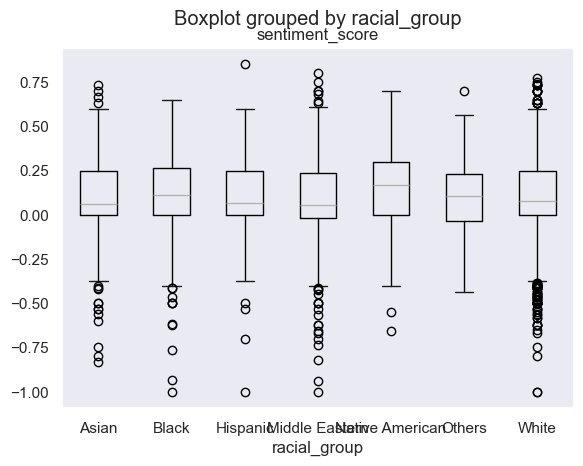

In [25]:
'''# Plot box plots of sentiment_score for each racial group
plt.figure(figsize=(12, 8))
character_df[character_df.is_in_franchise].dropna(subset=['sentiment_score']).boxplot(column='sentiment_score', by='racial_group', grid=False)
movie_count = len(character_df.dropna(subset=['sentiment_score']))
plt.title(f'Sentiment Scores by Racial Group (total: {movie_count})')
plt.suptitle('')  # Suppress the default title to avoid overlap
plt.xlabel('Racial Group')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.show()'''

import plotly.express as px

# Filter the DataFrame
filtered_df = character_df[character_df.is_in_franchise].dropna(subset=['sentiment_score'])
character_df[character_df.is_in_franchise].dropna(subset=['sentiment_score']).boxplot(column='sentiment_score', by='racial_group', grid=False)
movie_count = len(character_df.dropna(subset=['sentiment_score']))
# Create the box plot
fig = px.box(filtered_df, x='racial_group', y='sentiment_score', title=f'Sentiment Scores by Racial Group (total: {movie_count})')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Racial Group',
    yaxis_title='Sentiment Score',
    xaxis_tickangle=-45,
    paper_bgcolor='rgba(0,0,0,0)',  # to make the background transparent
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(
        size=15,
        family="JetBrains Mono",
        color="black",
    )
)

# Show the plot
fig.show()


### Movie revenue box office

In [26]:
franchise_revenue = franchise_df.dropna(subset=['real_revenue'])
movies_revenue = movies_df.dropna(subset=['real_revenue']) 
movies_no_franchise_revenue = movies_no_franchise_df.dropna(subset=['real_revenue'])

plot 8

In [27]:

import plotly.graph_objects as go
import pandas as pd

# Create the DataFrame for revenue
all_revenue = pd.DataFrame({
    'non-franchise movies': movies_no_franchise_revenue['real_revenue'],
    'franchise movies': franchise_revenue['real_revenue'],
    'all movies': movies_revenue['real_revenue']
})

def remove_outliers(series):
    Q1 = series.quantile(0.25)  # 25th percentile
    Q3 = series.quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1              # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]

# Remove outliers for each category
filtered_revenue = all_revenue.apply(remove_outliers)

# Create a list of box plots
fig = go.Figure()

# Box plot with outliers
fig.add_trace(go.Box(
    y=movies_no_franchise_revenue['real_revenue'],
    name='Non-Franchise Movies',
    boxpoints='outliers',  # Include all points (outliers included)
    marker=dict(color='skyblue'),
    hovertext=movies_no_franchise_revenue['Movie name'] + '<br>Revenue: ' + ((movies_no_franchise_revenue['real_revenue'] / 1e9).round(2)).astype(str) + ' B$',
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=8)),
    hoverinfo="text",  # Display only text on hover

))

fig.add_trace(go.Box(
    y=franchise_revenue['real_revenue'],
    name='Franchise Movies',
    boxpoints='outliers',  # Include all points (outliers included)
    marker=dict(color='#2471ff'),
    hovertext=franchise_revenue['Movie name'] + '<br>Revenue: ' + ((franchise_revenue['real_revenue'] / 1e9).round(2)).astype(str) + ' B$',
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=8)),
    hoverinfo="text",  # Display only text on hover

))

fig.add_trace(go.Box(
    y=movies_revenue['real_revenue'],
    name='All Movies',
    boxpoints='outliers',  # Include all points (outliers included)
    marker=dict(color='green'),
    #labels={"Movie name": "Movie Name", "real_revenue": "Revenue"},
    hovertext=movies_revenue['Movie name'] + '<br>Revenue: ' + ((movies_revenue['real_revenue'] / 1e9).round(2)).astype(str) + ' B$',
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=8)),
    hoverinfo="text",  # Display only text on hover
))

# Update layout for the box plot with outliers
fig.update_layout(
    title='Comparison of Movie Box Office Revenue (With Outliers)',
    yaxis_title='Box Office Revenue [Billions $]',
    xaxis_title='Movie Categories',
    template='plotly_white',
    boxmode='group',  # Group the boxes
    font=dict(family="JetBrains Mono", size=14),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=False
)

# Display the first plot (with outliers)
fig.show()

# Box plot without outliers
fig_no_outliers = go.Figure()

fig_no_outliers.add_trace(go.Box(
    y=filtered_revenue['non-franchise movies'],
    name='Non-Franchise Movies',
    marker=dict(color='skyblue'),
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=10)),
    boxpoints=False  # Do not include outliers
))

fig_no_outliers.add_trace(go.Box(
    y=filtered_revenue['franchise movies'],
    name='Franchise Movies',
    marker=dict(color='#2471ff'),
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=10)),
    boxpoints=False  # Do not include outliers
))

fig_no_outliers.add_trace(go.Box(
    y=filtered_revenue['all movies'],
    name='All Movies',
    marker=dict(color='green'),
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=10)),
    boxpoints=False  # Do not include outliers
))

# Update layout for the box plot without outliers
fig_no_outliers.update_layout(
    title='Comparison of Movie Box Office Revenue (Without Outliers)',
    yaxis_title='Box Office Revenue [$]',
    xaxis_title='Movie Categories',
    template='plotly_white',
    boxmode='group',  # Group the boxes
    font=dict(family="JetBrains Mono", size=14),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=False
)

# Display the second plot (without outliers)
fig_no_outliers.show()


### Movie budget

plot 13

In [30]:
all_budget= pd.DataFrame({
        'non-franchise movies': movies_no_franchise_revenue['real_budget'], #movie_box['Movie box office revenue'],
        'franchise movies': franchise_revenue['real_budget'], # box_office_df['Movie box office revenue']
        'all movies': movies_revenue['real_budget']
        })



def remove_outliers(series):
    Q1 = series.quantile(0.25)  # 25th percentile
    Q3 = series.quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1              # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]

# Remove outliers for each category
filtered_budget = all_budget.apply(remove_outliers)

# Create a list of box plots
fig = go.Figure()

# Box plot with outliers
fig.add_trace(go.Box(
    y=movies_no_franchise_revenue['real_budget'],
    name='Non-Franchise Movies',
    boxpoints='outliers',  # Include all points (outliers included)
    marker=dict(color='skyblue'),
    hovertext=movies_no_franchise_revenue['Movie name'] + '<br>Revenue: ' + ((movies_no_franchise_revenue['real_budget'] / 1e9).round(2)).astype(str) + ' B$',
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=8)),
    hoverinfo="text",  # Display only text on hover

))

fig.add_trace(go.Box(
    y=franchise_revenue['real_budget'],
    name='Franchise Movies',
    boxpoints='outliers',  # Include all points (outliers included)
    marker=dict(color='#2471ff'),
    hovertext=franchise_revenue['Movie name'] + '<br>Revenue: ' + ((franchise_revenue['real_budget'] / 1e9).round(2)).astype(str) + ' B$',
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=8)),
    hoverinfo="text",  # Display only text on hover

))

fig.add_trace(go.Box(
    y=movies_revenue['real_budget'],
    name='All Movies',
    boxpoints='outliers',  # Include all points (outliers included)
    marker=dict(color='green'),
    #labels={"Movie name": "Movie Name", "real_revenue": "Revenue"},
    hovertext=movies_revenue['Movie name'] + '<br>Revenue: ' + ((movies_revenue['real_budget'] / 1e9).round(2)).astype(str) + ' B$',
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=8)),
    hoverinfo="text",  # Display only text on hover
))

# Update layout for the box plot with outliers
fig.update_layout(
    #title='Comparison of Movie Budget (With Outliers)',
    yaxis_title='Budget [$]',
    xaxis_title='Movie Categories',
    template='plotly_white',
    boxmode='group',  # Group the boxes
    font=dict(family="JetBrains Mono", size=14),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=False
)

# Display the first plot (with outliers)
fig.show()

# Box plot without outliers
fig_no_outliers = go.Figure()

fig_no_outliers.add_trace(go.Box(
    y=filtered_budget['non-franchise movies'],
    name='Non-Franchise Movies',
    marker=dict(color='skyblue'),
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=10)),
    boxpoints=False  # Do not include outliers
))

fig_no_outliers.add_trace(go.Box(
    y=filtered_budget['franchise movies'],
    name='Franchise Movies',
    marker=dict(color='#2471ff'),
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=10)),
    boxpoints=False  # Do not include outliers
))

fig_no_outliers.add_trace(go.Box(
    y=filtered_budget['all movies'],
    name='All Movies',
    marker=dict(color='green'),
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=10)),
    boxpoints=False  # Do not include outliers
))

# Update layout for the box plot without outliers
fig_no_outliers.update_layout(
    #title='Comparison of Movie Budget (Without Outliers)',
    yaxis_title='Budget [$]',
    xaxis_title='Movie Categories',
    template='plotly_white',
    boxmode='group',  # Group the boxes
    font=dict(family="JetBrains Mono", size=14),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=False
)

# Display the second plot (without outliers)
fig_no_outliers.show()


Comparing movie revenue and budget along the movie order in a collection

plot 14

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Define the function to remove outliers
def remove_outliers(series):
    Q1 = series.quantile(0.25)  # 25th percentile
    Q3 = series.quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1               # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]

# Filter the data for movie orders <= 11
filtered_data = franchise_revenue[franchise_revenue['movie_order'] <= 11]

# Apply outlier removal to the ratio_revenue_budget column for each movie order
filtered_data['ratio_revenue_budget'] = filtered_data.groupby('movie_order')['ratio_revenue_budget'].transform(remove_outliers)

# Drop rows with NaN values created by outlier removal
filtered_data = filtered_data.dropna(subset=['ratio_revenue_budget'])

# Create a boxplot with filtered data
fig = go.Figure()

# Add box plot traces for each movie order
for order in sorted(filtered_data['movie_order'].unique()):
    fig.add_trace(go.Box(
        y=filtered_data[filtered_data['movie_order'] == order]['ratio_revenue_budget'],
        name=str(order),  # Ensure the order is treated as a category (string)
        marker_color='#2471ff',
        hoverlabel=dict(font=dict(family='Jetbrains Mono', size=8)),
        boxmean=True,
        boxpoints=False
    ))

# Update layout
fig.update_layout(
    title="Mean Ratio (Revenue/Budget) Sorted by Franchise Order (Outliers Removed)",
    xaxis=dict(
        title="Movie Order",
        categoryorder="array",  # Ensure the order of categories is consistent
        categoryarray=[str(order) for order in sorted(filtered_data['movie_order'].unique())]
    ),
    yaxis=dict(title="Ratio Revenue Over Budget"),
    font=dict(family="JetBrains Mono", size=14),
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent plot area
    title_x=0.5,  # Center the title
    showlegend=False,
    margin=dict(t=100)
)

# Show the plot
fig.show()


/var/folders/pk/zbd7z2k51w5_w89mv7brxxzm0000gn/T/ipykernel_76526/342504028.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Bivariate analysis 

In this part we're going to look at the possible interaction 2 features have with another, this the first step to try to observe patterns or links.

### Movie revenue \& budget 

In [46]:

import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots

# Calculate Pearson and Spearman correlations
pearson_corr_df = pd.DataFrame({
    'Movies': ['All Movies', 'Franchise Movies', 'Non-Franchise Movies'],
    'Pearson Correlation': [
        movies_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1],
        franchise_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1],
        movies_no_franchise_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1]
    ]
})

spearman_corr_df = pd.DataFrame({'Movies': ['All Movies', 'Franchise Movies', 'Non-Franchise Movies'],
    'Spearman Correlation': [
        movies_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1],
        franchise_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1],
        movies_no_franchise_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1]
    ]
})

# Create subplots using Plotly
fig = make_subplots(
    rows=1, cols=3,  # 1 row, 3 columns
)

# Add scatter plot for Non-Franchise Movies
fig.add_trace(go.Scatter(
    x=movies_no_franchise_revenue['real_revenue'],
    y=movies_no_franchise_revenue['real_budget'],
    mode='markers',
    name='Non-Franchise Movies',
    hovertext=movies_revenue['Movie name'] + '<br>Revenue: ' + ((movies_revenue['real_budget'] / 1e9).round(2)).astype(str) + ' B$',
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=8)),
    hoverinfo="text",  # Display only text on hover
    marker=dict(color='skyblue', opacity=0.5)
), row=1, col=1)

# Add scatter plot for Franchise Movies
fig.add_trace(go.Scatter(
    x=franchise_revenue['real_revenue'],
    y=franchise_revenue['real_budget'],
    mode='markers',
    name='Franchise Movies',
    hovertext=movies_revenue['Movie name'] + '<br>Revenue: ' + ((movies_revenue['real_budget'] / 1e9).round(2)).astype(str) + ' B$',
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=8)),
    hoverinfo="text",  # Display only text on hover
    marker=dict(color='#2471ff', opacity=0.5)
), row=1, col=2)

# Add scatter plot for All Movies
fig.add_trace(go.Scatter(
    x=movies_revenue['real_revenue'],
    y=movies_revenue['real_budget'],
    mode='markers',
    name='All Movies',
    hovertext=movies_revenue['Movie name'] + '<br>Revenue: ' + ((movies_revenue['real_budget'] / 1e9).round(2)).astype(str) + ' B$',
    hoverlabel = dict(font=dict(family='Jetbrains Mono', size=8)),
    hoverinfo="text",  # Display only text on hover
    marker=dict(color='green', opacity=0.5)
), row=1, col=3)

# Manually add annotations for the titles with new lines
fig.add_annotation(
    x=0.17, y=1.05, xref="paper", yref="paper",
    text=f'Non-Franchise Movies<br>Pearson: {pearson_corr_df.iloc[0, 1]:.2f}<br>Spearman: {spearman_corr_df.iloc[0, 1]:.2f}',
    showarrow=False,
    font=dict(size=12),
    align="left"
)

fig.add_annotation(
    x=0.5, y=1.05, xref="paper", yref="paper",
    text=f'Franchise Movies<br>Pearson: {pearson_corr_df.iloc[1, 1]:.2f}<br>Spearman: {spearman_corr_df.iloc[1, 1]:.2f}',
    showarrow=False,
    font=dict(size=12),
    align="center"
)

fig.add_annotation(
    x=0.83, y=1.05, xref="paper", yref="paper",
    text=f'All Movies<br>      Pearson: {pearson_corr_df.iloc[2, 1]:.2f}<br>       Spearman: {spearman_corr_df.iloc[2, 1]:.2f}',
    showarrow=False,
    font=dict(size=12),
    align="right"
)

# Update layout to add titles and axis labels
fig.update_layout(
    title='Scatter Plots of Real Revenue vs. Real Budget',
    xaxis=dict(
        title='Real Revenue',
        anchor='center'),
    #showlegend=False,  # Hide the legend to prevent overlapping
    template='plotly_white',  # Use a clean white background template
    font=dict(family="JetBrains Mono", size=14),
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
    plot_bgcolor='rgba(0,0,0,0)',
    height=500,  # Set a fixed height for the entire figure
    width=1100,  # Set a fixed width for the entire figure
    showlegend=True,
    margin=dict(l=100, r=40, t=80, b=40), 
    yaxis=dict(title='Real Budget [$]', domain=[0, 1]),  # Position y-axis on the left
)

fig.show()


ValueError: 
    Invalid value of type 'builtins.str' received for the 'anchor' property of layout.xaxis
        Received value: 'center'

    The 'anchor' property is an enumeration that may be specified as:
      - One of the following enumeration values:
            ['free']
      - A string that matches one of the following regular expressions:
            ['^x([2-9]|[1-9][0-9]+)?( domain)?$',
            '^y([2-9]|[1-9][0-9]+)?( domain)?$']

In [42]:
import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots

# Calculate Pearson and Spearman correlations
pearson_corr_df = pd.DataFrame({
    'Movies': ['All Movies', 'Franchise Movies', 'Non-Franchise Movies'],
    'Pearson Correlation': [
        movies_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1],
        franchise_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1],
        movies_no_franchise_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1]
    ]
})

spearman_corr_df = pd.DataFrame({'Movies': ['All Movies', 'Franchise Movies', 'Non-Franchise Movies'],
    'Spearman Correlation': [
        movies_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1],
        franchise_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1],
        movies_no_franchise_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1]
    ]
})

# Create subplots using Plotly
fig = make_subplots(
    rows=1, cols=3,  # 1 row, 3 columns
    shared_xaxes=True  # Share the x-axis across subplots
)

# Add scatter plot for Non-Franchise Movies
fig.add_trace(go.Scatter(
    x=movies_no_franchise_revenue['real_revenue'],
    y=movies_no_franchise_revenue['real_budget'],
    mode='markers',
    name='Non-Franchise Movies',
    marker=dict(color='skyblue', opacity=0.5)
), row=1, col=1)

# Add scatter plot for Franchise Movies
fig.add_trace(go.Scatter(
    x=franchise_revenue['real_revenue'],
    y=franchise_revenue['real_budget'],
    mode='markers',
    name='Franchise Movies',
    marker=dict(color='#2471ff', opacity=0.5)
), row=1, col=2)

# Add scatter plot for All Movies
fig.add_trace(go.Scatter(
    x=movies_revenue['real_revenue'],
    y=movies_revenue['real_budget'],
    mode='markers',
    name='All Movies',
    marker=dict(color='green', opacity=0.5)
), row=1, col=3)

# Manually add annotations for the titles with new lines
fig.add_annotation(
    x=0.17, y=1.05, xref="paper", yref="paper",
    text=f'Non-Franchise Movies<br>Pearson: {pearson_corr_df.iloc[0, 1]:.2f}<br>Spearman: {spearman_corr_df.iloc[0, 1]:.2f}',
    showarrow=False,
    font=dict(size=12),
    align="left"
)

fig.add_annotation(
    x=0.5, y=1.05, xref="paper", yref="paper",
    text=f'Franchise Movies<br>Pearson: {pearson_corr_df.iloc[1, 1]:.2f}<br>Spearman: {spearman_corr_df.iloc[1, 1]:.2f}',
    showarrow=False,
    font=dict(size=12),
    align="center"
)

fig.add_annotation(
    x=0.83, y=1.05, xref="paper", yref="paper",
    text=f'All Movies<br>      Pearson: {pearson_corr_df.iloc[2, 1]:.2f}<br>       Spearman: {spearman_corr_df.iloc[2, 1]:.2f}',
    showarrow=False,
    font=dict(size=12),
    align="right"
)

# Update layout to add titles and axis labels
fig.update_layout(
    title='Scatter Plots of Real Revenue vs. Real Budget',
    showlegend=False,  # Hide the legend to prevent overlapping
    template='plotly_white',  # Use a clean white background template
    font=dict(family="JetBrains Mono", size=14),
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent plot area
    height=500,  # Set a fixed height for the entire figure
    width=1100,  # Set a fixed width for the entire figure
    xaxis=dict(title='Real Revenue [$]',x=0.5),#, domain=[0.3, 0.7]),  # Position x-axis in the middle
    yaxis=dict(title='Real Budget [$]', domain=[0, 1]),  # Position y-axis on the left
)

fig.show()


ValueError: Invalid property specified for object of type plotly.graph_objs.layout.XAxis: 'x'

Did you mean "side"?

    Valid properties:
        anchor
            If set to an opposite-letter axis id (e.g. `x2`, `y`),
            this axis is bound to the corresponding opposite-letter
            axis. If set to "free", this axis' position is
            determined by `position`.
        automargin
            Determines whether long tick labels automatically grow
            the figure margins.
        autorange
            Determines whether or not the range of this axis is
            computed in relation to the input data. See `rangemode`
            for more info. If `range` is provided and it has a
            value for both the lower and upper bound, `autorange`
            is set to False. Using "min" applies autorange only to
            set the minimum. Using "max" applies autorange only to
            set the maximum. Using *min reversed* applies autorange
            only to set the minimum on a reversed axis. Using *max
            reversed* applies autorange only to set the maximum on
            a reversed axis. Using "reversed" applies autorange on
            both ends and reverses the axis direction.
        autorangeoptions
            :class:`plotly.graph_objects.layout.xaxis.Autorangeopti
            ons` instance or dict with compatible properties
        autotickangles
            When `tickangle` is set to "auto", it will be set to
            the first angle in this array that is large enough to
            prevent label overlap.
        autotypenumbers
            Using "strict" a numeric string in trace data is not
            converted to a number. Using *convert types* a numeric
            string in trace data may be treated as a number during
            automatic axis `type` detection. Defaults to
            layout.autotypenumbers.
        calendar
            Sets the calendar system to use for `range` and `tick0`
            if this is a date axis. This does not set the calendar
            for interpreting data on this axis, that's specified in
            the trace or via the global `layout.calendar`
        categoryarray
            Sets the order in which categories on this axis appear.
            Only has an effect if `categoryorder` is set to
            "array". Used with `categoryorder`.
        categoryarraysrc
            Sets the source reference on Chart Studio Cloud for
            `categoryarray`.
        categoryorder
            Specifies the ordering logic for the case of
            categorical variables. By default, plotly uses "trace",
            which specifies the order that is present in the data
            supplied. Set `categoryorder` to *category ascending*
            or *category descending* if order should be determined
            by the alphanumerical order of the category names. Set
            `categoryorder` to "array" to derive the ordering from
            the attribute `categoryarray`. If a category is not
            found in the `categoryarray` array, the sorting
            behavior for that attribute will be identical to the
            "trace" mode. The unspecified categories will follow
            the categories in `categoryarray`. Set `categoryorder`
            to *total ascending* or *total descending* if order
            should be determined by the numerical order of the
            values. Similarly, the order can be determined by the
            min, max, sum, mean, geometric mean or median of all
            the values.
        color
            Sets default for all colors associated with this axis
            all at once: line, font, tick, and grid colors. Grid
            color is lightened by blending this with the plot
            background Individual pieces can override this.
        constrain
            If this axis needs to be compressed (either due to its
            own `scaleanchor` and `scaleratio` or those of the
            other axis), determines how that happens: by increasing
            the "range", or by decreasing the "domain". Default is
            "domain" for axes containing image traces, "range"
            otherwise.
        constraintoward
            If this axis needs to be compressed (either due to its
            own `scaleanchor` and `scaleratio` or those of the
            other axis), determines which direction we push the
            originally specified plot area. Options are "left",
            "center" (default), and "right" for x axes, and "top",
            "middle" (default), and "bottom" for y axes.
        dividercolor
            Sets the color of the dividers Only has an effect on
            "multicategory" axes.
        dividerwidth
            Sets the width (in px) of the dividers Only has an
            effect on "multicategory" axes.
        domain
            Sets the domain of this axis (in plot fraction).
        dtick
            Sets the step in-between ticks on this axis. Use with
            `tick0`. Must be a positive number, or special strings
            available to "log" and "date" axes. If the axis `type`
            is "log", then ticks are set every 10^(n*dtick) where n
            is the tick number. For example, to set a tick mark at
            1, 10, 100, 1000, ... set dtick to 1. To set tick marks
            at 1, 100, 10000, ... set dtick to 2. To set tick marks
            at 1, 5, 25, 125, 625, 3125, ... set dtick to
            log_10(5), or 0.69897000433. "log" has several special
            values; "L<f>", where `f` is a positive number, gives
            ticks linearly spaced in value (but not position). For
            example `tick0` = 0.1, `dtick` = "L0.5" will put ticks
            at 0.1, 0.6, 1.1, 1.6 etc. To show powers of 10 plus
            small digits between, use "D1" (all digits) or "D2"
            (only 2 and 5). `tick0` is ignored for "D1" and "D2".
            If the axis `type` is "date", then you must convert the
            time to milliseconds. For example, to set the interval
            between ticks to one day, set `dtick` to 86400000.0.
            "date" also has special values "M<n>" gives ticks
            spaced by a number of months. `n` must be a positive
            integer. To set ticks on the 15th of every third month,
            set `tick0` to "2000-01-15" and `dtick` to "M3". To set
            ticks every 4 years, set `dtick` to "M48"
        exponentformat
            Determines a formatting rule for the tick exponents.
            For example, consider the number 1,000,000,000. If
            "none", it appears as 1,000,000,000. If "e", 1e+9. If
            "E", 1E+9. If "power", 1x10^9 (with 9 in a super
            script). If "SI", 1G. If "B", 1B.
        fixedrange
            Determines whether or not this axis is zoom-able. If
            true, then zoom is disabled.
        gridcolor
            Sets the color of the grid lines.
        griddash
            Sets the dash style of lines. Set to a dash type string
            ("solid", "dot", "dash", "longdash", "dashdot", or
            "longdashdot") or a dash length list in px (eg
            "5px,10px,2px,2px").
        gridwidth
            Sets the width (in px) of the grid lines.
        hoverformat
            Sets the hover text formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display "09~15~23.46"
        insiderange
            Could be used to set the desired inside range of this
            axis (excluding the labels) when `ticklabelposition` of
            the anchored axis has "inside". Not implemented for
            axes with `type` "log". This would be ignored when
            `range` is provided.
        labelalias
            Replacement text for specific tick or hover labels. For
            example using {US: 'USA', CA: 'Canada'} changes US to
            USA and CA to Canada. The labels we would have shown
            must match the keys exactly, after adding any
            tickprefix or ticksuffix. For negative numbers the
            minus sign symbol used (U+2212) is wider than the
            regular ascii dash. That means you need to use −1
            instead of -1. labelalias can be used with any axis
            type, and both keys (if needed) and values (if desired)
            can include html-like tags or MathJax.
        layer
            Sets the layer on which this axis is displayed. If
            *above traces*, this axis is displayed above all the
            subplot's traces If *below traces*, this axis is
            displayed below all the subplot's traces, but above the
            grid lines. Useful when used together with scatter-like
            traces with `cliponaxis` set to False to show markers
            and/or text nodes above this axis.
        linecolor
            Sets the axis line color.
        linewidth
            Sets the width (in px) of the axis line.
        matches
            If set to another axis id (e.g. `x2`, `y`), the range
            of this axis will match the range of the corresponding
            axis in data-coordinates space. Moreover, matching axes
            share auto-range values, category lists and histogram
            auto-bins. Note that setting axes simultaneously in
            both a `scaleanchor` and a `matches` constraint is
            currently forbidden. Moreover, note that matching axes
            must have the same `type`.
        maxallowed
            Determines the maximum range of this axis.
        minallowed
            Determines the minimum range of this axis.
        minexponent
            Hide SI prefix for 10^n if |n| is below this number.
            This only has an effect when `tickformat` is "SI" or
            "B".
        minor
            :class:`plotly.graph_objects.layout.xaxis.Minor`
            instance or dict with compatible properties
        mirror
            Determines if the axis lines or/and ticks are mirrored
            to the opposite side of the plotting area. If True, the
            axis lines are mirrored. If "ticks", the axis lines and
            ticks are mirrored. If False, mirroring is disable. If
            "all", axis lines are mirrored on all shared-axes
            subplots. If "allticks", axis lines and ticks are
            mirrored on all shared-axes subplots.
        nticks
            Specifies the maximum number of ticks for the
            particular axis. The actual number of ticks will be
            chosen automatically to be less than or equal to
            `nticks`. Has an effect only if `tickmode` is set to
            "auto".
        overlaying
            If set a same-letter axis id, this axis is overlaid on
            top of the corresponding same-letter axis, with traces
            and axes visible for both axes. If False, this axis
            does not overlay any same-letter axes. In this case,
            for axes with overlapping domains only the highest-
            numbered axis will be visible.
        position
            Sets the position of this axis in the plotting space
            (in normalized coordinates). Only has an effect if
            `anchor` is set to "free".
        range
            Sets the range of this axis. If the axis `type` is
            "log", then you must take the log of your desired range
            (e.g. to set the range from 1 to 100, set the range
            from 0 to 2). If the axis `type` is "date", it should
            be date strings, like date data, though Date objects
            and unix milliseconds will be accepted and converted to
            strings. If the axis `type` is "category", it should be
            numbers, using the scale where each category is
            assigned a serial number from zero in the order it
            appears. Leaving either or both elements `null` impacts
            the default `autorange`.
        rangebreaks
            A tuple of
            :class:`plotly.graph_objects.layout.xaxis.Rangebreak`
            instances or dicts with compatible properties
        rangebreakdefaults
            When used in a template (as
            layout.template.layout.xaxis.rangebreakdefaults), sets
            the default property values to use for elements of
            layout.xaxis.rangebreaks
        rangemode
            If "normal", the range is computed in relation to the
            extrema of the input data. If *tozero*`, the range
            extends to 0, regardless of the input data If
            "nonnegative", the range is non-negative, regardless of
            the input data. Applies only to linear axes.
        rangeselector
            :class:`plotly.graph_objects.layout.xaxis.Rangeselector
            ` instance or dict with compatible properties
        rangeslider
            :class:`plotly.graph_objects.layout.xaxis.Rangeslider`
            instance or dict with compatible properties
        scaleanchor
            If set to another axis id (e.g. `x2`, `y`), the range
            of this axis changes together with the range of the
            corresponding axis such that the scale of pixels per
            unit is in a constant ratio. Both axes are still
            zoomable, but when you zoom one, the other will zoom
            the same amount, keeping a fixed midpoint. `constrain`
            and `constraintoward` determine how we enforce the
            constraint. You can chain these, ie `yaxis:
            {scaleanchor: *x*}, xaxis2: {scaleanchor: *y*}` but you
            can only link axes of the same `type`. The linked axis
            can have the opposite letter (to constrain the aspect
            ratio) or the same letter (to match scales across
            subplots). Loops (`yaxis: {scaleanchor: *x*}, xaxis:
            {scaleanchor: *y*}` or longer) are redundant and the
            last constraint encountered will be ignored to avoid
            possible inconsistent constraints via `scaleratio`.
            Note that setting axes simultaneously in both a
            `scaleanchor` and a `matches` constraint is currently
            forbidden. Setting `false` allows to remove a default
            constraint (occasionally, you may need to prevent a
            default `scaleanchor` constraint from being applied,
            eg. when having an image trace `yaxis: {scaleanchor:
            "x"}` is set automatically in order for pixels to be
            rendered as squares, setting `yaxis: {scaleanchor:
            false}` allows to remove the constraint).
        scaleratio
            If this axis is linked to another by `scaleanchor`,
            this determines the pixel to unit scale ratio. For
            example, if this value is 10, then every unit on this
            axis spans 10 times the number of pixels as a unit on
            the linked axis. Use this for example to create an
            elevation profile where the vertical scale is
            exaggerated a fixed amount with respect to the
            horizontal.
        separatethousands
            If "true", even 4-digit integers are separated
        showdividers
            Determines whether or not a dividers are drawn between
            the category levels of this axis. Only has an effect on
            "multicategory" axes.
        showexponent
            If "all", all exponents are shown besides their
            significands. If "first", only the exponent of the
            first tick is shown. If "last", only the exponent of
            the last tick is shown. If "none", no exponents appear.
        showgrid
            Determines whether or not grid lines are drawn. If
            True, the grid lines are drawn at every tick mark.
        showline
            Determines whether or not a line bounding this axis is
            drawn.
        showspikes
            Determines whether or not spikes (aka droplines) are
            drawn for this axis. Note: This only takes affect when
            hovermode = closest
        showticklabels
            Determines whether or not the tick labels are drawn.
        showtickprefix
            If "all", all tick labels are displayed with a prefix.
            If "first", only the first tick is displayed with a
            prefix. If "last", only the last tick is displayed with
            a suffix. If "none", tick prefixes are hidden.
        showticksuffix
            Same as `showtickprefix` but for tick suffixes.
        side
            Determines whether a x (y) axis is positioned at the
            "bottom" ("left") or "top" ("right") of the plotting
            area.
        spikecolor
            Sets the spike color. If undefined, will use the series
            color
        spikedash
            Sets the dash style of lines. Set to a dash type string
            ("solid", "dot", "dash", "longdash", "dashdot", or
            "longdashdot") or a dash length list in px (eg
            "5px,10px,2px,2px").
        spikemode
            Determines the drawing mode for the spike line If
            "toaxis", the line is drawn from the data point to the
            axis the  series is plotted on. If "across", the line
            is drawn across the entire plot area, and supercedes
            "toaxis". If "marker", then a marker dot is drawn on
            the axis the series is plotted on
        spikesnap
            Determines whether spikelines are stuck to the cursor
            or to the closest datapoints.
        spikethickness
            Sets the width (in px) of the zero line.
        tick0
            Sets the placement of the first tick on this axis. Use
            with `dtick`. If the axis `type` is "log", then you
            must take the log of your starting tick (e.g. to set
            the starting tick to 100, set the `tick0` to 2) except
            when `dtick`=*L<f>* (see `dtick` for more info). If the
            axis `type` is "date", it should be a date string, like
            date data. If the axis `type` is "category", it should
            be a number, using the scale where each category is
            assigned a serial number from zero in the order it
            appears.
        tickangle
            Sets the angle of the tick labels with respect to the
            horizontal. For example, a `tickangle` of -90 draws the
            tick labels vertically.
        tickcolor
            Sets the tick color.
        tickfont
            Sets the tick font.
        tickformat
            Sets the tick label formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display "09~15~23.46"
        tickformatstops
            A tuple of :class:`plotly.graph_objects.layout.xaxis.Ti
            ckformatstop` instances or dicts with compatible
            properties
        tickformatstopdefaults
            When used in a template (as
            layout.template.layout.xaxis.tickformatstopdefaults),
            sets the default property values to use for elements of
            layout.xaxis.tickformatstops
        ticklabelindex
            Only for axes with `type` "date" or "linear". Instead
            of drawing the major tick label, draw the label for the
            minor tick that is n positions away from the major
            tick. E.g. to always draw the label for the minor tick
            before each major tick, choose `ticklabelindex` -1.
            This is useful for date axes with `ticklabelmode`
            "period" if you want to label the period that ends with
            each major tick instead of the period that begins
            there.
        ticklabelindexsrc
            Sets the source reference on Chart Studio Cloud for
            `ticklabelindex`.
        ticklabelmode
            Determines where tick labels are drawn with respect to
            their corresponding ticks and grid lines. Only has an
            effect for axes of `type` "date" When set to "period",
            tick labels are drawn in the middle of the period
            between ticks.
        ticklabeloverflow
            Determines how we handle tick labels that would
            overflow either the graph div or the domain of the
            axis. The default value for inside tick labels is *hide
            past domain*. Otherwise on "category" and
            "multicategory" axes the default is "allow". In other
            cases the default is *hide past div*.
        ticklabelposition
            Determines where tick labels are drawn with respect to
            the axis Please note that top or bottom has no effect
            on x axes or when `ticklabelmode` is set to "period".
            Similarly left or right has no effect on y axes or when
            `ticklabelmode` is set to "period". Has no effect on
            "multicategory" axes or when `tickson` is set to
            "boundaries". When used on axes linked by `matches` or
            `scaleanchor`, no extra padding for inside labels would
            be added by autorange, so that the scales could match.
        ticklabelshift
            Shifts the tick labels by the specified number of
            pixels in parallel to the axis. Positive values move
            the labels in the positive direction of the axis.
        ticklabelstandoff
            Sets the standoff distance (in px) between the axis
            tick labels and their default position. A positive
            `ticklabelstandoff` moves the labels farther away from
            the plot area if `ticklabelposition` is "outside", and
            deeper into the plot area if `ticklabelposition` is
            "inside". A negative `ticklabelstandoff` works in the
            opposite direction, moving outside ticks towards the
            plot area and inside ticks towards the outside. If the
            negative value is large enough, inside ticks can even
            end up outside and vice versa.
        ticklabelstep
            Sets the spacing between tick labels as compared to the
            spacing between ticks. A value of 1 (default) means
            each tick gets a label. A value of 2 means shows every
            2nd label. A larger value n means only every nth tick
            is labeled. `tick0` determines which labels are shown.
            Not implemented for axes with `type` "log" or
            "multicategory", or when `tickmode` is "array".
        ticklen
            Sets the tick length (in px).
        tickmode
            Sets the tick mode for this axis. If "auto", the number
            of ticks is set via `nticks`. If "linear", the
            placement of the ticks is determined by a starting
            position `tick0` and a tick step `dtick` ("linear" is
            the default value if `tick0` and `dtick` are provided).
            If "array", the placement of the ticks is set via
            `tickvals` and the tick text is `ticktext`. ("array" is
            the default value if `tickvals` is provided). If
            "sync", the number of ticks will sync with the
            overlayed axis set by `overlaying` property.
        tickprefix
            Sets a tick label prefix.
        ticks
            Determines whether ticks are drawn or not. If "", this
            axis' ticks are not drawn. If "outside" ("inside"),
            this axis' are drawn outside (inside) the axis lines.
        tickson
            Determines where ticks and grid lines are drawn with
            respect to their corresponding tick labels. Only has an
            effect for axes of `type` "category" or
            "multicategory". When set to "boundaries", ticks and
            grid lines are drawn half a category to the left/bottom
            of labels.
        ticksuffix
            Sets a tick label suffix.
        ticktext
            Sets the text displayed at the ticks position via
            `tickvals`. Only has an effect if `tickmode` is set to
            "array". Used with `tickvals`.
        ticktextsrc
            Sets the source reference on Chart Studio Cloud for
            `ticktext`.
        tickvals
            Sets the values at which ticks on this axis appear.
            Only has an effect if `tickmode` is set to "array".
            Used with `ticktext`.
        tickvalssrc
            Sets the source reference on Chart Studio Cloud for
            `tickvals`.
        tickwidth
            Sets the tick width (in px).
        title
            :class:`plotly.graph_objects.layout.xaxis.Title`
            instance or dict with compatible properties
        titlefont
            Deprecated: Please use layout.xaxis.title.font instead.
            Sets this axis' title font. Note that the title's font
            used to be customized by the now deprecated `titlefont`
            attribute.
        type
            Sets the axis type. By default, plotly attempts to
            determined the axis type by looking into the data of
            the traces that referenced the axis in question.
        uirevision
            Controls persistence of user-driven changes in axis
            `range`, `autorange`, and `title` if in `editable:
            true` configuration. Defaults to `layout.uirevision`.
        visible
            A single toggle to hide the axis while preserving
            interaction like dragging. Default is true when a
            cheater plot is present on the axis, otherwise false
        zeroline
            Determines whether or not a line is drawn at along the
            0 value of this axis. If True, the zero line is drawn
            on top of the grid lines.
        zerolinecolor
            Sets the line color of the zero line.
        zerolinewidth
            Sets the width (in px) of the zero line.
        
Did you mean "side"?

Bad property path:
x
^

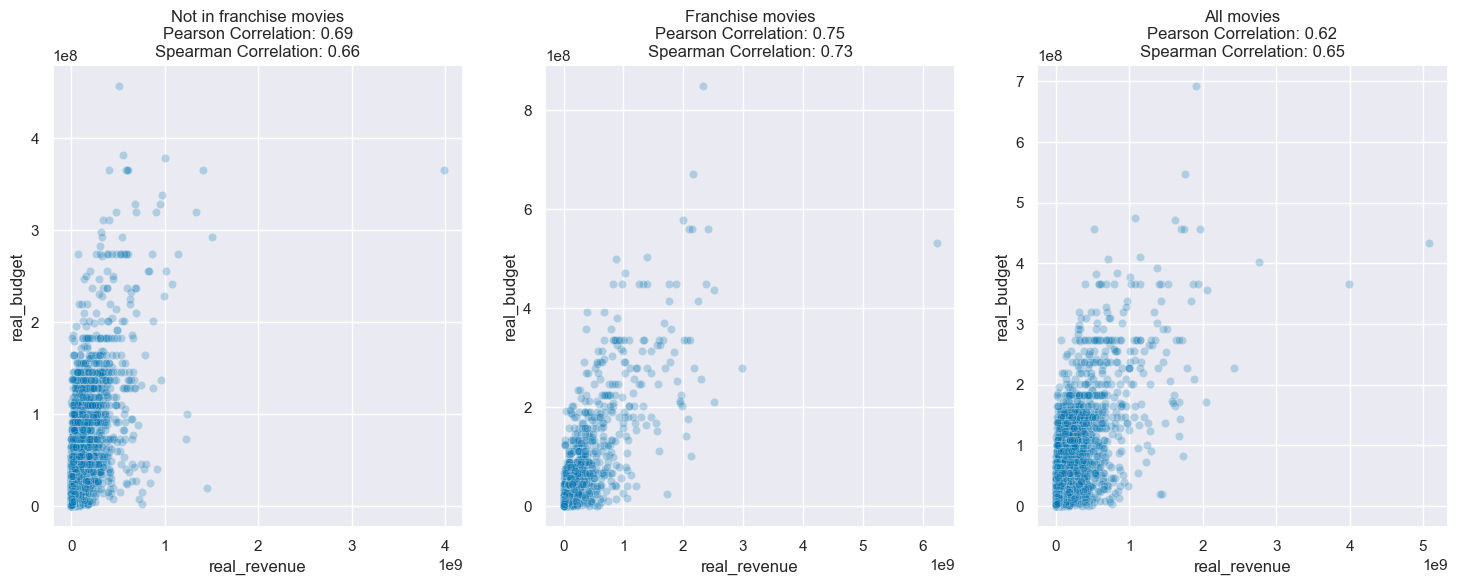

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
 
# scatter plot of the real budget and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget',data=movies_no_franchise_revenue,alpha=.25, ax=axes[0])

# scatter plot of the real revenue and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget', data=franchise_revenue,alpha=.25, ax=axes[1])

# scatter plot of the real profit and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget', data=movies_revenue,alpha=.25, ax=axes[2])
# Calculate Pearson correlation

pearson_corr_df = pd.DataFrame({
    'Movies': ['All Movies', 'Franchise Movies', 'Non-Franchise Movies'],
    'Pearson Correlation': [
        movies_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1],
        franchise_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1],
        movies_no_franchise_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1]
    ]
})

spearman_corr_df = pd.DataFrame({'Movies': ['All Movies', 'Franchise Movies', 'Non-Franchise Movies'],
    'Pearson Correlation': [
        movies_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1],
        franchise_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1],
        movies_no_franchise_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1]
    ]
})

axes[0].set_title(f'Not in franchise movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[0,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[0,1]:.2f}')
axes[1].set_title(f'Franchise movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[1,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[1,1]:.2f}')
axes[2].set_title(f'All movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[2,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[2,1]:.2f}');


### Genre \& revenue

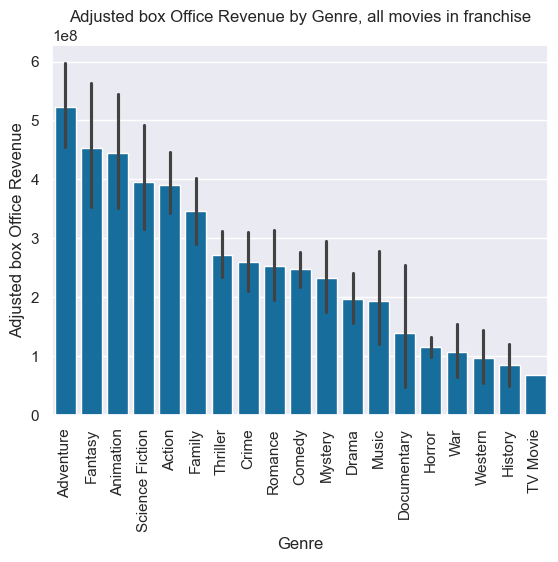

In [29]:
# Explode the genres column so that each genre gets its own row
exploded_df = franchise_df.explode('genres').reset_index(drop=True).sort_values(by='real_revenue', ascending=False)
# Sort the genres by their average revenue
genre_revenue = exploded_df.groupby('genres')['real_revenue'].mean().sort_values(ascending=False).index
exploded_df['genres'] = pd.Categorical(exploded_df['genres'], categories=genre_revenue, ordered=True)
ax = sns.barplot(x="genres", y="real_revenue", data=exploded_df)
plt.ylabel('Adjusted box Office Revenue')
plt.xlabel('Genre')
plt.title('Adjusted box Office Revenue by Genre, all movies in franchise')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()
#print(exploded_df.groupby('genres')['real_revenue'].describe())

We see that Adventure, Fantasy, and Animation are the highest-grossing genres for franchise movies.

NB : If a category doesn't have a barplot, it means that there is no data. Lack of error bars means only one movie is in that category.

Now, let's look at the profit, between the first and the second movie :

7985


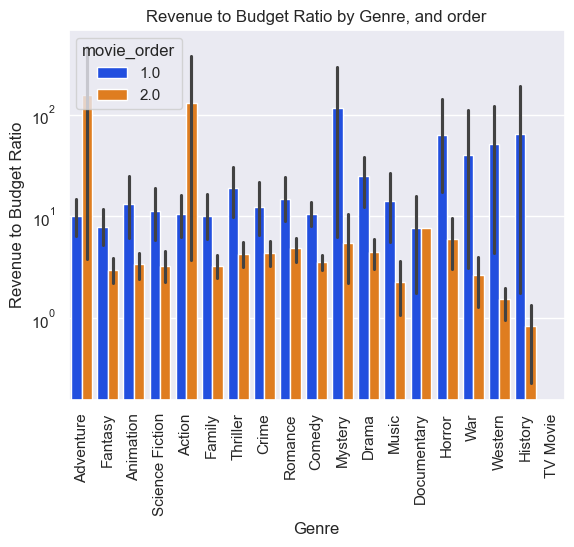

First movies :
                     Movie name    genres  ratio_revenue_budget
8871   The Blair Witch Project    Horror           4143.984983
8872   The Blair Witch Project   Mystery           4143.984983
10229      Paranormal Activity   Mystery            899.329302
10228      Paranormal Activity    Horror            899.329302
3        The Birth of a Nation     Drama            500.000000
5        The Birth of a Nation       War            500.000000
4        The Birth of a Nation   History            500.000000
1624                Open Water     Drama            420.522723
1626                Open Water    Horror            420.522723
1625                Open Water  Thriller            420.522723 
 Second movies :
                   Movie name     genres  ratio_revenue_budget
7663             Kickboxer 2  Adventure          14052.943820
7662             Kickboxer 2     Action          14052.943820
182         Dawn of the Dead     Horror             84.615385
11079  Paranormal Activi

In [30]:
f_and_s = exploded_df[exploded_df['movie_order'].isin([1.0, 2.0])] # First and second movies in each collection
print(len(f_and_s))
ax = sns.barplot(x="genres", y="ratio_revenue_budget", data=f_and_s.sort_values(by='ratio_revenue_budget', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Revenue to Budget Ratio')
plt.xlabel('Genre')
plt.title('Revenue to Budget Ratio by Genre, and order')
plt.yscale('log')  # Logarithmic scale for better readability
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Keep first and second movies separately
high_ratio_second_movies = f_and_s[(f_and_s['movie_order'] == 2)].sort_values(by='ratio_revenue_budget', ascending=False)
high_ratio_first_movies = f_and_s[(f_and_s['movie_order'] == 1)].sort_values(by='ratio_revenue_budget', ascending=False)

# Print the filtered DataFrame
print("First movies :\n", high_ratio_first_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10), "\n Second movies :\n", high_ratio_second_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10))

Action and adventure movies have higher revenue/budget ratio in second movie vs in first, but very high error bars: we decided to look at the eventual outliers, and found notably kickboxer 2. We notice that it is the only one of the kickboxers to have the ratio data: we therefore decided to filter out the movies that are the only ones to have the money information from their collection.

1409


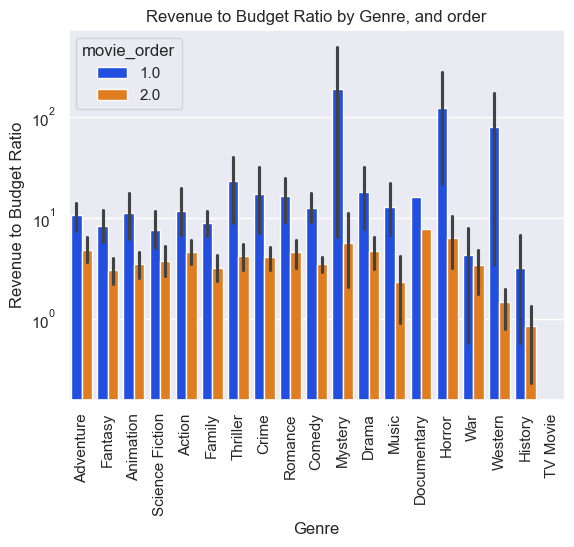

First movies :
                      Movie name    genres  ratio_revenue_budget
8872    The Blair Witch Project   Mystery           4143.984983
8871    The Blair Witch Project    Horror           4143.984983
10228       Paranormal Activity    Horror            899.329302
10229       Paranormal Activity   Mystery            899.329302
91     Night of the Living Dead    Horror            368.421053
92     Night of the Living Dead  Thriller            368.421053
736                 El Mariachi  Thriller            282.480277
734                 El Mariachi    Action            282.480277
735                 El Mariachi     Crime            282.480277
737                 El Mariachi   Western            282.480277 
 Second movies :
                                          Movie name     genres  \
182                                Dawn of the Dead     Horror   
11079                         Paranormal Activity 2    Mystery   
11078                         Paranormal Activity 2     Horror 

In [31]:
f_and_s_filtered = f_and_s.groupby('collection_id').filter(lambda x: x['ratio_revenue_budget'].notna().all())
print(len(f_and_s_filtered))
ax = sns.barplot(x="genres", y="ratio_revenue_budget", data=f_and_s_filtered.sort_values(by='ratio_revenue_budget', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Revenue to Budget Ratio')
plt.xlabel('Genre')
plt.title('Revenue to Budget Ratio by Genre, and order')
plt.yscale('log')  # Logarithmic scale for better readability
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Filter the second movies with higher ratio_revenue_budget
high_ratio_second_movies = f_and_s_filtered[(f_and_s_filtered['movie_order'] == 2)].sort_values(by='ratio_revenue_budget', ascending=False)
high_ratio_first_movies = f_and_s_filtered[(f_and_s_filtered['movie_order'] == 1)].sort_values(by='ratio_revenue_budget', ascending=False)

# Print the filtered DataFrame
print("First movies :\n", high_ratio_first_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10), "\n Second movies :\n", high_ratio_second_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10))

After that, we see that the first movie works a lot better than the second, for every category. We still have around 1500 movies, which is still good. And if we look at the box-office performance only ?

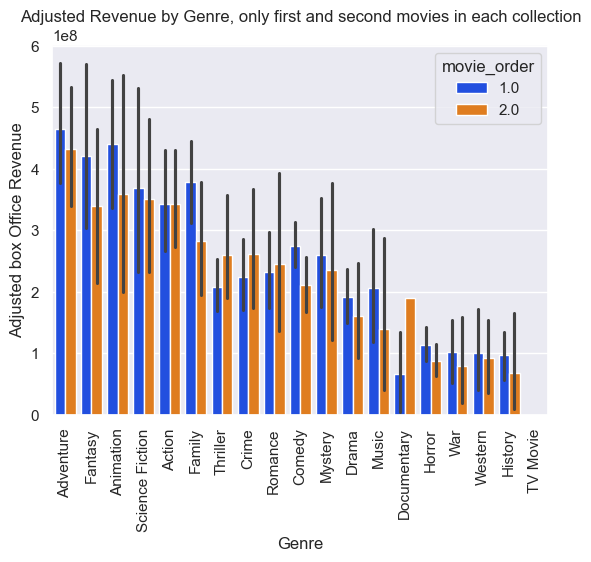

1409


In [32]:
# Sort the genres by their average revenue
genre_revenue = f_and_s_filtered.groupby('genres')['real_revenue'].mean().sort_values(ascending=False).index
f_and_s_filtered['genres'] = pd.Categorical(f_and_s_filtered['genres'], categories=genre_revenue, ordered=True)
ax = sns.barplot(x="genres", y="real_revenue", data=f_and_s, hue='movie_order', palette='bright')
plt.ylabel('Adjusted box Office Revenue')
plt.xlabel('Genre')
plt.title('Adjusted Revenue by Genre, only first and second movies in each collection')
plt.xticks(rotation=90)
plt.show()
print(len(f_and_s_filtered))

Except for thrillers, Crime, Romance and Documentaries, the first movie performs on average better than the second. Nonetheless, they were still less profitable than the first movies.

And just to be sure, let's look at the first plot again, but with the filtered data:

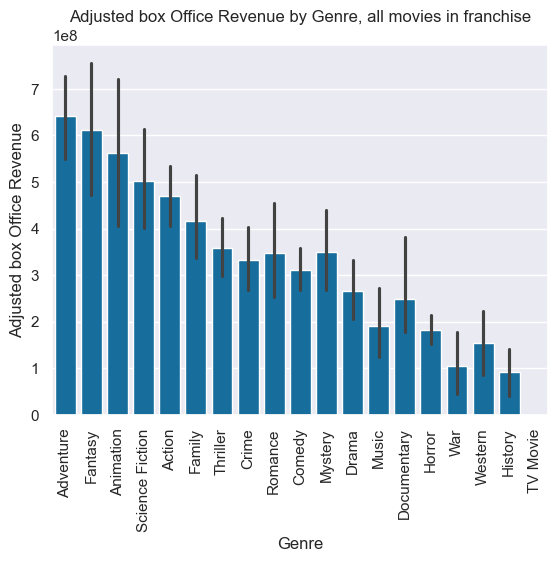

In [33]:
# Sort the genres by their average revenue
exploded_filtered = exploded_df.groupby('collection_id').filter(lambda x: x['real_revenue'].notna().all())
# Sort the genres by their average revenue
genre_revenue = exploded_filtered.groupby('genres')['real_revenue'].mean().sort_values(ascending=False).index
exploded_filtered['genres'] = pd.Categorical(exploded_filtered['genres'], categories=genre_revenue, ordered=True)
ax = sns.barplot(x="genres", y="real_revenue", data=exploded_filtered)
plt.ylabel('Adjusted box Office Revenue')
plt.xlabel('Genre')
plt.title('Adjusted box Office Revenue by Genre, all movies in franchise')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

We see that the 8 highest-grossing genres for the entire collections are still the same !

### Genre \& movie order

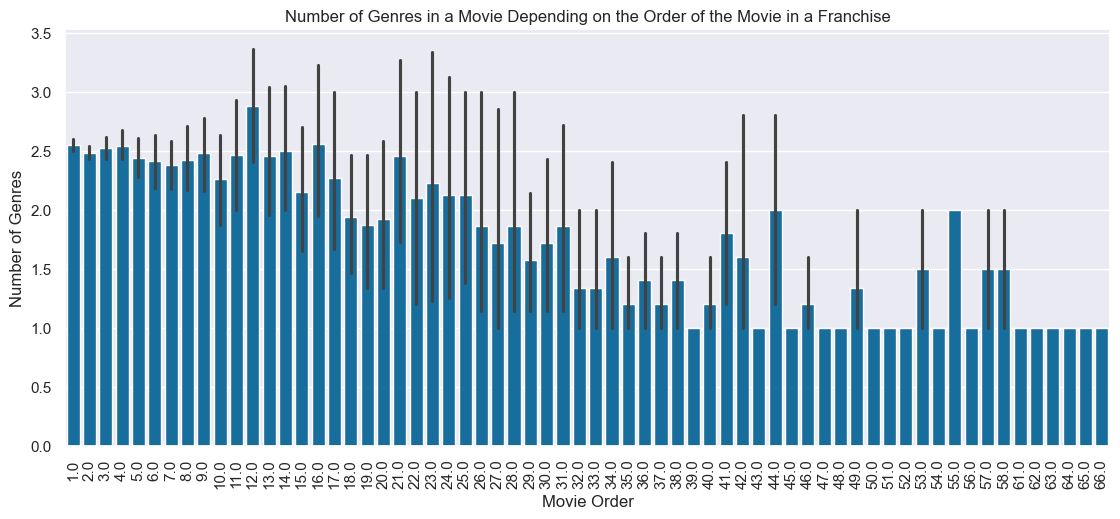

In [34]:
# Create a bar plot of the number of genres depending on the order of the movie in a franchise
drop_no_genre = franchise_df[franchise_df['num_genres'] > 0]
plt.figure(figsize=(12, 6))
sns.barplot(x='movie_order', y='num_genres', data=drop_no_genre)

# Add labels and title
plt.xlabel('Movie Order')
plt.ylabel('Number of Genres')
plt.title('Number of Genres in a Movie Depending on the Order of the Movie in a Franchise')
# Rotate bar x-axis labels plot for better readability
plt.xticks(rotation=90)
# Adjust layout to add padding
plt.tight_layout(pad=3.0)

# Show the plot
plt.show();

We know that 75% of the franchises have between 2 and 4 movies, and here we can see that for these franchises, and for the first movies of longer franchises, the number of genres does not seem to change much. Maybe they switched though ? 
And for longer franchises, we see that the number of genres seems to decrease, and oscillate quite weirdly.
Now, let's see if the genres change between two consecutive movies

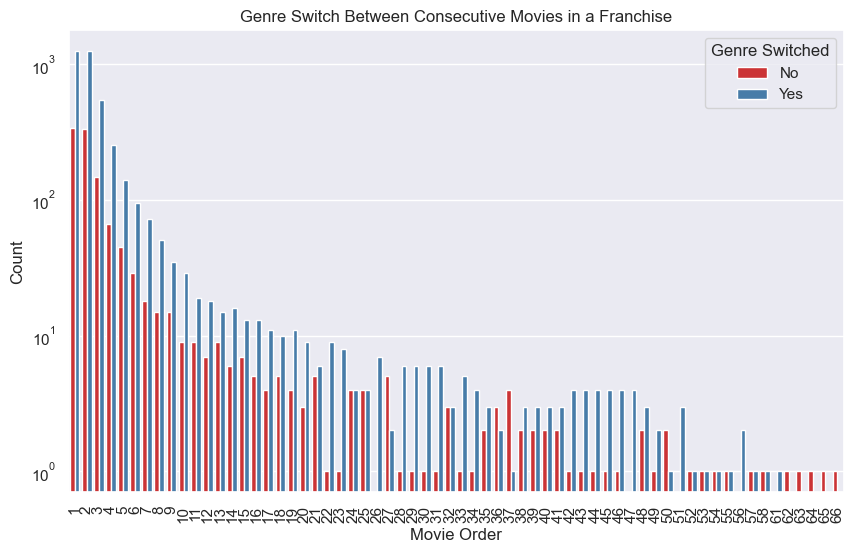

In [35]:
# Reset the index of the DataFrame
drop_no_genre = drop_no_genre.reset_index(drop=True)

# Create a new column to indicate if the genre switched between two movies in a franchise
drop_no_genre['genre_switched'] = drop_no_genre.groupby('collection_id')['genres'].apply(lambda x: x != x.shift()).reset_index(drop=True)

# Plot for every movie in the franchise
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='movie_order', hue='genre_switched', data=drop_no_genre[['movie_order', 'genre_switched']].astype(int), palette='Set1', ax=ax)
ax.set_xlabel('Movie Order')
ax.set_ylabel('Count')
ax.set_title('Genre Switch Between Consecutive Movies in a Franchise')
ax.legend(title='Genre Switched', labels=['No', 'Yes'])
ax.set_yscale('log')
# Ensure x-axis labels are integers
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

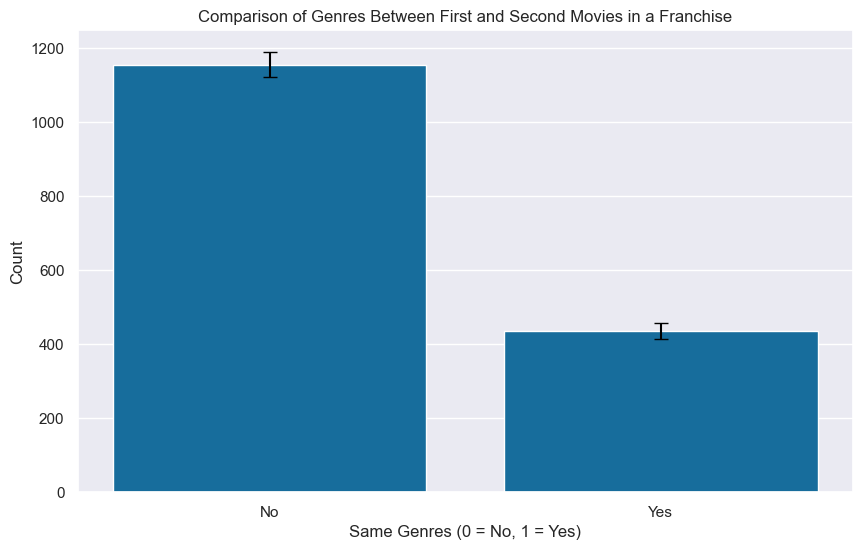

movie_order                                      1.0  \
collection_id                                          
10.0            [Adventure, Action, Science Fiction]   
84.0                             [Adventure, Action]   
119.0                   [Adventure, Fantasy, Action]   
131.0                                        [Drama]   
151.0          [Science Fiction, Adventure, Mystery]   
...                                              ...   
1368193.0                           [Family, Comedy]   
1377494.0                             [Crime, Drama]   
1379724.0                  [Drama, Horror, Thriller]   
1380844.0                      [War, Drama, History]   
1382526.0                   [Comedy, Drama, Romance]   

movie_order                                               2.0  same_genres  
collection_id                                                               
10.0                     [Adventure, Action, Science Fiction]         True  
84.0                                    

In [ ]:
# Filter the DataFrame to include only the first and second movies in each franchise
first_and_second_movies = drop_no_genre[drop_no_genre['movie_order'].isin([1, 2])]

# Pivot the DataFrame to have one row per franchise and columns for the genres of the first and second movies
pivot_df = first_and_second_movies.pivot(index='collection_id', columns='movie_order', values='genres')

# Create a new column to indicate if the genres are the same between the first and second movies
pivot_df['same_genres'] = pivot_df[1] == pivot_df[2]

# Plot the comparison
fig, ax = plt.subplots(figsize=(10, 6))
# Calculate the error bars
error_bars = pivot_df['same_genres'].astype(int).value_counts().apply(lambda x: np.sqrt(x))

# Plot with error bars
sns.countplot(x=pivot_df['same_genres'].astype(int), ax=ax)
ax.errorbar(x=[0, 1], y=pivot_df['same_genres'].astype(int).value_counts(), yerr=error_bars, fmt='none', c='black', capsize=5)
ax.set_xlabel('Same Genres (0 = No, 1 = Yes)')
ax.set_ylabel('Count')
ax.set_title('Comparison of Genres Between First and Second Movies in a Franchise')
ax.set_xticklabels(['No', 'Yes'])

plt.show()

ajouter ça si possible dans une lin reg / trees etc, mais attention ! certains films ont 0 genres, mais n'ont pas le ratio non plus !
j'ai ajouté dans utils !

#### Average revenue of a franchise and length of a franchise, frequency and number of movie 

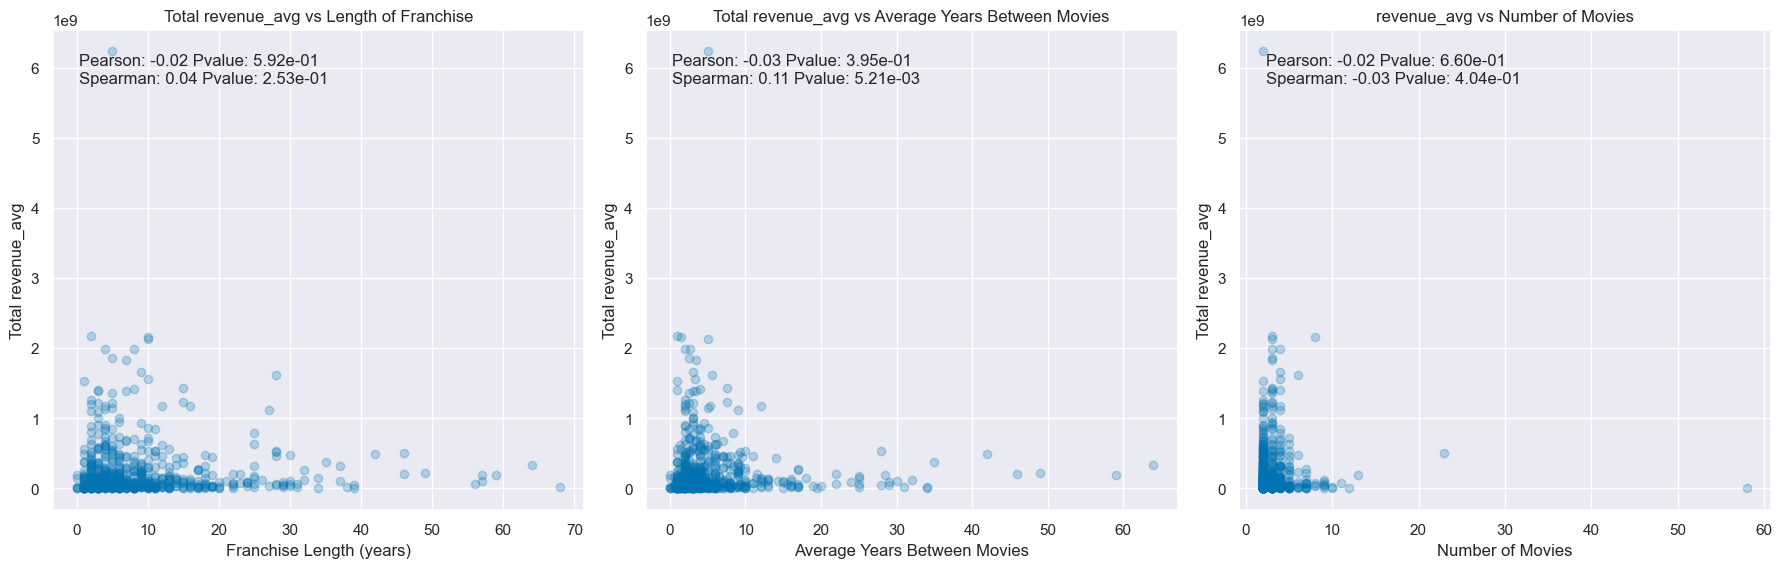

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot of total revenue_avg vs length of a franchise
axes[0].scatter(franchise_data_df['franchise_length_years'], franchise_data_df['revenue_avg'], alpha=0.25)
axes[0].set_title('Total revenue_avg vs Length of Franchise')
axes[0].set_xlabel('Franchise Length (years)')
axes[0].set_ylabel('Total revenue_avg')


# Scatter plot of total revenue_avg vs average years between movies
axes[1].scatter(franchise_data_df['average_years_bt_movies'], franchise_data_df['revenue_avg'], alpha=0.25)
axes[1].set_title('Total revenue_avg vs Average Years Between Movies')
axes[1].set_xlabel('Average Years Between Movies')
axes[1].set_ylabel('Total revenue_avg')


# Scatter plot of total revenue_avg vs number of movies in the franchise
axes[2].scatter(franchise_data_df['movie_count'], franchise_data_df['revenue_avg'], alpha=0.25)
axes[2].set_title('revenue_avg vs Number of Movies')
axes[2].set_xlabel('Number of Movies')
axes[2].set_ylabel('Total revenue_avg')

plt.tight_layout()

# Calculate Pearson and Spearman correlations
pearson_corr_length = stats.pearsonr(franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['franchise_length_years'],franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['revenue_avg'])
spearman_corr_length = stats.spearmanr(franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['franchise_length_years'],franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['revenue_avg'])

pearson_corr_average = stats.pearsonr(franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['average_years_bt_movies'],franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['revenue_avg'])
spearman_corr_average = stats.spearmanr(franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['average_years_bt_movies'],franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['revenue_avg'])

pearson_corr_count = stats.pearsonr(franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['movie_count'],franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['revenue_avg'])
spearman_corr_count = stats.spearmanr(franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['movie_count'],franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['revenue_avg'])


# Add correlation text to the plots
axes[0].text(0.05, 0.95, f'Pearson: {pearson_corr_length.statistic:.2f} Pvalue: {pearson_corr_length.pvalue:.2e}\nSpearman: {spearman_corr_length.statistic:.2f} Pvalue: {spearman_corr_length.pvalue:.2e}', 
             transform=axes[0].transAxes, verticalalignment='top')

axes[1].text(0.05, 0.95, f'Pearson: {pearson_corr_average.statistic:.2f} Pvalue: {pearson_corr_average.pvalue:.2e}\nSpearman: {spearman_corr_average.statistic:.2f} Pvalue: {spearman_corr_average.pvalue:.2e}',
             transform=axes[1].transAxes, verticalalignment='top')

axes[2].text(0.05, 0.95, f'Pearson: {pearson_corr_count.statistic:.2f} Pvalue: {pearson_corr_count.pvalue:.2e}\nSpearman: {spearman_corr_count.statistic:.2f} Pvalue: {spearman_corr_count.pvalue:.2e}',
             transform=axes[2].transAxes, verticalalignment='top')

plt.show()

We don't observe a significant correlation, but there seems to be a range where the high budget movies lies in.

#### Box office of a movie and the average vote of a movie vs the year difference between the movies

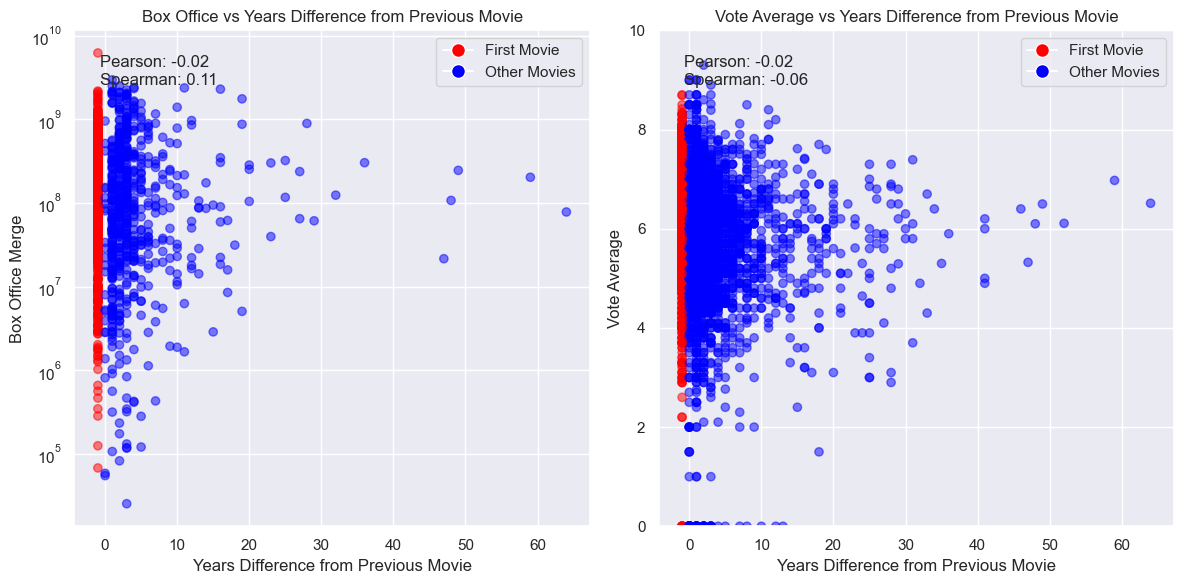

In [38]:
# Create a copy of the franchise data since modification will be made
franchise_df_temp = franchise_df.copy()

# Replace NaN values in 'years_diff_bt_pre_movies' with -1
franchise_df_temp['years_diff_bt_pre_movies'].fillna(-1, inplace=True)

# Create a color map for the scatter plot
colors = franchise_df_temp['years_diff_bt_pre_movies'].apply(lambda x: 'red' if x == -1 else 'blue')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of years difference vs box office merge
axes[0].scatter(franchise_df_temp['years_diff_bt_pre_movies'], franchise_df_temp['real_revenue'], c=colors, alpha=0.5)
axes[0].set_title('Box Office vs Years Difference from Previous Movie')
axes[0].set_xlabel('Years Difference from Previous Movie')
axes[0].set_ylabel('Box Office Merge')
axes[0].set_yscale('log')

# Scatter plot of years difference vs vote average
axes[1].scatter(franchise_df_temp['years_diff_bt_pre_movies'], franchise_df_temp['vote_average'], c=colors, alpha=0.5)
axes[1].set_title('Vote Average vs Years Difference from Previous Movie')
axes[1].set_xlabel('Years Difference from Previous Movie')
axes[1].set_ylabel('Vote Average')
axes[1].set_ylim(0, 10)

# Add legend to the plot
first_movie_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='First Movie')
other_movies_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Other Movies')
axes[0].legend(handles=[first_movie_patch, other_movies_patch], loc='upper right')
axes[1].legend(handles=[first_movie_patch, other_movies_patch], loc='upper right')

plt.tight_layout()

# Filter out rows where 'years_diff_bt_pre_movies' is -1
filtered_franchise_df_temp = franchise_df_temp[franchise_df_temp['years_diff_bt_pre_movies'] != -1]

# Calculate Pearson and Spearman correlations
pearson_corr_years_diff_box_office = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'real_revenue']].corr(method='pearson').iloc[0, 1]
spearman_corr_years_diff_box_office = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'real_revenue']].corr(method='spearman').iloc[0, 1]

pearson_corr_years_diff_vote_average = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'vote_average']].corr(method='pearson').iloc[0, 1]
spearman_corr_years_diff_vote_average = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'vote_average']].corr(method='spearman').iloc[0, 1]

# Add correlation text to the plots
axes[0].text(0.05, 0.95, f'Pearson: {pearson_corr_years_diff_box_office:.2f}\nSpearman: {spearman_corr_years_diff_box_office:.2f}', 
             transform=axes[0].transAxes, verticalalignment='top')

axes[1].text(0.05, 0.95, f'Pearson: {pearson_corr_years_diff_vote_average:.2f}\nSpearman: {spearman_corr_years_diff_vote_average:.2f}', 
             transform=axes[1].transAxes, verticalalignment='top')

plt.show()


Note that the first movies were assigned the value -1 to differentiate them from the rest of the movies but still have them on the plot (they are not taking into account for the correlation). We observe no significant correlation for both 

### Budget/revenue & vote

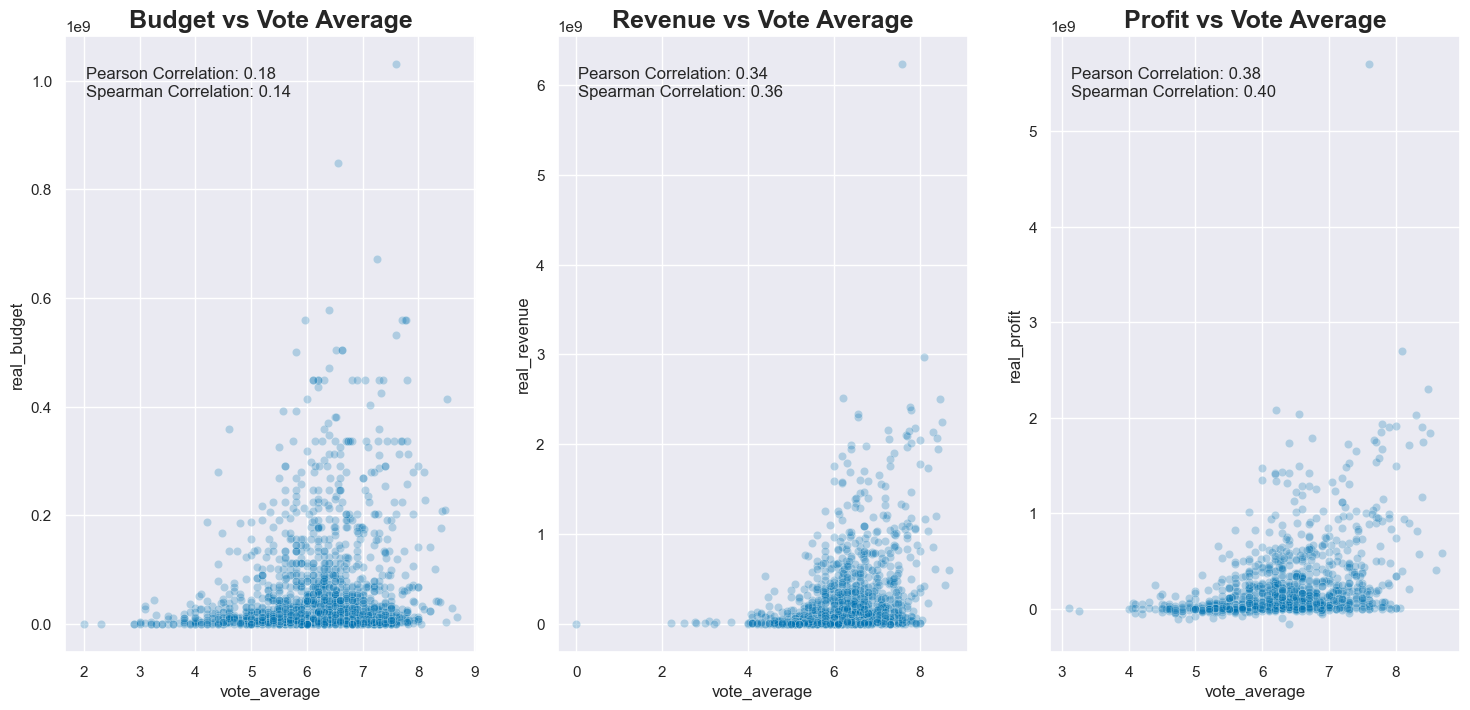

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
 
# scatter plot of the real budget and vote average
sns.scatterplot(x='vote_average', y='real_budget', data=franchise_df,alpha=.25, ax=axes[0])

# scatter plot of the real revenue and vote average
sns.scatterplot(x='vote_average', y='real_revenue', data=franchise_df,alpha=.25, ax=axes[1])

# scatter plot of the real profit and vote average
sns.scatterplot(x='vote_average', y='real_profit', data=franchise_df,alpha=.25, ax=axes[2])

# Calculate the person and spearmann correlation
person_corr = franchise_df[['vote_average','real_budget','real_revenue', 'real_profit']].corr(method='pearson')
spearman_corr = franchise_df[['vote_average','real_budget','real_revenue', 'real_profit']].corr(method='spearman')

axes[0].set_title('Budget vs Vote Average',fontsize=18,fontweight='bold')
axes[1].set_title('Revenue vs Vote Average',fontsize=18,fontweight='bold')
axes[2].set_title('Profit vs Vote Average',fontsize=18,fontweight='bold')

axes[0].text(0.05, 0.95,f'Pearson Correlation: {person_corr.iloc[0,1]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,1]:.2f}',transform=axes[0].transAxes, verticalalignment='top')
axes[1].text(0.05, 0.95,f'Pearson Correlation: {person_corr.iloc[0,2]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,2]:.2f}',transform=axes[1].transAxes, verticalalignment='top')
axes[2].text(0.05, 0.95,f'Pearson Correlation: {person_corr.iloc[0,3]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,3]:.2f}',transform=axes[2].transAxes, verticalalignment='top')
plt.show()

Here, we see that the profit has the highest linear relationship with the vote !

## Shapley value analysis: what is the recipe for franchise movies?

In [40]:
tree_df = get_tree_df(franchise_df, movies_no_franchise_df, RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(tree_df.drop(columns=["in_franchise"]), tree_df["in_franchise"], test_size=0.3)
clf = HistGradientBoostingClassifier(max_iter=100, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
print("Test accuracy:", clf.score(X_test, y_test))

Test accuracy: 0.8211297071129707


In [41]:
#run_importance(clf, X_train, X_test, y_test, target_name="in_franchise", save_dir="data/shapley_result", random_state=RANDOM_STATE)

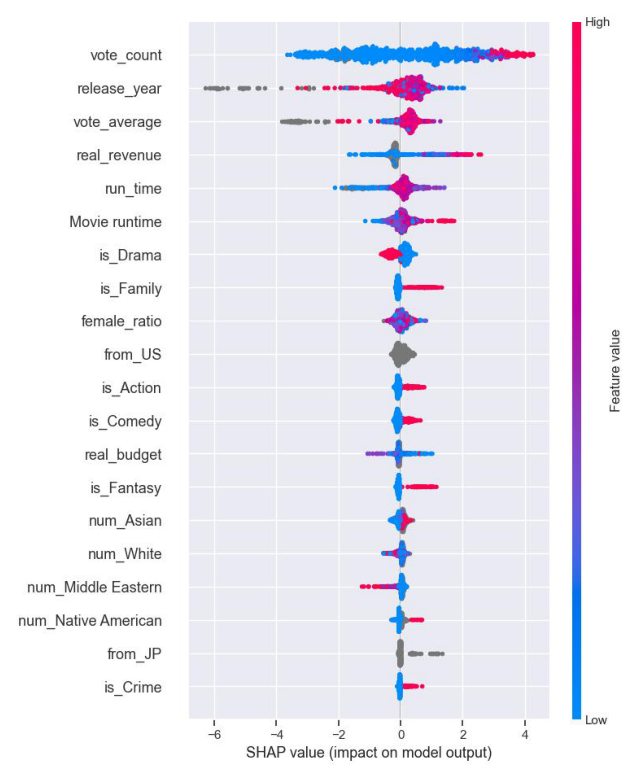

In [42]:
shap_plot = plt.imread("data/shapley_result/shap_summary_plot_in_franchise.jpg")
plt.figure(figsize=(8,10))  # Set the plot size
plt.imshow(shap_plot)
plt.axis('off')  # Hide the axis
plt.show()

# Franchise successfulness and pattern investigation

In order to find the underlying pattern in franchises (has a group of movies and not has movies in a franchise), we've used different characteristics of a franchise such has its length, the number of movies in it, the average years between the movies, the average revenue, the average budget, genre that appears in the franchise and country that are link to the franchise.

After trying to find correlation between those different characteristic and having difficulties observing patterns we're going to try a new approach to better understand the franchise dataset.

Since the franchise we have in the dataset can defer a lot from one to another, an idea to go deeper into our analysis is to try to group franchise that have features close to one another. Using the hypothesis that if franchises have features that are similar they would behave the same, then looking at those features we might be able to find interesting pattern.

To group the feature a K nearest neighbors (KNN) was used to the fit the data.

## KNN regression of franchise that have both a average revenue and a average budget

The revenue and budget of a franchise was calculated using the known values of movies in the franchise and was average on the number of movies that had a value. This was done in order to maximize the number of franchise for the analysis, but it can create a bias since its assuming that movies that don't have values must have had a similar revenue and budget.

/var/folders/pk/zbd7z2k51w5_w89mv7brxxzm0000gn/T/ipykernel_72272/2613503741.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KNN_data_no_na.loc[:, 'Cluster'] = pd.NA  # Initialize Cluster column with NaN


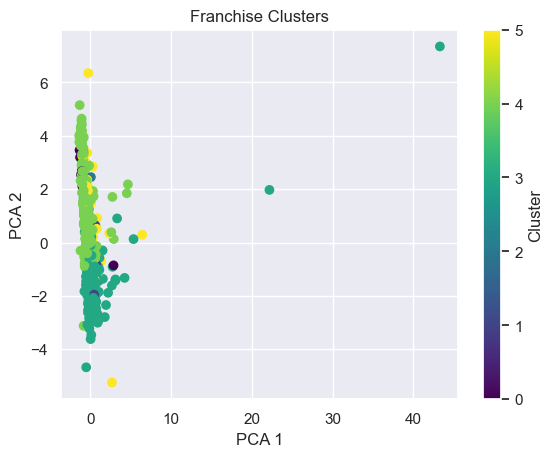

In [43]:
KNN_data = get_franchise_data(franchise_df)
KNN_data_no_na = KNN_data.dropna(subset=['ratio_rb'])

# genre vecotrization
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
genre_matrix = vectorizer.fit_transform(KNN_data['genres'])
genre_df = pd.DataFrame(genre_matrix.toarray(), columns=[f'genre_{col}' for col in vectorizer.get_feature_names_out()])
KNN_data = pd.concat([KNN_data, genre_df], axis=1)

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
country_matrix = vectorizer.fit_transform(KNN_data['country'])
country_df = pd.DataFrame(country_matrix.toarray(), columns=[f'country_{col}' for col in vectorizer.get_feature_names_out()])
KNN_data = pd.concat([KNN_data, country_df], axis=1)

# Separate the franchise with a ratio of revenue over budget and the ones that don't
KNN_data_no_na = KNN_data.dropna(subset=['ratio_rb'])
KNN_data_na = KNN_data[KNN_data['ratio_rb'].isna()]

# Load and preprocess dat
data = KNN_data_no_na.drop(columns=['collection_id','collection_name','genres','oldest_release','newest_release','franchise_length','country','region'])


scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply K-Means
kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE)
clusters = kmeans.fit_predict(scaled_data)

# Assign clusters back to franchise_data_df
KNN_data_no_na.loc[:, 'Cluster'] = pd.NA  # Initialize Cluster column with NaN
KNN_data_no_na.loc[data.index, 'Cluster'] = clusters

    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('Franchise Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

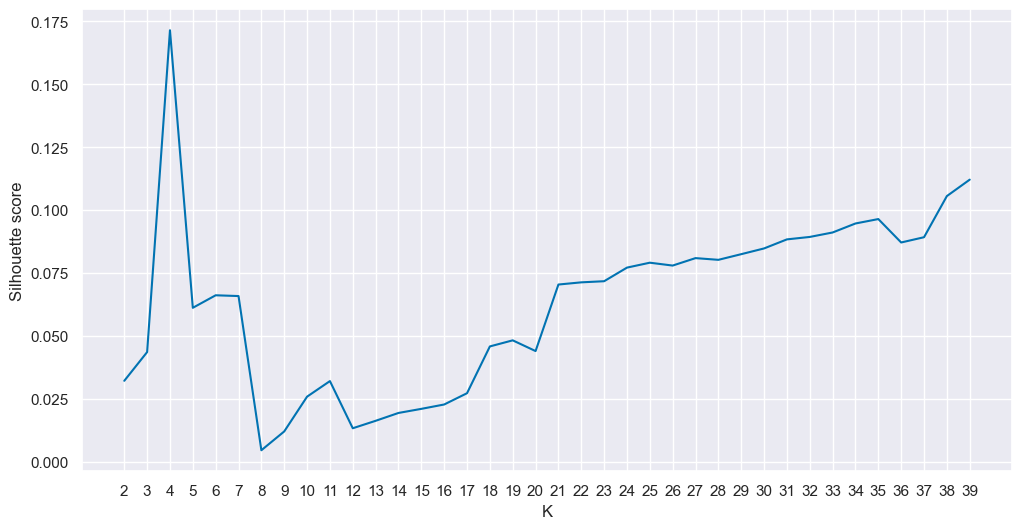

In [44]:
from sklearn.metrics import silhouette_score
silhouettes = []

# Try multiple k
for k in range(2, 40):
    # Cluster the data and assigne the labels
    clusters = KMeans(n_clusters=k, random_state=42,n_init='auto').fit_predict(scaled_data)
    # Get the Silhouette score
    score = silhouette_score(scaled_data, clusters)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.xticks(range(2, 40))
plt.show()

### Visualization of what the cluster looks like

Franchise of the cluster of less than 10 movies:
     Cluster                          collection_name
1294       1                         Laughing Gor（系列）
30         1  Teenage Mutant Ninja Turtles Collection
898        1                     Overheard Collection
595        1              The Storm Riders Collection
228        1                 Shanghai Noon Collection
238        1                        Ip Man Collection
388        1                Cannonball Run Collection
986        1                   Sex And Zen Collection
316        1                     Rush Hour Collection
663        2                   The Howling Collection
2          2         The Lord of the Rings Collection
273        2               Fortress (1992) Collection
83         2              Crocodile Dundee Collection
76         2                       Mad Max Collection
40         2                    Underworld Collection
356        2                     Boogeyman Collection
312        2      The Man From Sn

KeyboardInterrupt: 

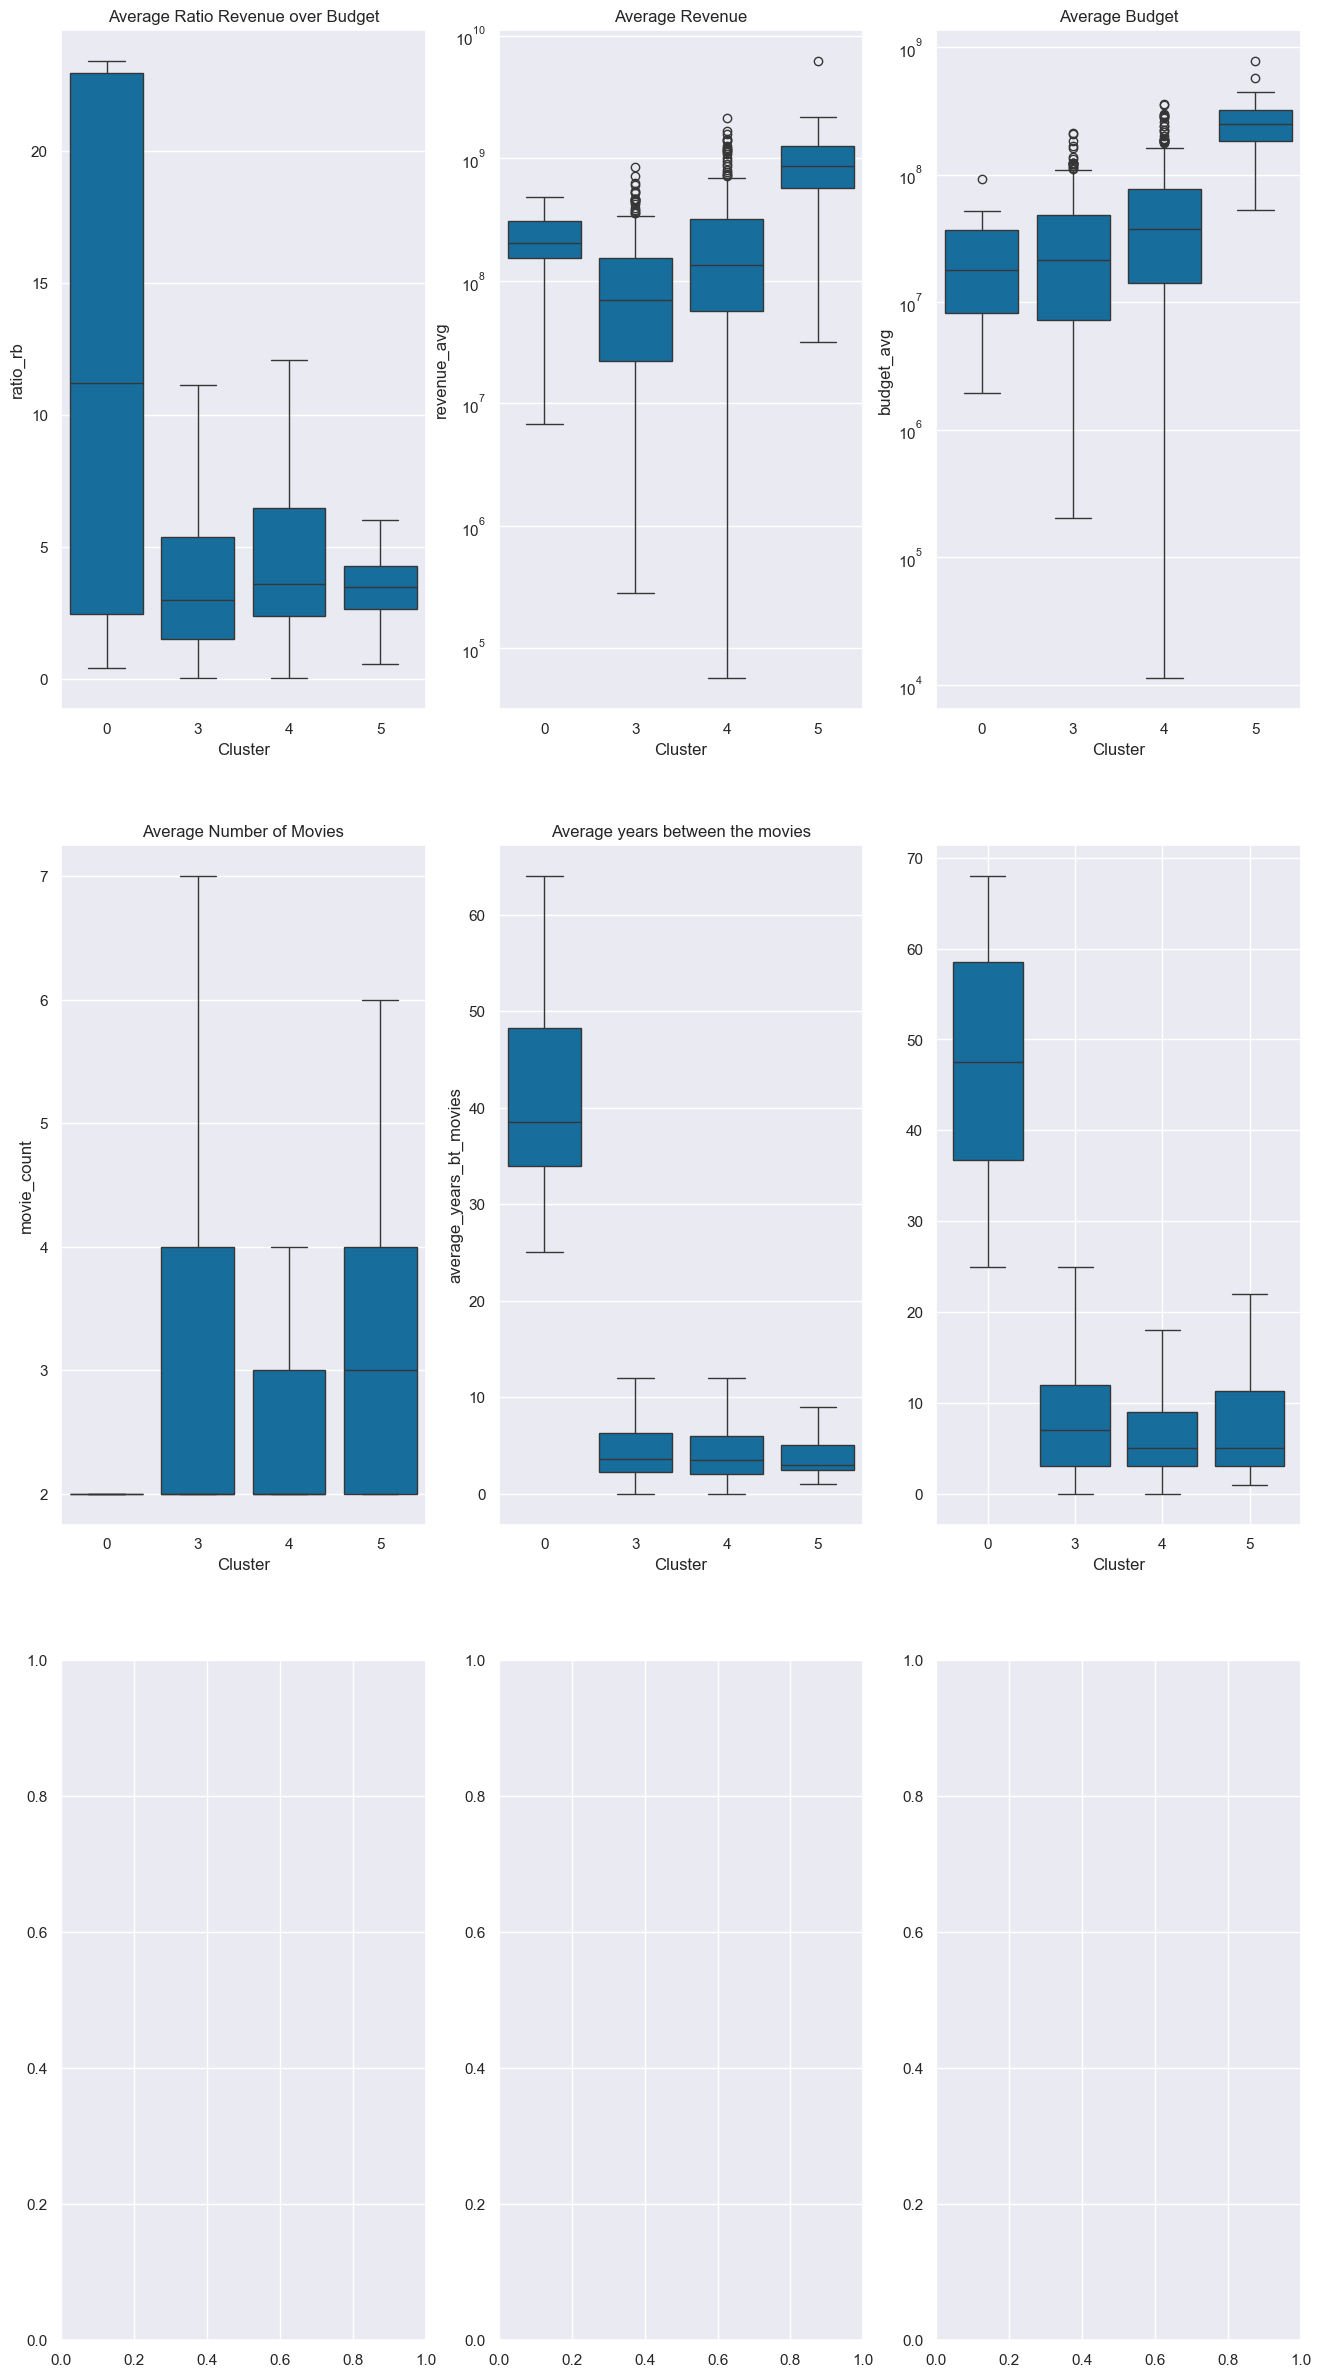

In [45]:
# Drop the cluster with less than 10 franchises idk if it is necessary
KNN_data_filt = KNN_data_no_na.groupby('Cluster').filter(lambda x: len(x) >= 10)


# Print the small cluster
print("Franchise of the cluster of less than 10 movies:")
print(KNN_data_no_na[~KNN_data_no_na['Cluster'].isin(KNN_data_no_na.groupby('Cluster').filter(lambda x: len(x) >= 10)['Cluster'])][['Cluster','collection_name']].sort_values(by='Cluster'))


fig, axs = plt.subplots(3, 3, figsize=(16, 30))


sns.boxplot(x='Cluster', y='ratio_rb', data=KNN_data_filt,showfliers=False, ax=axs[0,0])
axs[0,0].set_title('Average Ratio Revenue over Budget')
sns.boxplot(x='Cluster', y='revenue_avg', data=KNN_data_filt, ax=axs[0,1])
axs[0,1].set_title('Average Revenue')
axs[0,1].set_yscale('log')

sns.boxplot(x='Cluster', y='budget_avg', data=KNN_data_filt, ax=axs[0,2])
axs[0,2].set_title('Average Budget')
axs[0,2].set_yscale('log')

sns.boxplot(x='Cluster', y='movie_count', data=KNN_data_filt,showfliers=False, ax=axs[1,0])
axs[1,0].set_title('Average Number of Movies')
sns.boxplot(x='Cluster', y='average_years_bt_movies', data=KNN_data_filt,showfliers=False, ax=axs[1,1])
axs[1,1].set_title('Average years between the movies')


sns.boxplot(x='Cluster', y='franchise_length_years', data=KNN_data_filt,showfliers=False, ax=axs[1,2])
axs[1,2].set_title('Average Franchise Length (Years)')
sns.barplot(x=KNN_data_no_na['Cluster'].value_counts().index, y=KNN_data_no_na['Cluster'].value_counts().values, ax=axs[2,0])
axs[2,0].set_title('Number of Franchises per Cluster')
sns.boxplot(x='Cluster', y='runtime_avg', data=KNN_data_filt, ax=axs[2,1])
axs[2,1].set_title('Average Runtime')
sns.boxplot(x='Cluster', y='average_score', data=KNN_data_filt, ax=axs[2,2])
axs[2,2].set_title('Average Score')
axs[2,2].set_ylim(0, 10)

plt.tight_layout()
plt.show()



By doing different number of cluster we quickly observe that it can pretty easily make 4 clusters with a lot of franchises, the James Bonds' franchise is always alone and there are some other outliers that varies slightly when the number of cluster is increase, but 6 clusters made interesting results, so we're going to stick with that. 

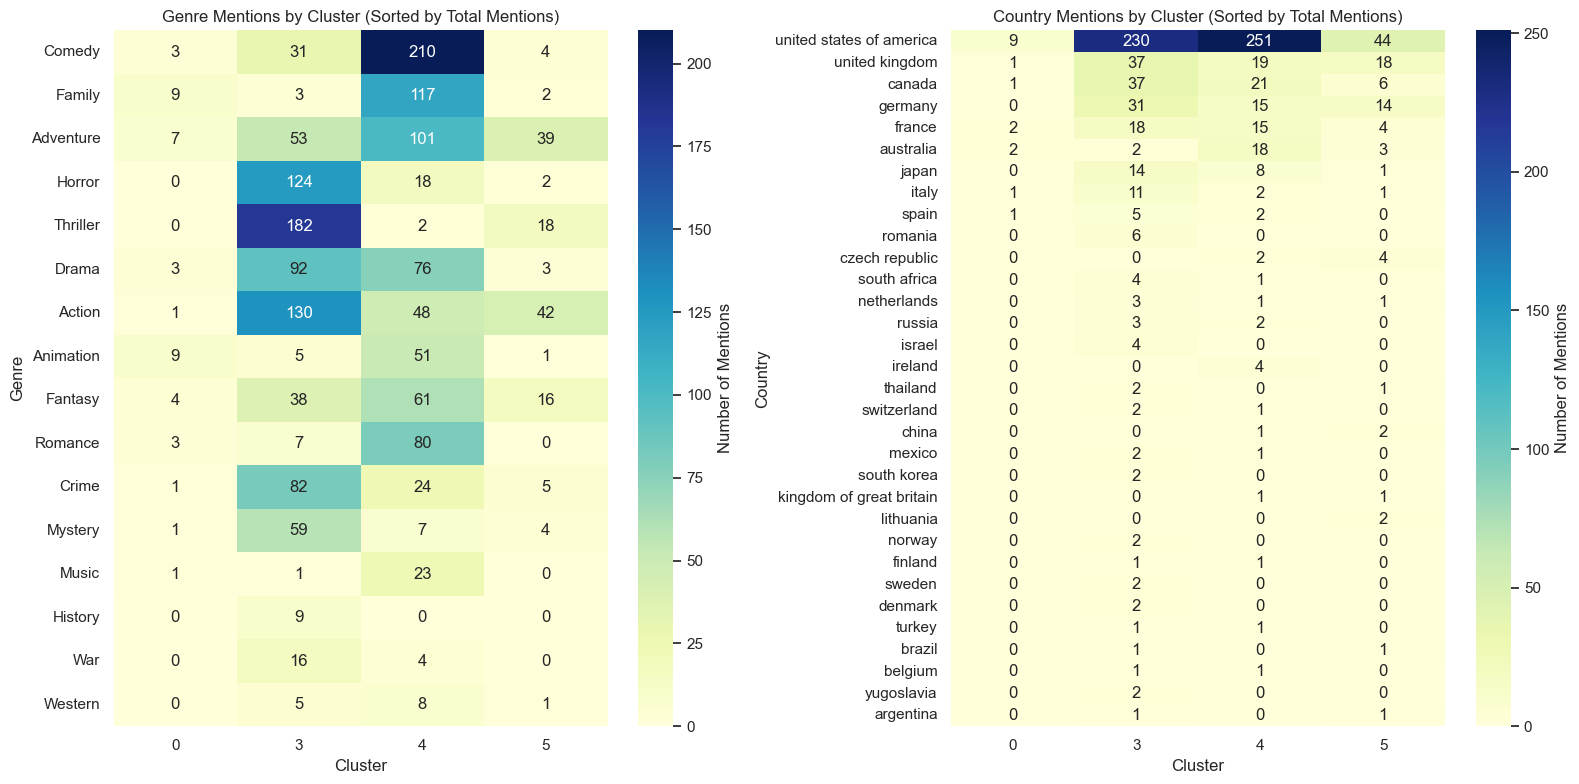

In [47]:
# Summing country mentions by cluster
country_sums = KNN_data_filt.groupby('Cluster')[
    [col for col in KNN_data_filt.columns if col.startswith('country_')]
].sum()

# Remove the 'country_' prefix from the column names
country_sums.columns = country_sums.columns.str.replace('country_', '')

# Sort countries by total mentions (sum across clusters)
country_sums = country_sums.loc[:, country_sums.sum().sort_values(ascending=False).index]
# remove the country that are mentionned only once
country_sums = country_sums.loc[:, country_sums.sum() > 1]


# Summing genre mentions by cluster
genre_sums = KNN_data_filt.groupby('Cluster')[
    [col for col in KNN_data_filt.columns if col.startswith('genre_')]
].sum()

# Remove the 'genre_' prefix from the column names
genre_sums.columns = genre_sums.columns.str.replace('genre_', '')

# put a capital letter at the beginning of the genre
genre_sums.columns = genre_sums.columns.str.capitalize()

# manually sorting the row to make the heatmap more readable
genre_sums = genre_sums.loc[:, ['Comedy', 'Family', 'Adventure', 'Horror', 'Thriller', 'Drama', 'Action', 'Animation', 'Fantasy', 'Romance', 'Crime', 'Mystery', 'Music', 'History', 'War', 'Western']]



# Plot the heatmap
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(
    genre_sums.T, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'},
    ax=axs[0]
)
axs[0].set_title('Genre Mentions by Cluster (Sorted by Total Mentions)')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Genre')

sns.heatmap(
    country_sums.T, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'},
    ax=axs[1]
)
axs[1].set_title('Country Mentions by Cluster (Sorted by Total Mentions)')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Country')
plt.tight_layout()
plt.show()



### Summary by cluster

Cluster 1:

In [48]:
KNN_data_no_na[KNN_data_no_na['Cluster']==0]['collection_name']

218                          Cinderella Collection
219                           Peter Pan Collection
220                            Fantasia Collection
293                               Bambi Collection
361                     The Jungle Book Collection
362                  Lady and the Tramp Collection
380           101 Dalmatians (Animated) Collection
382               The Fox and the Hound Collection
1199                                 Oz Collection
1487    Arsène Lupin (Robert Lamoureux) Collection
Name: collection_name, dtype: object

This cluster is the cluster of the musical, mostly produces by the United States, they have a pretty good ratio of budget over revenues, and they never have more that 3-4 movies.

Cluster 2:

In [49]:
KNN_data_no_na[KNN_data_no_na['Cluster']==1]['collection_name']

30      Teenage Mutant Ninja Turtles Collection
228                    Shanghai Noon Collection
238                           Ip Man Collection
316                        Rush Hour Collection
388                   Cannonball Run Collection
595                 The Storm Riders Collection
898                        Overheard Collection
986                      Sex And Zen Collection
1294                           Laughing Gor（系列）
Name: collection_name, dtype: object

The second cluster is the James Bond one, it is a big outlier that was already noticed previously and confirm again. It looks like no other franchise can be compared to it. It is around 25 movies that have been produced in 45 years, so around a movie each 2 years, and it has an average revenue that is big compared to other franchise. I think what makes this franchise unique is that its timeless.

Cluster 3:

In [50]:
KNN_data_no_na[KNN_data_no_na['Cluster']==2]['collection_name']

2         The Lord of the Rings Collection
40                   Underworld Collection
76                      Mad Max Collection
83             Crocodile Dundee Collection
273             Fortress (1992) Collection
312    The Man From Snowy River Collection
356                   Boogeyman Collection
663                 The Howling Collection
Name: collection_name, dtype: object

This is the other cluster with outliers, I personally never heard of those movies, but it looks like it got excellent review on tmbd and the movie runtime is longer than average. We also observe that one of those two franchise must have not really work out in the end since a ratio of revenue over budget is pretty low.

Cluster 4:

In [51]:
pd.set_option('display.max_rows', 500)  # Set a higher row limit
KNN_data_filt[KNN_data_filt['Cluster'] == 3]['collection_name'].head()

4     Star Trek: The Original Series Collection
5                      The Godfather Collection
9                            Ocean's Collection
11                          Predator Collection
13                              Cube Collection
Name: collection_name, dtype: object

This is one of the first really big cluster, it looks like its mostly teenage movies, animated movies, disneys and family sitcom. The main genre is comedy and 

Cluster 5:

In [52]:
KNN_data_filt[KNN_data_filt['Cluster'] == 4]['collection_name'].head()

7     Back to the Future Collection
25         Austin Powers Collection
29                 Rocky Collection
35             Evil Dead Collection
38                 Shrek Collection
Name: collection_name, dtype: object

This cluster looks like its mostly action movies and blockbuster hence it is also the pretty high budget franchise.

cluster 6:

In [53]:
KNN_data_filt[KNN_data_filt['Cluster'] == 5]['collection_name'].head()

0                    Star Wars Collection
1                Indiana Jones Collection
6              The Dark Knight Collection
8     Pirates of the Caribbean Collection
10               Jurassic Park Collection
Name: collection_name, dtype: object

This cluster is the clusters of the horror and thrillers movies, we can see that it has most of the time smaller budget but can have a ratio that can be really high depending on the franchise.

To conclude this part it looks like the pattern we were looking for is kind of hard to define, it looks like the cluster have mostly been separated by their genre which looks like its link to the average budget of the franchise. We were thinking that the successfulness of a franchise could be seen in the ratio of the revenue over the budget, but the results don't give a clear answer. There must still be features of franchise that would define better their successfulness, but we don't have them, that's why there's a big variance in the ratios.

It also looks like analyzing the franchise has a whole makes it difficult to quantify what is going to make a good franchise because the success inside a franchise can vary a lot that's why in the next part we're going to look at the interaction between the first a second and how from a first movie that work pretty well make another successful movie or a successful franchise,

## KNN regression of the first and second movie of the franchise (that both have values for budget and revenue)

In this part we're going to try to look more specificly on how does the first and second movie interact and which common behaviour of the first movie impacts the second movie.

After some trial and errors, the KNN couldn't really separate the franchise where the 2nd movie performs better than the first one, so to make it more relevant for our analysis, we first separate the franchise where the ratio (revenue over budget) has increase from the first movie or has decreased

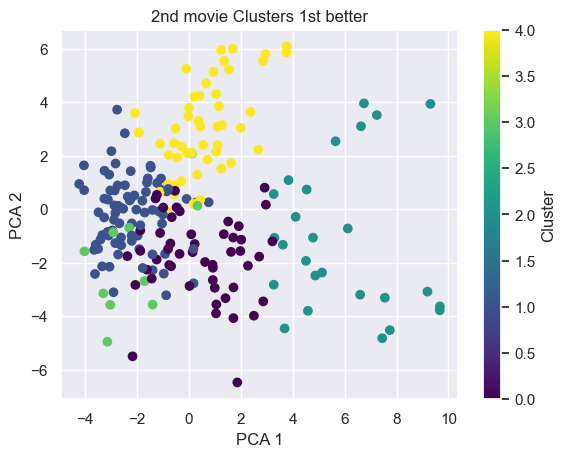

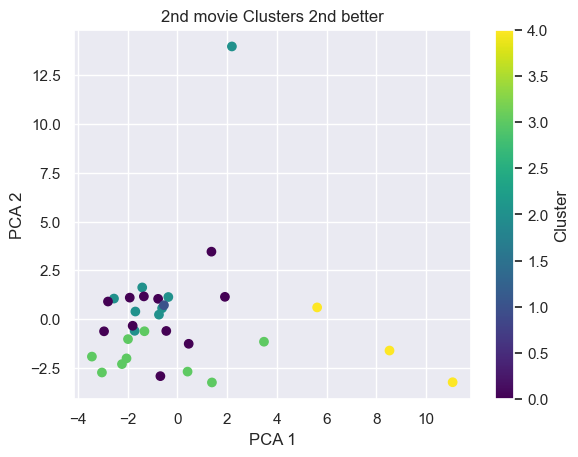

In [54]:
KNN_1_2 = get_1_2_movies(franchise_df)
KNN_1_2 = KNN_1_2.dropna(subset=['real_profit_1','real_profit_2'])
KNN_1_2 = KNN_1_2.drop(columns=['num_Asian_1','num_Asian_2','num_Black_1','num_Black_2','num_Hispanic_1','num_Hispanic_2','num_Middle Eastern_1','num_Middle Eastern_2','num_White_1','num_White_2','num_Native American_1','num_Native American_2','num_Others_1','num_Others_2','female_ratio_1','female_ratio_2'])
# seprate the franchise where the 2nd movie has a higher ratio than the first one
KNN_1_2_2ndbetter=KNN_1_2[KNN_1_2['ratio_revenue_budget_2'] > KNN_1_2['ratio_revenue_budget_1']]
KNN_1_2_1stbetter=KNN_1_2[KNN_1_2['ratio_revenue_budget_2'] <= KNN_1_2['ratio_revenue_budget_1']]

# Load and preprocess dat
#data = KNN_1_2_other.drop(columns=['collection_id','Wikipedia movie ID_1','Wikipedia movie ID_2','Movie name_1','Movie name_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2'])

data = KNN_1_2_1stbetter.drop(columns=['collection_id','Wikipedia movie ID_1','Wikipedia movie ID_2','Movie name_1','Movie name_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2'])

scaler = StandardScaler()
scaled_data_1st = scaler.fit_transform(data)


# Apply K-Means
kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init='auto')
clusters = kmeans.fit_predict(scaled_data_1st)

# Assign clusters back to franchise_data_df
KNN_1_2['Cluster'] = pd.NA  # Initialize Cluster column with NaN
KNN_1_2.loc[data.index, 'Cluster'] = clusters
    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data_1st)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('2nd movie Clusters 1st better')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# Load and preprocess dat
data = KNN_1_2_2ndbetter.drop(columns=['collection_id','Wikipedia movie ID_1','Wikipedia movie ID_2','Movie name_1','Movie name_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2'])


scaler = StandardScaler()
scaled_data_2nd = scaler.fit_transform(data)

# Apply K-Means
kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE,n_init='auto')
clusters = kmeans.fit_predict(scaled_data_2nd)

# Assign clusters back to franchise_data_df
KNN_1_2.loc[data.index, 'Cluster'] = -clusters-1
    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data_2nd)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('2nd movie Clusters 2nd better')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()


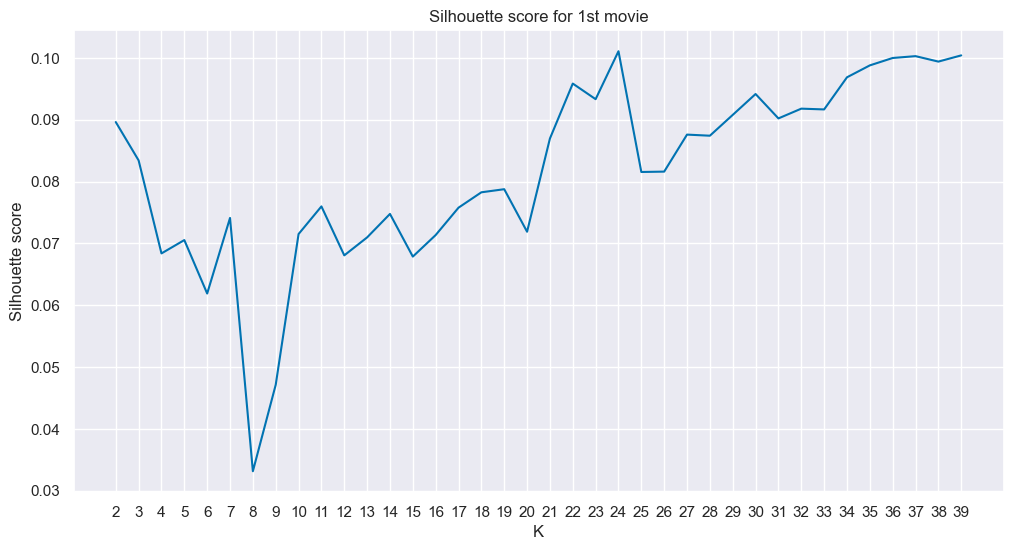

In [55]:
silhouettes = []

# Try multiple k
for k in range(2, 40):
    # Cluster the data and assigne the labels
    clusters = KMeans(n_clusters=k, random_state=42,n_init='auto').fit_predict(scaled_data_1st)
    # Get the Silhouette score
    score = silhouette_score(scaled_data_1st, clusters)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.figure(figsize=(12, 6))
plt.title('Silhouette score for 1st movie')
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.xticks(range(2, 40))
plt.show()

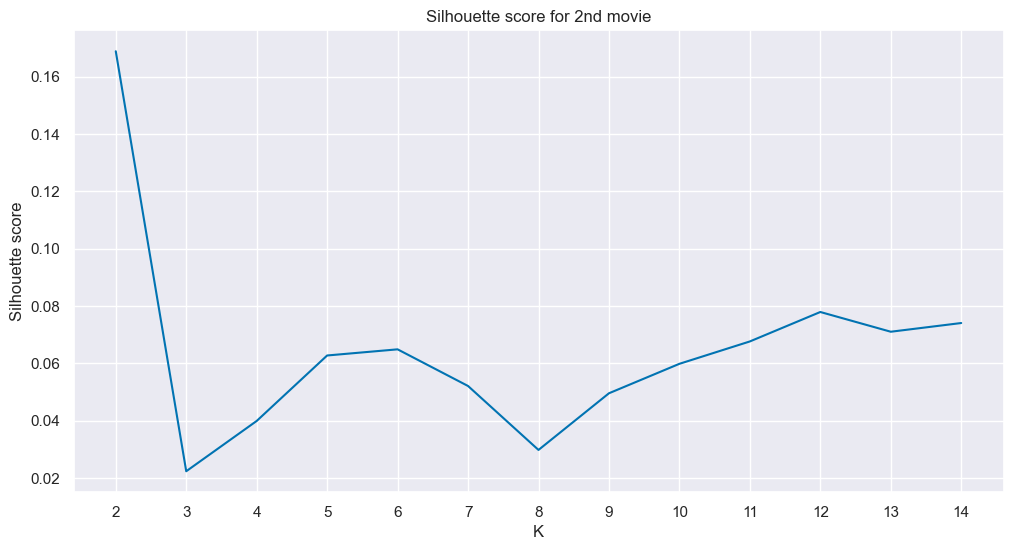

In [56]:
silhouettes = []

# Try multiple k
for k in range(2, 15):
    # Cluster the data and assigne the labels
    clusters = KMeans(n_clusters=k, random_state=42,n_init='auto').fit_predict(scaled_data_2nd)
    # Get the Silhouette score
    score = silhouette_score(scaled_data_2nd, clusters)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.figure(figsize=(12, 6))
plt.title('Silhouette score for 2nd movie')
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.xticks(range(2, 15))
plt.show()

Using the silouhette function we found that 5 is a good number of clusters for both and it's not creating too many cluster with a little number of franchise

### Visualization of what the cluster looks like

Franchise of the cluster of less than 10 movies:
    Cluster                     collection_name_1  \
2        -5      The Lord of the Rings Collection   
6        -5            The Dark Knight Collection   
26       -5               Harry Potter Collection   
815      -2  Clint Eastwood's Iwo Jima Collection   

                                          Movie name_1  \
2    The Lord of the Rings: The Fellowship of the Ring   
6                                        Batman Begins   
26            Harry Potter and the Philosopher's Stone   
815                               Flags of Our Fathers   

                                Movie name_2  
2      The Lord of the Rings: The Two Towers  
6                            The Dark Knight  
26   Harry Potter and the Chamber of Secrets  
815                    Letters from Iwo Jima  
Note that strictly negative cluster are the ones where the 2nd movie is better than the first one, positive cluster are the opposite


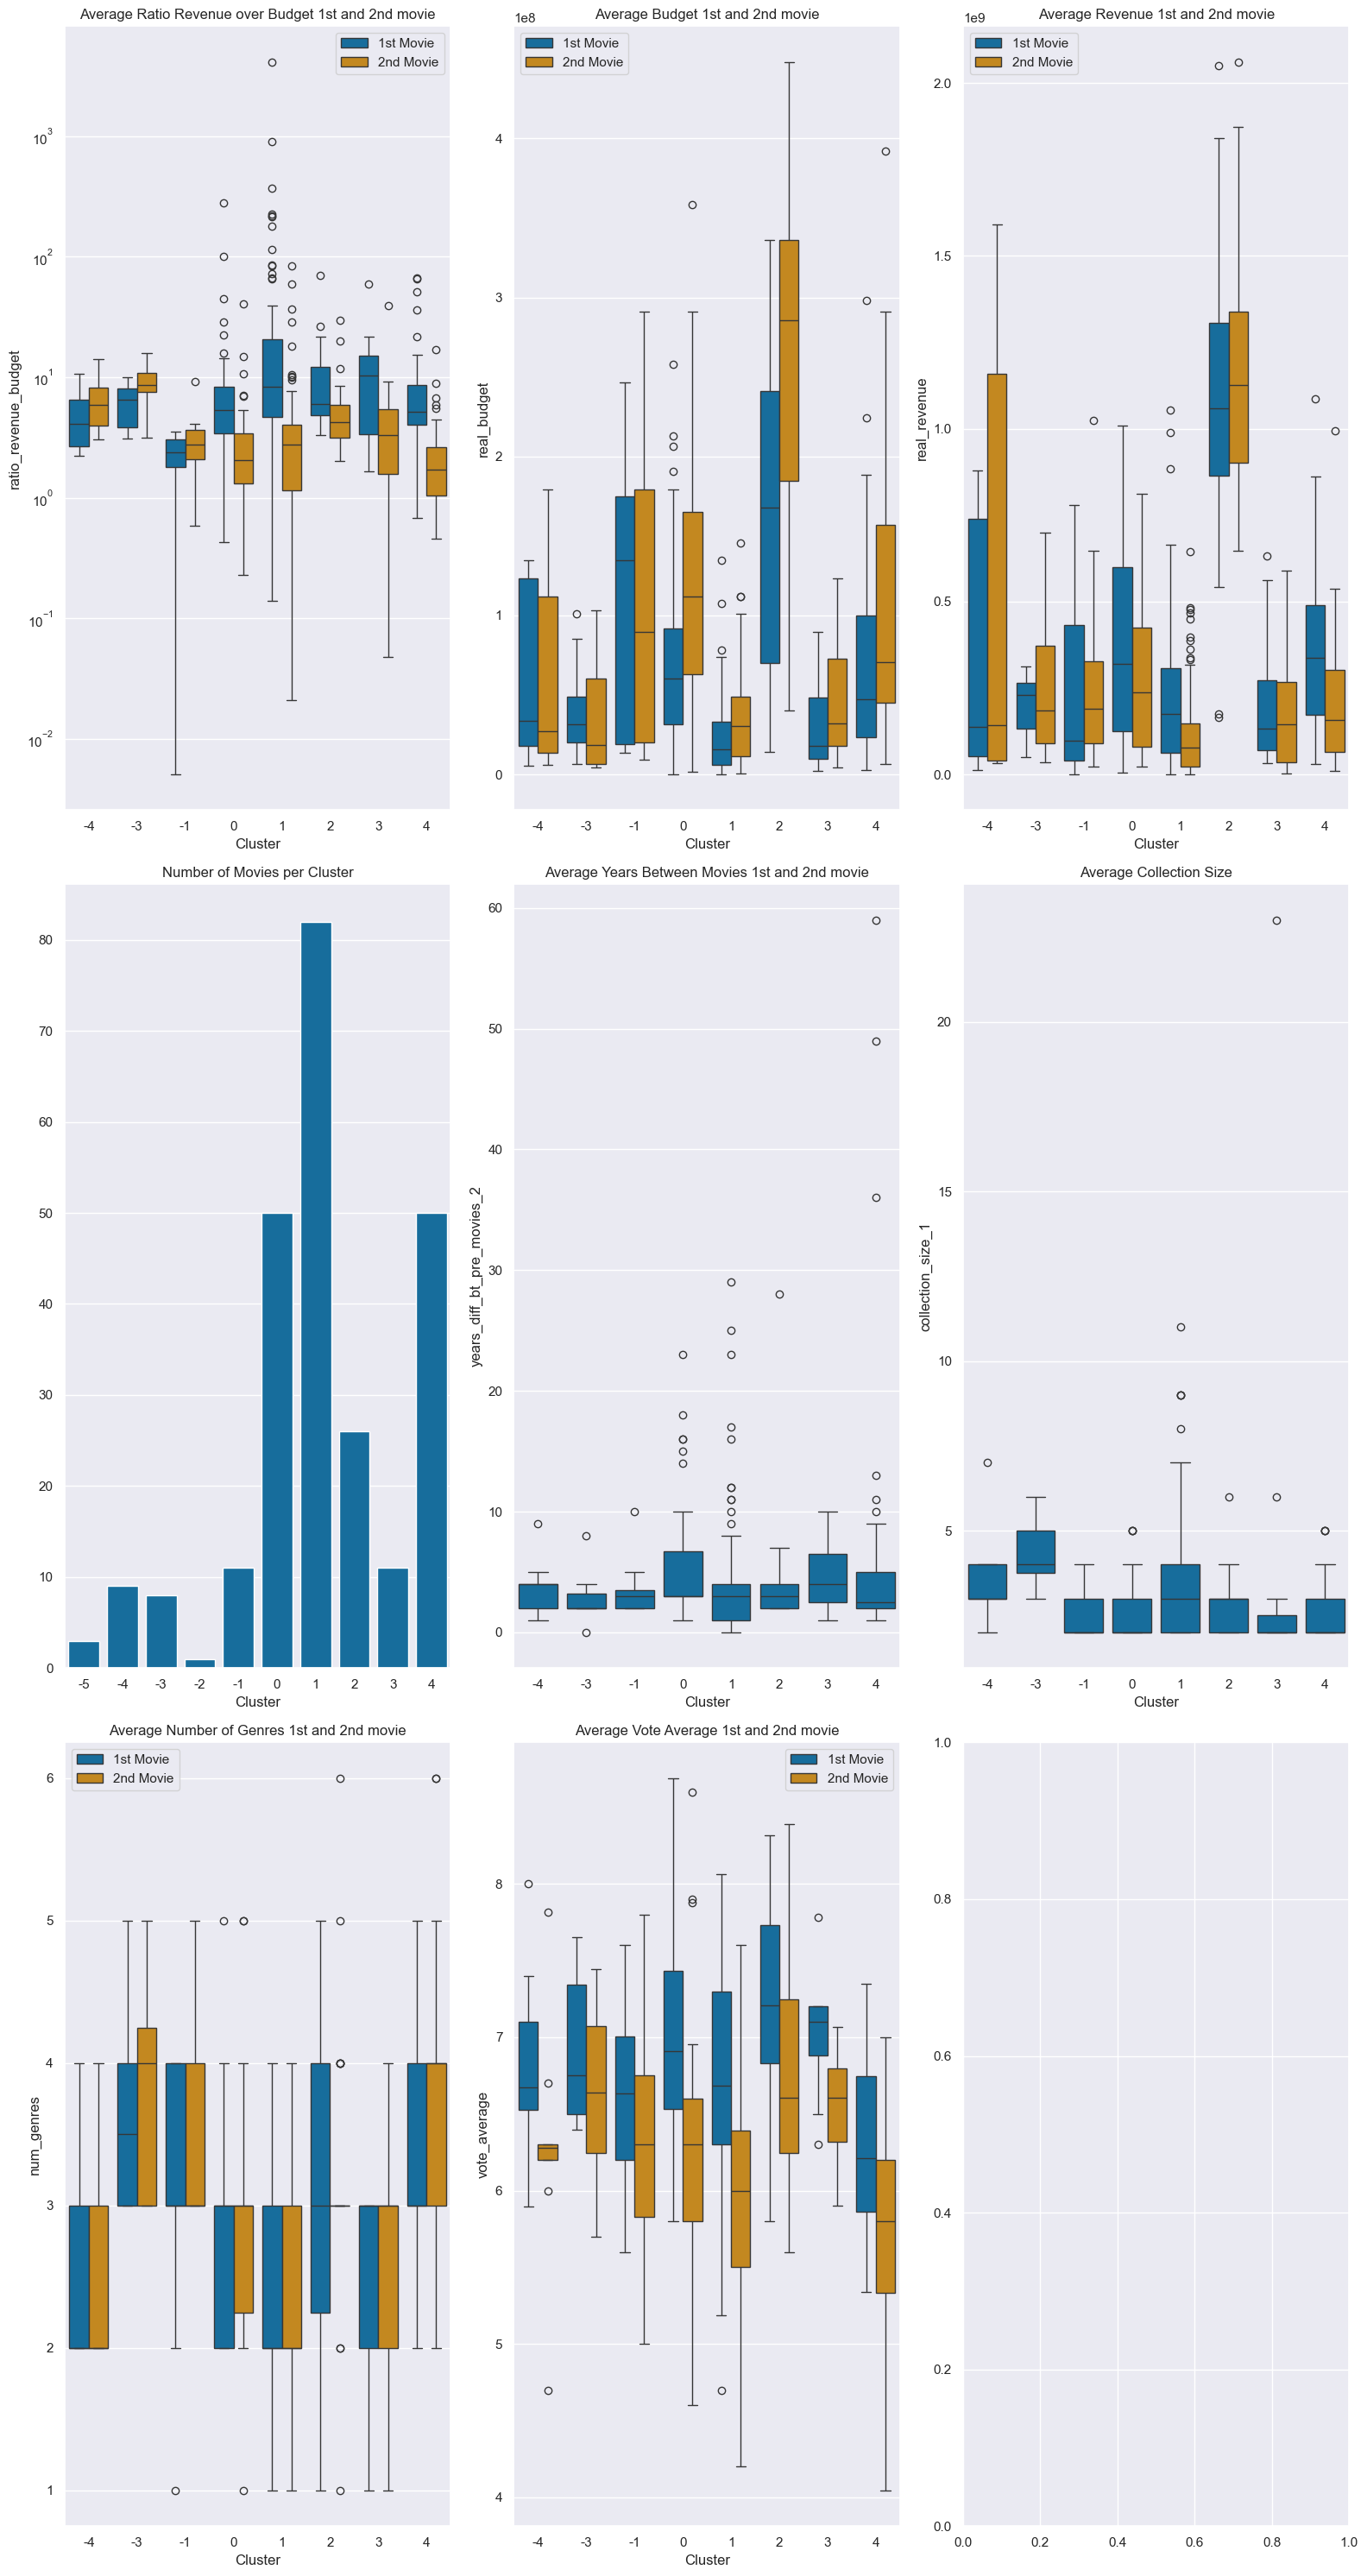

In [57]:
# Drop the cluster with less than 10 franchises idk if it is necessary
KNN_1_2_filt = KNN_1_2.groupby('Cluster').filter(lambda x: len(x) >= 5)

# Print the small cluster
print("Franchise of the cluster of less than 10 movies:")
print(KNN_1_2[~KNN_1_2['Cluster'].isin(KNN_1_2.groupby('Cluster').filter(lambda x: len(x) >= 5)['Cluster'])][['Cluster','collection_name_1','Movie name_1','Movie name_2']].sort_values(by='Cluster'))

print('Note that strictly negative cluster are the ones where the 2nd movie is better than the first one, positive cluster are the opposite')
fig, axs = plt.subplots(3, 3, figsize=(16, 30))


data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['ratio_revenue_budget_1', 'ratio_revenue_budget_2'],var_name='movie_nb', value_name='ratio_revenue_budget')
data_long['movie_nb']=data_long['movie_nb'].replace({'ratio_revenue_budget_1': '1st Movie', 'ratio_revenue_budget_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='ratio_revenue_budget', hue='movie_nb', ax=axs[0,0])
axs[0,0].legend()
axs[0,0].set_title('Average Ratio Revenue over Budget 1st and 2nd movie')
axs[0,0].set_yscale('log')

data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['real_budget_1', 'real_budget_2'],var_name='movie_nb', value_name='real_budget')
data_long['movie_nb']=data_long['movie_nb'].replace({'real_budget_1': '1st Movie', 'real_budget_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='real_budget', hue='movie_nb', ax=axs[0,1])
axs[0,1].legend()
axs[0,1].set_title('Average Budget 1st and 2nd movie')

data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['real_revenue_1', 'real_revenue_2'],var_name='movie_nb', value_name='real_revenue')
data_long['movie_nb']=data_long['movie_nb'].replace({'real_revenue_1': '1st Movie', 'real_revenue_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='real_revenue', hue='movie_nb', ax=axs[0,2])
axs[0,2].legend()
axs[0,2].set_title('Average Revenue 1st and 2nd movie')


sns.barplot(x=KNN_1_2['Cluster'].value_counts().index, y=KNN_1_2['Cluster'].value_counts().values, ax=axs[1,0])
axs[1,0].set_title('Number of Movies per Cluster')

sns.boxplot(x='Cluster', y='years_diff_bt_pre_movies_2', data=KNN_1_2_filt, ax=axs[1,1])
axs[1,1].set_title('Average Years Between Movies 1st and 2nd movie')

sns.boxplot(x='Cluster', y='collection_size_1', data=KNN_1_2_filt, ax=axs[1,2])
axs[1,2].set_title('Average Collection Size')


data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['num_genres_1', 'num_genres_2'],var_name='movie_nb', value_name='num_genres')
data_long['movie_nb']=data_long['movie_nb'].replace({'num_genres_1': '1st Movie', 'num_genres_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='num_genres', hue='movie_nb', ax=axs[2,0])
axs[2,0].legend()
axs[2,0].set_title('Average Number of Genres 1st and 2nd movie')

data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['vote_average_1', 'vote_average_2'],var_name='movie_nb', value_name='vote_average')
data_long['movie_nb']=data_long['movie_nb'].replace({'vote_average_1': '1st Movie', 'vote_average_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='vote_average', hue='movie_nb', ax=axs[2,1])
axs[2,1].legend()
axs[2,1].set_title('Average Vote Average 1st and 2nd movie')

plt.tight_layout()
plt.show()



Text(15.749999999999988, 0.5, 'Genre')

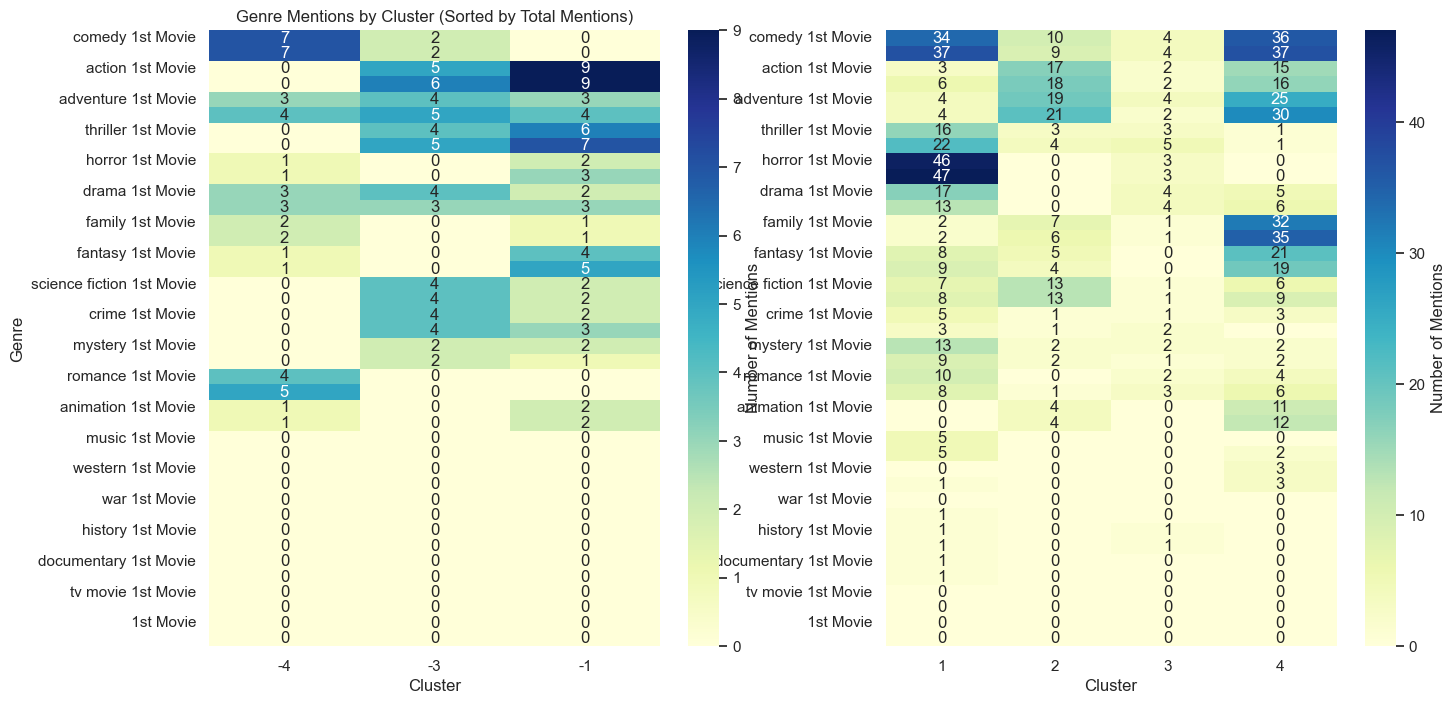

In [58]:
# Summing country of the 1st movie mentions by cluster
country_sums_1 = KNN_1_2_filt.groupby('Cluster')[
    [col for col in KNN_1_2_filt.columns if col.startswith('tmdb_origin_country_1_')]
].sum()

# Remove the 'country_' prefix from the column names
country_sums_1.columns = country_sums_1.columns.str.replace('tmdb_origin_country_1_', '')

# Sort countries by total mentions (sum across clusters)
country_sums_1 = country_sums_1.loc[:, country_sums_1.sum().sort_values(ascending=False).index]


# Summing country of the 2nd movie mentions by cluster
country_sums_2 = KNN_1_2_filt.groupby('Cluster')[
    [col for col in KNN_1_2_filt.columns if col.startswith('tmdb_origin_country_2_')]
].sum()

# Remove the 'country_' prefix from the column names
country_sums_2.columns = country_sums_2.columns.str.replace('tmdb_origin_country_2_', '')

# Sort countries by total mentions (sum across clusters)
country_sums_2 = country_sums_2.loc[:, country_sums_2.sum().sort_values(ascending=False).index]

# remove the country that are mentionned only once
country_sums_1 = country_sums_1.loc[:, country_sums_1.sum() > 1]
country_sums_2 = country_sums_2.loc[:, country_sums_2.sum() > 1]

for column in country_sums_1.columns:
    if column not in country_sums_2.columns:
        country_sums_2[column] = 0
country_sums_2 = country_sums_2[country_sums_1.columns]

# Interleave the columns (1st movie then 2nd movie for each cluster)
interleaved_columns = []
for cluster in country_sums_1.columns:
    interleaved_columns.append(country_sums_1[cluster].rename(f"{cluster} 1st Movie"))
    interleaved_columns.append(country_sums_2[cluster].rename(f"{cluster} 2nd Movie"))

# Combine into a single DataFrame
country_sums = pd.concat(interleaved_columns, axis=1)


# Summing genre mentions by cluster
genre_sums_1 = KNN_1_2_filt.groupby('Cluster')[
    [col for col in KNN_1_2_filt.columns if col.startswith('genre_1_')]
].sum()

# Remove the 'genre_' prefix from the column names
genre_sums_1.columns = genre_sums_1.columns.str.replace('genre_1_', '')

# Sort genres by total mentions (sum across clusters)
genre_sums_1 = genre_sums_1.loc[:, genre_sums_1.sum().sort_values(ascending=False).index]

# Summing genre mentions by cluster
genre_sums_2 = KNN_1_2_filt.groupby('Cluster')[
    [col for col in KNN_1_2_filt.columns if col.startswith('genre_2_')]
].sum()

# Remove the 'genre_' prefix from the column names
genre_sums_2.columns = genre_sums_2.columns.str.replace('genre_2_', '')

# Sort genres by total mentions (sum across clusters)
genre_sums_2 = genre_sums_2.loc[:, genre_sums_2.sum().sort_values(ascending=False).index]

# Interleave the columns (1st movie then 2nd movie for each cluster)
interleaved_columns = []
for cluster in genre_sums_1.columns:
    interleaved_columns.append(genre_sums_1[cluster].rename(f"{cluster} 1st Movie"))
    interleaved_columns.append(genre_sums_2[cluster].rename(f"{cluster} 2nd Movie"))

# Combine into a single DataFrame
genre_sums = pd.concat(interleaved_columns, axis=1)

# separate the negative and positive cluster
genre_sums_neg = genre_sums.T.iloc[:,0:3]
genre_sums_pos = genre_sums.T.iloc[:,4:10]


# Plot the heatmap
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(
    genre_sums_neg, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'},
    ax=axs[0]
)
axs[0].set_title('Genre Mentions by Cluster (Sorted by Total Mentions)')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Genre')

sns.heatmap(
    genre_sums_pos, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'},
    ax=axs[1]
)
axs[0].set_title('Genre Mentions by Cluster (Sorted by Total Mentions)')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Genre')


### Summary by cluster

Cluster -4:

In [59]:
KNN_1_2[KNN_1_2['Cluster']==-4][['collection_name_1','Movie name_1','Movie name_2']]

collection_name_1  \
63                        Ice Age Collection   
153                Harold & Kumar Collection   
160                  The Twilight Collection   
204              Meet the Parents Collection   
425                     Creepshow Collection   
432   National Lampoon's Vacation Collection   
505                     Before... Collection   
776                Daddy Day Camp Collection   
1151                        Madea Collection   

                           Movie name_1  \
63                              Ice Age   
153   Harold & Kumar Go to White Castle   
160                            Twilight   
204                    Meet the Parents   
425                           Creepshow   
432                            Vacation   
505                      Before Sunrise   
776                      Daddy Day Care   
1151         Diary of a Mad Black Woman   

                                   Movie name_2  
63                        Ice Age: The Meltdown  
153   Harold & Kumar Escape from Guantanamo Bay  
160                                    New Moon  
204                            Meet the Fockers  
425                                 Creepshow 2  
432        National Lampoon's European Vacation  
505                               Before Sunset  
776                              Daddy Day Camp  
1151       Tyler Perry's Madea's Family Reunion

Those are the high budget franchise that didnt had a increase in budget for the second movie and 

Cluster -3:

In [60]:
KNN_1_2[KNN_1_2['Cluster']==-3][['collection_name_1','Movie name_1','Movie name_2']]

collection_name_1  \
4    Star Trek: The Original Series Collection   
24                    Lethal Weapon Collection   
25                    Austin Powers Collection   
32    Planet of the Apes (Original) Collection   
128                      Death Wish Collection   
150                  The Millennium Collection   
161                         Airport Collection   
457  Star Trek: The Next Generation Collection   

                                    Movie name_1  \
4                  Star Trek: The Motion Picture   
24                                 Lethal Weapon   
25   Austin Powers: International Man of Mystery   
32                            Planet of the Apes   
128                                   Death Wish   
150              The Girl with the Dragon Tattoo   
161                                      Airport   
457                       Star Trek: Generations   

                              Movie name_2  
4          Star Trek II: The Wrath of Khan  
24                         Lethal Weapon 2  
25   Austin Powers: The Spy Who Shagged Me  
32          Beneath the Planet of the Apes  
128                          Death Wish II  
150          The Girl Who Played with Fire  
161                           Airport 1975  
457               Star Trek: First Contact

Cluster -2:

In [61]:
KNN_1_2[KNN_1_2['Cluster']==-2][['collection_name_1','Movie name_1','Movie name_2']]

collection_name_1          Movie name_1  \
815  Clint Eastwood's Iwo Jima Collection  Flags of Our Fathers   

              Movie name_2  
815  Letters from Iwo Jima

Cluster -1:

In [62]:
KNN_1_2[KNN_1_2['Cluster']==-1][['collection_name_1','Movie name_1','Movie name_2']]

collection_name_1  \
51            World of Watches Collection   
89             The Transporter Collection   
134                    Hellboy Collection   
154                 The Bourne Collection   
212          National Treasure Collection   
245  Arthur and the Invisibles Collection   
287        The Boondock Saints Collection   
314                Ghost Rider Collection   
411                    Firefly Collection   
460                        AVP Collection   
742      Rebuild of Evangelion Collection   

                            Movie name_1  \
51                           Night Watch   
89                       The Transporter   
134                              Hellboy   
154                  The Bourne Identity   
212                    National Treasure   
245            Arthur and the Invisibles   
287                  The Boondock Saints   
314                          Ghost Rider   
411                House of 1000 Corpses   
460              AVP: Alien vs. Predator   
742  Evangelion: 1.0 You Are (Not) Alone   

                              Movie name_2  
51                               Day Watch  
89                           Transporter 2  
134             Hellboy 2: The Golden Army  
154                   The Bourne Supremacy  
212     National Treasure: Book of Secrets  
245  Arthur and the Vengeance of Maltazard  
287     Boondock Saints II: All Saints Day  
314       Ghost Rider: Spirit of Vengeance  
411                    The Devil's Rejects  
460     AVPR: Aliens vs Predator - Requiem  
742                        Evangelion: 2.0

Cluster 1:

In [63]:
KNN_1_2[KNN_1_2['Cluster']==0][['collection_name_1','Movie name_1','Movie name_2']]

collection_name_1                 Movie name_1  \
5                 The Godfather Collection                The Godfather   
9                       Ocean's Collection               Ocean's Eleven   
11                     Predator Collection                     Predator   
21                        Blade Collection                        Blade   
28                     Die Hard Collection                     Die Hard   
31                        Zorro Collection            The Mask of Zorro   
40                   Underworld Collection                   Underworld   
44                  Tomb Raider Collection      Lara Croft: Tomb Raider   
47    The Chronicles of Riddick Collection                  Pitch Black   
49                    Kill Bill Collection           Kill Bill Volume 1   
57                The Space Odyssey Series        2001: A Space Odyssey   
60                      RoboCop Collection                      RoboCop   
62                        Alien Collection                        Alien   
65                     Superman Collection                     Superman   
87                     The Crow Collection                     The Crow   
88     The Fast and the Furious Collection     The Fast and the Furious   
91                       Mexico Collection                  El Mariachi   
93          The Hannibal Lecter Collection     The Silence of the Lambs   
131                    Bad Boys Collection                     Bad Boys   
141                 The X Files Collection                  The X Files   
175                       Speed Collection                        Speed   
185           Big Momma's House Collection          Big Momma's House 2   
188           Missing in Action Collection            Missing in Action   
203            Sex and the City Collection  Sex and the City: The Movie   
207                 Wall Street Collection                  Wall Street   
208                         xXx Collection                          XXX   
214                  Hot Shots! Collection                   Hot Shots!   
233                       Crank Collection                        Crank   
246           Beverly Hills Cop Collection            Beverly Hills Cop   
254            Charlie's Angels Collection             Charlie's Angels   
272              Basic Instinct Collection               Basic Instinct   
316                   Rush Hour Collection                    Rush Hour   
324                Chili Palmer Collection                   Get Shorty   
400    The Whole Nine/Ten Yards Collection         The Whole Nine Yards   
444                 Under Siege Collection                  Under Siege   
446          The Blues Brothers Collection           The Blues Brothers   
463             Escape From ... Collection         Escape from New York   
482                      Batman Collection                       Batman   
521             The Expendables Collection              The Expendables   
548                       Taken Collection                        Taken   
581                  Alex Cross Collection               Kiss the Girls   
611           French Connection Collection        The French Connection   
628                    Stakeout Collection                     Stakeout   
656                         F/X Collection                          F/X   
708               The Jack Ryan Collection     The Hunt for Red October   
784                  Billy Jack Collection              The Born Losers   
926             The Jake Gittes Collection                    Chinatown   
1208               The Punisher Collection                 The Punisher   
1280      Marshal Samuel Gerard Collection                 The Fugitive   
1288         American Civil War Collection                   Gettysburg   

                                       Movie name_2  
5                             The Godfather Part II  
9                                    Ocean's Twelve  
11                                   

Cluster 2:

In [64]:
KNN_1_2[KNN_1_2['Cluster']==1][['collection_name_1','Movie name_1','Movie name_2']]

collection_name_1  \
20                                Saw Collection   
29                              Rocky Collection   
35                          Evil Dead Collection   
37                         The Grudge Collection   
42                               Jaws Collection   
45                             Scream Collection   
48                       American Pie Collection   
50                       Ghostbusters Collection   
52                        Ace Ventura Collection   
54    I Know What You Did Last Summer Collection   
56                        Scary Movie Collection   
67          A Nightmare on Elm Street Collection   
72                  Final Destination Collection   
73                         Hellraiser Collection   
74       The Hills Have Eyes (Reboot) Collection   
77                      Wayne's World Collection   
84                     Police Academy Collection   
85               An American Werewolf Collection   
90                 Look Who's Talking Collection   
92                    Friday the 13th Collection   
96                            Species Collection   
100                       Poltergeist Collection   
101                      Child's Play Collection   
111                          The Omen Collection   
124                      The Exorcist Collection   
129                          The Ring Collection   
133                           Jackass Collection   
135                     Resident Evil Collection   
155                 The Toxic Avenger Collection   
165                         Naked Gun Collection   
170               Paranormal Activity Collection   
179                            Friday Collection   
206                      Urban Legend Collection   
213                        Wrong Turn Collection   
229                   The Blue Lagoon Collection   
232                       Blair Witch Collection   
251                    Legally Blonde Collection   
256                     Dirty Dancing Collection   
258                            Grease Collection   
259                           Step Up Collection   
270                            Cocoon Collection   
278                            Hostel Collection   
289             Smokey and the Bandit Collection   
309                      The Gremlins Collection   
317                         Halloween Collection   
322                          Airplane Collection   
341                  Jeepers Creepers Collection   
343                     Deuce Bigalow Collection   
346                   Dumb and Dumber Collection   
359                           Air Bud Collection   
385         Return of the Living Dead Collection   
395                             House Collection   
399                        Sister Act Collection   
404                        Piranha 3D Collection   
436                           Porky's Collection   
437                    The Fly (1986) Collection   
442           Texas Chainsaw Massacre Collection   
454              Tales from the Crypt Collection   
479                            Psycho Collection   
489                    The Omega Code Collection   
512                           Hatchet Collection   
518                 American Graffiti Collection   
550                  King Kong (1933) Collection   
585             Why Did I Get Married Collection   
638                    Atlas Shrugged Collection   
668                        Barbershop Collection   
685                            Clerks Collection   
756            The Vampire Chronicles Collection   
787            The Work and the Glory Collection   
803        Silent Night, Deadly Night Collection   
807                            Carrie Collection   
817                       Living Dead Collection   
903                            Ernest Collection   
914                          The Gate Collection   
939                         Demetrius Collection   
973                       The Hustler Collection   
988                    The 

Cluster 3:

In [65]:
KNN_1_2[KNN_1_2['Cluster']==2][['collection_name_1','Movie name_1','Movie name_2']]

collection_name_1  \
0               Star Wars Collection   
1           Indiana Jones Collection   
7      Back to the Future Collection   
10          Jurassic Park Collection   
16         The Terminator Collection   
18             Spider-Man Collection   
22                  X-Men Collection   
33              The Mummy Collection   
38                  Shrek Collection   
41             The Matrix Collection   
69           Transformers Collection   
94         Fantastic Four Collection   
97             Home Alone Collection   
98              Toy Story Collection   
130            Madagascar Collection   
230                  TRON Collection   
248   Night at the Museum Collection   
255          Men In Black Collection   
267          The Hangover Collection   
280   Clash of the Titans Collection   
286                  Cars Collection   
300   Mission: Impossible Collection   
392       Sherlock Holmes Collection   
461        Robert Langdon Collection   
529              Iron Man Collection   
1184              Journey Collection   

                                       Movie name_1  \
0                  Star Wars Episode IV: A New Hope   
1     Indiana Jones and the Raiders of the Lost Ark   
7                                Back to the Future   
10                                    Jurassic Park   
16                                   The Terminator   
18                                       Spider-Man   
22                                            X-Men   
33                                        The Mummy   
38                                            Shrek   
41                                       The Matrix   
69                                     Transformers   
94                                   Fantastic Four   
97                                       Home Alone   
98                                        Toy Story   
130                                      Madagascar   
230                                            Tron   
248                             Night at the Museum   
255                                    Men in Black   
267                                    The Hangover   
280                             Clash of the Titans   
286                                            Cars   
300                             Mission: Impossible   
392                                 Sherlock Holmes   
461                               The Da Vinci Code   
529                                        Iron Man   
1184             Journey to the Center of the Earth   

                                        Movie name_2  
0       Star Wars Episode V: The Empire Strikes Back  
1               Indiana Jones and the Temple of Doom  
7                         Back to the Future Part II  
10                     The Lost World: Jurassic Park  
16                        Terminator 2: Judgment Day  
18                                      Spider-Man 2  
22                                                X2  
33                                 The Mummy Returns  
38                                           Shrek 2  
41                               The Matrix Reloaded  
69               Transformers: Revenge of the Fallen  
94         Fantastic Four: Rise of the Silver Surfer  
97                    Home Alone 2: Lost in New York  
98                                       Toy Story 2  
130                      Madagascar: Escape 2 Africa  
230                                     Tron: Legacy  
248   Night at the Museum: Battle of the Smithsonian  
255                                  Men in Black II  
267                            The Hangover: Part II  
280                              Wrath of the Titans  
286                                           Cars 2  
300                           Mission: Impossible II  
392               Sherlock Holmes: A Game of Shadows  
461                                Angels and Demons  
529                                       Iron Man 2  
1184                Jo

Cluster 4:

In [66]:
KNN_1_2[KNN_1_2['Cluster']==3][['collection_name_1','Movie name_1','Movie name_2']]

collection_name_1           Movie name_1  \
19                        James Bond Collection                 Dr. No   
27               28 Days/Weeks Later Collection          28 Days Later   
34        USA: Land of Opportunities Collection               Dogville   
75                     Bridget Jones Collection  Bridget Jones's Diary   
242                            [REC] Collection                    REC   
266                   Johnny English Collection         Johnny English   
299                      The Descent Collection            The Descent   
378                        Elizabeth Collection              Elizabeth   
398                         Mr. Bean Collection                   Bean   
782                   Spanish Apartment Trilogy               Pot Luck   
1316  Hercule Poirot (Peter Ustinov) Collection      Death on the Nile   

                           Movie name_2  
19                From Russia with Love  
27                       28 Weeks Later  
34                            Manderlay  
75    Bridget Jones: The Edge of Reason  
242                               REC 2  
266               Johnny English Reborn  
299                       The Descent 2  
378           Elizabeth: The Golden Age  
398                  Mr. Bean's Holiday  
782                   The Russian Dolls  
1316                 Evil Under the Sun

Cluster 5:

In [67]:
KNN_1_2[KNN_1_2['Cluster']==4][['collection_name_1','Movie name_1','Movie name_2']]

collection_name_1  \
30       Teenage Mutant Ninja Turtles Collection   
53                       Dr. Dolittle Collection   
61                         Highlander Collection   
66                     The Karate Kid Collection   
81                         Free Willy Collection   
82                         Young Guns Collection   
83                   Crocodile Dundee Collection   
86                               Babe Collection   
95                      Mortal Kombat Collection   
117                     Addams Family Collection   
162                           Pokémon Collection   
172               Conan the Barbarian Collection   
176                         Teen Wolf Collection   
177                          The Mask Collection   
217                  The Santa Clause Collection   
219                         Peter Pan Collection   
220                          Fantasia Collection   
223                           Rugrats Collection   
224                      The Rescuers Collection   
228                     Shanghai Noon Collection   
239                      3 Ninja Kids Collection   
240          Honey, I Shrunk the Kids Collection   
253               The Nutty Professor Collection   
261              Diary of a Wimpy Kid Collection   
264                          Garfield Collection   
274                     Short Circuit Collection   
276                          Spy Kids Collection   
282                        Scooby-Doo Collection   
283                       Cats & Dogs Collection   
297                       Hoodwinked! Collection   
311               Romancing the Stone Collection   
318                  Agent Cody Banks Collection   
319             The Neverending Story Collection   
325                        Bill & Ted Collection   
329                        Happy Feet Collection   
361                   The Jungle Book Collection   
377                     Stuart Little Collection   
388                    Cannonball Run Collection   
452       Cheaper by the Dozen (2003) Collection   
514      101 Dalmatians (Live-Action) Collection   
517                          Almighty Collection   
528   The Pink Panther (Steve Martin) Collection   
551                  King Kong (1976) Collection   
596                  Without a Paddle Collection   
604                     City Slickers Collection   
642           Alvin and the Chipmunks Collection   
680                     Problem Child Collection   
772                   The Brady Bunch Collection   
921                   The Flintstones Collection   
1267                    Power Rangers Collection   

                                  Movie name_1  \
30                Teenage Mutant Ninja Turtles   
53                                Dr. Dolittle   
61                                  Highlander   
66                              The Karate Kid   
81                                  Free Willy   
82                                  Young Guns   
83                            Crocodile Dundee   
86                                        Babe   
95                               Mortal Kombat   
117                          The Addams Family   
162                   Pokémon: The First Movie   
172                        Conan the Barbarian   
176                                  Teen Wolf   
177                                   The Mask   
217                           The Santa Clause   
219                                  Peter Pan   
220                                   Fantasia   
223                          The Rugrats Movie   
224                               The Rescuers   
228                              Shanghai Noon   
239                                   3 Ninjas   
240                   Honey, I Shrunk the Kids   
253                        The Nutty Professor   
261                       Diary of a Wimpy Kid   
264                        Garfield: The Movie   
274                              Short Circuit   
276                         